In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 2})
from scipy import stats
from loss import FAR, RnCLoss
from models import MLP
from utils import pair_dataset, set_all_seeds

/home/dixzhu/miniconda3/envs/bioinfo/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/dixzhu/miniconda3/envs/bioinfo/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Sine Dataset

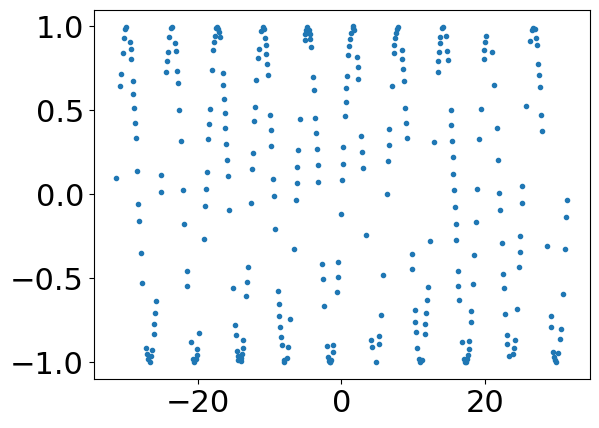

In [2]:
tmp = np.load('data/sine.npz')
X = tmp['X']
y = tmp['y']
ids = tmp['ids']
teN = int(0.5*X.shape[0])
te_ids = ids[:teN]
tr_ids = ids[teN:]
trX = X[tr_ids]
trY = y[tr_ids]
teX = X[te_ids]
teY = y[te_ids]
plt.figure()
plt.plot(trX, trY, '.')
tr_pair_data = pair_dataset(trX, trY)
te_pair_data = pair_dataset(teX, teY)
BATCH_SIZE = 128
trainloader = torch.utils.data.DataLoader(dataset=tr_pair_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(dataset=te_pair_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=False, drop_last=False)
epochs = 300
milestones = [100, 200]

In [ ]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_FAR = []

alpha = 0.5

for seed in seeds:
    set_all_seeds(seed)
    loss_FAR = FAR(alpha = alpha)
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss = loss_FAR(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='FAR')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='FAR')
    plt.legend()

    preds_FAR.append(pred_Y)
    


In [ ]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_RNC = []

for seed in seeds:
    set_all_seeds(seed)
    RNC = RnCLoss(temperature=4)
    basic_loss = torch.nn.L1Loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, feat = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            if epoch < 100:
                loss = RNC(feat, tr_Y)
            else:
                loss = basic_loss(pred_Y, tr_Y)
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, feat = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, feat = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='RNC')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='RNC')
    plt.legend()

    preds_RNC.append(pred_Y)
    


In [ ]:
lr = 0.01
decay = 0
class pearson_loss(torch.nn.Module):
    def __init__(self, device = None):
        super().__init__()
        if not device:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device


    def forward(self, y_pred, y_truth):
        pred_std, truth_std = y_pred.std(dim=0), y_truth.std(dim=0)
        pred_mean, truth_mean = y_pred.mean(dim=0), y_truth.mean(dim=0)
        loss = ((y_pred-pred_mean)/pred_std - (y_truth-truth_mean)/truth_std)**2/2
        return loss.mean()


seeds = [1,2,3,4,5]
preds_Pearson = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    loss_pearson = pearson_loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            ploss = loss_pearson(pred_Y, tr_Y)
            beta = ploss.detach()/2
            loss = (1-beta)*loss_MAE(pred_Y, tr_Y) + beta*ploss
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE-Pearson')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE-Pearson')
    plt.legend()

    preds_Pearson.append(pred_Y)
    


In [ ]:
lr = 0.01
decay = 0

seeds = [1,2,3,4,5]
preds_MAE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MAE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE')
    plt.legend()

    preds_MAE.append(pred_Y)
    


In [ ]:
lr = 0.01
decay = 0

seeds = [1,2,3,4,5]
preds_MSE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MSE = torch.nn.MSELoss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MSE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MSE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MSE')
    plt.legend()

    preds_MSE.append(pred_Y)
    


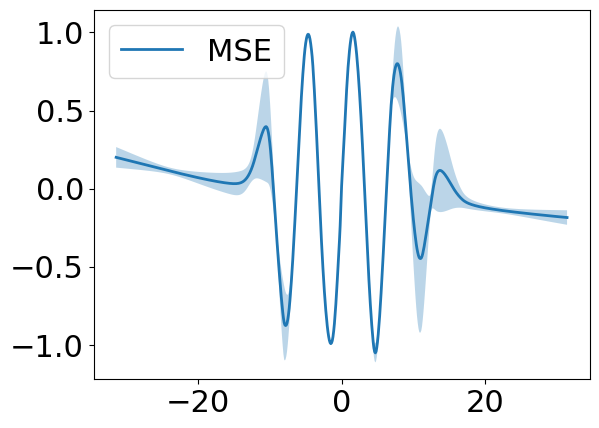

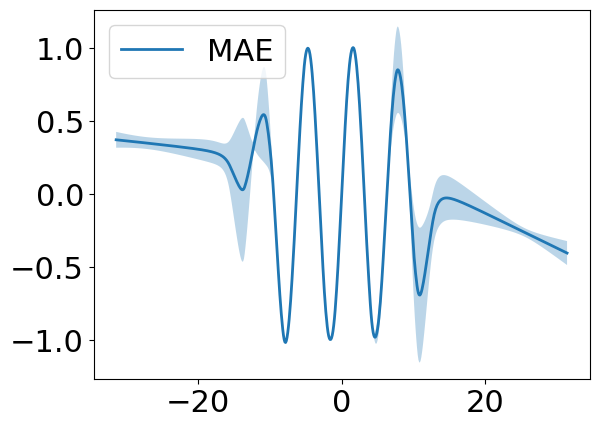

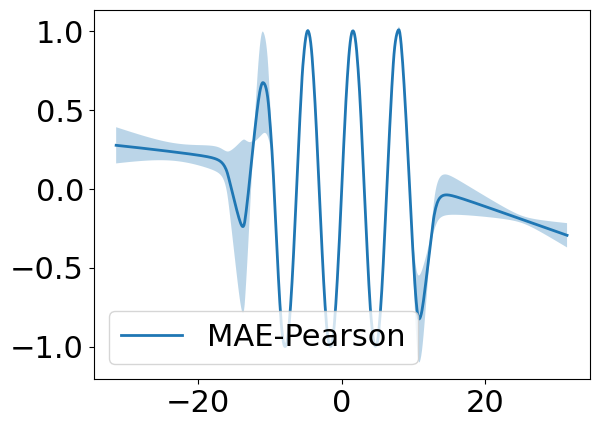

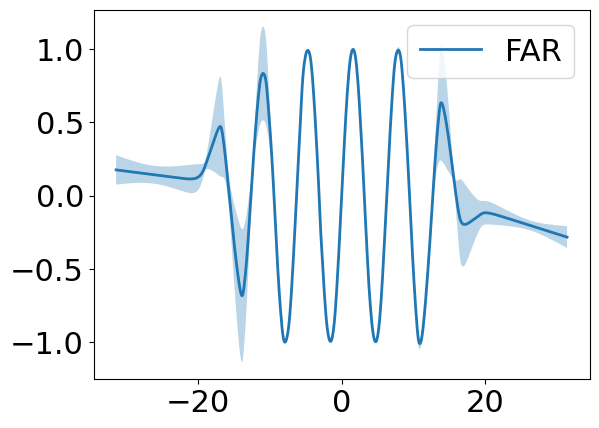

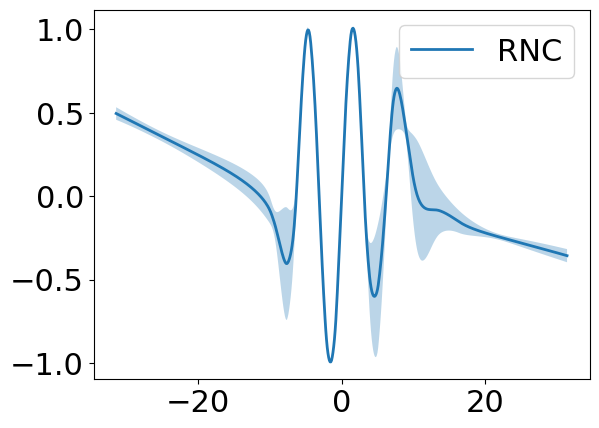

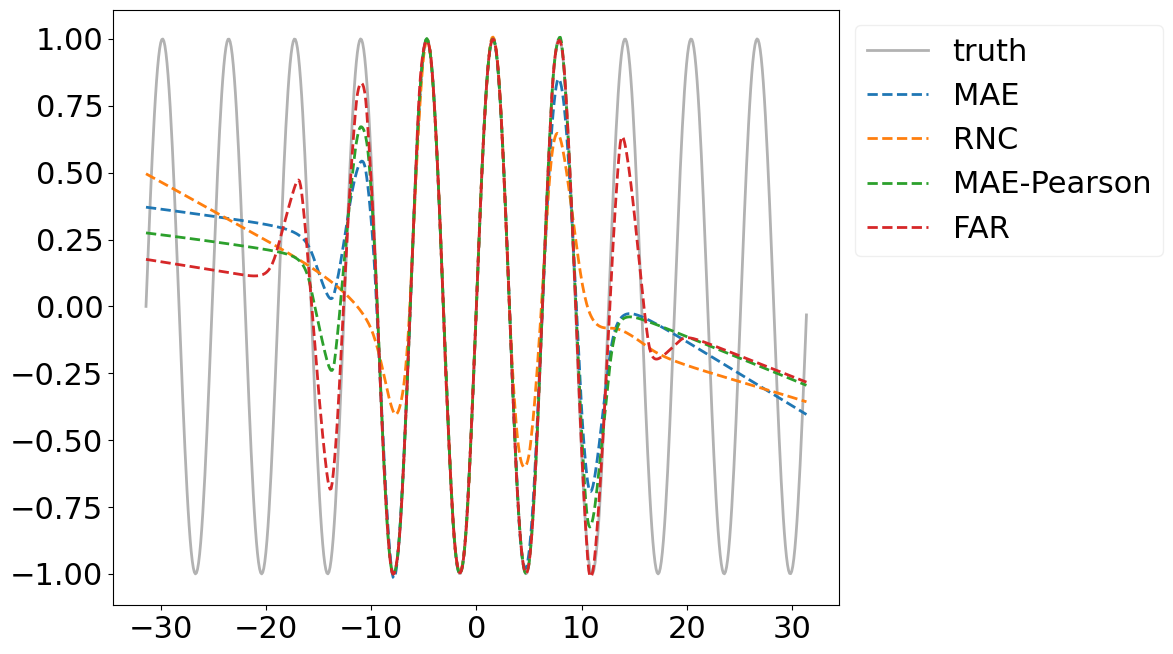

In [29]:
np.savez('data/sine_results.npz',preds_FAR=preds_FAR, preds_RNC=preds_RNC, preds_Pearson=preds_Pearson, preds_MAE=preds_MAE, preds_MSE=preds_MSE)


MSE = np.concatenate(preds_MSE, axis=1)
mean_MSE = MSE.mean(axis=1)
std_MSE = MSE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MSE, label='MSE')
plt.fill_between(X.squeeze(),mean_MSE-std_MSE, mean_MSE+std_MSE, alpha=0.3)
plt.legend()
plt.savefig('figures/sin_MSE.pdf',format='pdf')



MAE = np.concatenate(preds_MAE, axis=1)
mean_MAE = MAE.mean(axis=1)
std_MAE = MAE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MAE, label='MAE')
plt.fill_between(X.squeeze(),mean_MAE-std_MAE, mean_MAE+std_MAE, alpha=0.3)
plt.legend()
plt.savefig('figures/sin_MAE.pdf',format='pdf')



APearson = np.concatenate(preds_Pearson, axis=1)
mean_APearson = APearson.mean(axis=1)
std_APearson = APearson.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_APearson, label='MAE-Pearson')
plt.fill_between(X.squeeze(),mean_APearson-std_APearson, mean_APearson+std_APearson, alpha=0.3)
plt.legend()
plt.savefig('figures/sin_APearson.pdf',format='pdf')


preds_FAR = np.concatenate(preds_FAR, axis=1)
mean_FAR = preds_FAR.mean(axis=1)
std_FAR = preds_FAR.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_FAR, label='FAR')
plt.fill_between(X.squeeze(),mean_FAR-std_FAR, mean_FAR+std_FAR, alpha=0.3)
plt.legend()
plt.savefig('figures/sin_FAR.pdf',format='pdf')



RNC = np.concatenate(preds_RNC, axis=1)
mean_RNC = RNC.mean(axis=1)
std_RNC = RNC.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_RNC, label='RNC')
plt.fill_between(X.squeeze(),mean_RNC-std_RNC, mean_RNC+std_RNC, alpha=0.3)
plt.legend()
plt.savefig('figures/sin_RNC.pdf',format='pdf')


plt.figure(figsize=(12,7))
plt.plot(X, y, 'k-', alpha=0.3, label='truth')
plt.plot(X.squeeze(), mean_MAE, '--', label='MAE')
plt.plot(X.squeeze(), mean_RNC, '--', label='RNC')
plt.plot(X.squeeze(), mean_APearson, '--', label='MAE-Pearson')
plt.plot(X.squeeze(), mean_FAR, '--', label='FAR')
plt.legend(fancybox=True, framealpha=0.3, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('figures/sin_all_mean_cmp.pdf',format='pdf')

# Squared sine dataset

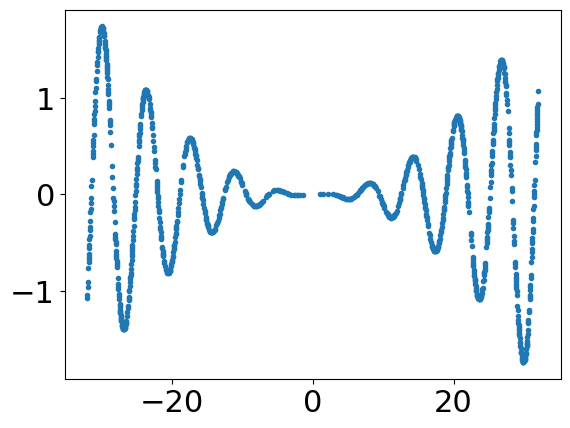

In [2]:
tmp = np.load('data/sq_sine.npz')
X = tmp['X']
y = tmp['y']
ids = tmp['ids']
teN = int(0.5*X.shape[0])
te_ids = ids[:teN]
tr_ids = ids[teN:]
trX = X[tr_ids]
trY = y[tr_ids]
teX = X[te_ids]
teY = y[te_ids]
plt.figure()
plt.plot(trX, trY, '.')
tr_pair_data = pair_dataset(trX, trY)
te_pair_data = pair_dataset(teX, teY)
BATCH_SIZE = 128
trainloader = torch.utils.data.DataLoader(dataset=tr_pair_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(dataset=te_pair_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=False, drop_last=False)
epochs = 300
milestones = [100, 200]

Epoch=0, train_MAE=2.0602, train_RMSE=2.6934, train_Pearson=-0.0220, train_Spearman=-0.0263, lr=0.0100
test_MAE=0.8241, test_RMSE=1.0497, test_Pearson=0.1678, test_Spearman=0.1036
Epoch=1, train_MAE=0.7422, train_RMSE=0.9480, train_Pearson=0.0420, train_Spearman=0.0303, lr=0.0100
test_MAE=1.0708, test_RMSE=1.3338, test_Pearson=-0.1347, test_Spearman=-0.1182
Epoch=2, train_MAE=0.7208, train_RMSE=0.9298, train_Pearson=-0.0067, train_Spearman=0.0099, lr=0.0100
test_MAE=0.6042, test_RMSE=0.7763, test_Pearson=0.2009, test_Spearman=0.2011
Epoch=3, train_MAE=0.6420, train_RMSE=0.8104, train_Pearson=0.1011, train_Spearman=0.0694, lr=0.0100
test_MAE=0.6060, test_RMSE=0.7640, test_Pearson=0.2124, test_Spearman=0.1988
Epoch=4, train_MAE=0.6371, train_RMSE=0.7938, train_Pearson=0.0901, train_Spearman=0.0781, lr=0.0100
test_MAE=0.6329, test_RMSE=0.8152, test_Pearson=0.2085, test_Spearman=0.1806
Epoch=5, train_MAE=0.6696, train_RMSE=0.8522, train_Pearson=0.1032, train_Spearman=0.0665, lr=0.0100
test

Epoch=46, train_MAE=0.6347, train_RMSE=0.7994, train_Pearson=0.1182, train_Spearman=0.0685, lr=0.0100
test_MAE=0.5971, test_RMSE=0.7575, test_Pearson=0.2579, test_Spearman=0.1945
Epoch=47, train_MAE=0.6746, train_RMSE=0.8828, train_Pearson=0.1068, train_Spearman=0.0677, lr=0.0100
test_MAE=0.5921, test_RMSE=0.7652, test_Pearson=0.2287, test_Spearman=0.2000
Epoch=48, train_MAE=0.6285, train_RMSE=0.7870, train_Pearson=0.1053, train_Spearman=0.0619, lr=0.0100
test_MAE=0.5992, test_RMSE=0.7764, test_Pearson=0.2059, test_Spearman=0.2013
Epoch=49, train_MAE=0.6237, train_RMSE=0.7785, train_Pearson=0.1381, train_Spearman=0.0988, lr=0.0100
test_MAE=0.5887, test_RMSE=0.7501, test_Pearson=0.2691, test_Spearman=0.2055
Epoch=50, train_MAE=0.6305, train_RMSE=0.7844, train_Pearson=0.1299, train_Spearman=0.0563, lr=0.0100
test_MAE=0.5966, test_RMSE=0.7518, test_Pearson=0.2669, test_Spearman=0.2168
Epoch=51, train_MAE=0.6192, train_RMSE=0.7692, train_Pearson=0.1839, train_Spearman=0.1189, lr=0.0100
tes

Epoch=92, train_MAE=0.6163, train_RMSE=0.7747, train_Pearson=0.1697, train_Spearman=0.0952, lr=0.0100
test_MAE=0.5948, test_RMSE=0.7599, test_Pearson=0.2565, test_Spearman=0.1602
Epoch=93, train_MAE=0.6117, train_RMSE=0.7642, train_Pearson=0.2091, train_Spearman=0.1378, lr=0.0100
test_MAE=0.5824, test_RMSE=0.7419, test_Pearson=0.3085, test_Spearman=0.1659
Epoch=94, train_MAE=0.6272, train_RMSE=0.7794, train_Pearson=0.1814, train_Spearman=0.0969, lr=0.0100
test_MAE=0.6655, test_RMSE=0.8200, test_Pearson=0.3017, test_Spearman=0.1539
Epoch=95, train_MAE=0.6391, train_RMSE=0.7915, train_Pearson=0.1341, train_Spearman=0.1073, lr=0.0100
test_MAE=0.6027, test_RMSE=0.7575, test_Pearson=0.3298, test_Spearman=0.2360
Epoch=96, train_MAE=0.6133, train_RMSE=0.7697, train_Pearson=0.1901, train_Spearman=0.1450, lr=0.0100
test_MAE=0.6029, test_RMSE=0.7592, test_Pearson=0.3159, test_Spearman=0.1528
Epoch=97, train_MAE=0.6235, train_RMSE=0.7778, train_Pearson=0.2111, train_Spearman=0.1312, lr=0.0100
tes

test_MAE=0.4950, test_RMSE=0.6530, test_Pearson=0.5486, test_Spearman=0.4880
Epoch=138, train_MAE=0.5149, train_RMSE=0.6780, train_Pearson=0.5032, train_Spearman=0.4592, lr=0.0010
test_MAE=0.4958, test_RMSE=0.6510, test_Pearson=0.5499, test_Spearman=0.4922
Epoch=139, train_MAE=0.5281, train_RMSE=0.6853, train_Pearson=0.4925, train_Spearman=0.4391, lr=0.0010
test_MAE=0.4981, test_RMSE=0.6455, test_Pearson=0.5604, test_Spearman=0.4859
Epoch=140, train_MAE=0.5234, train_RMSE=0.6805, train_Pearson=0.4995, train_Spearman=0.4417, lr=0.0010
test_MAE=0.4899, test_RMSE=0.6429, test_Pearson=0.5623, test_Spearman=0.4847
Epoch=141, train_MAE=0.5176, train_RMSE=0.6765, train_Pearson=0.5059, train_Spearman=0.4471, lr=0.0010
test_MAE=0.4931, test_RMSE=0.6370, test_Pearson=0.5741, test_Spearman=0.4893
Epoch=142, train_MAE=0.5106, train_RMSE=0.6588, train_Pearson=0.5391, train_Spearman=0.4889, lr=0.0010
test_MAE=0.5094, test_RMSE=0.6414, test_Pearson=0.5855, test_Spearman=0.5020
Epoch=143, train_MAE=0.

test_MAE=0.2139, test_RMSE=0.2681, test_Pearson=0.9674, test_Spearman=0.9643
Epoch=184, train_MAE=0.1630, train_RMSE=0.2113, train_Pearson=0.9630, train_Spearman=0.9637, lr=0.0010
test_MAE=0.1651, test_RMSE=0.2212, test_Pearson=0.9595, test_Spearman=0.9555
Epoch=185, train_MAE=0.1459, train_RMSE=0.1960, train_Pearson=0.9681, train_Spearman=0.9713, lr=0.0010
test_MAE=0.1485, test_RMSE=0.2264, test_Pearson=0.9637, test_Spearman=0.9588
Epoch=186, train_MAE=0.1684, train_RMSE=0.2275, train_Pearson=0.9582, train_Spearman=0.9529, lr=0.0010
test_MAE=0.1866, test_RMSE=0.2377, test_Pearson=0.9701, test_Spearman=0.9656
Epoch=187, train_MAE=0.1455, train_RMSE=0.1862, train_Pearson=0.9714, train_Spearman=0.9731, lr=0.0010
test_MAE=0.1101, test_RMSE=0.1541, test_Pearson=0.9815, test_Spearman=0.9816
Epoch=188, train_MAE=0.1612, train_RMSE=0.2256, train_Pearson=0.9601, train_Spearman=0.9611, lr=0.0010
test_MAE=0.1304, test_RMSE=0.1904, test_Pearson=0.9708, test_Spearman=0.9675
Epoch=189, train_MAE=0.

test_MAE=0.0307, test_RMSE=0.0454, test_Pearson=0.9983, test_Spearman=0.9988
Epoch=230, train_MAE=0.0332, train_RMSE=0.0489, train_Pearson=0.9981, train_Spearman=0.9987, lr=0.0001
test_MAE=0.0355, test_RMSE=0.0493, test_Pearson=0.9980, test_Spearman=0.9984
Epoch=231, train_MAE=0.0345, train_RMSE=0.0510, train_Pearson=0.9979, train_Spearman=0.9984, lr=0.0001
test_MAE=0.0380, test_RMSE=0.0548, test_Pearson=0.9976, test_Spearman=0.9978
Epoch=232, train_MAE=0.0367, train_RMSE=0.0526, train_Pearson=0.9977, train_Spearman=0.9982, lr=0.0001
test_MAE=0.0380, test_RMSE=0.0537, test_Pearson=0.9980, test_Spearman=0.9983
Epoch=233, train_MAE=0.0331, train_RMSE=0.0484, train_Pearson=0.9981, train_Spearman=0.9986, lr=0.0001
test_MAE=0.0304, test_RMSE=0.0443, test_Pearson=0.9984, test_Spearman=0.9989
Epoch=234, train_MAE=0.0358, train_RMSE=0.0504, train_Pearson=0.9979, train_Spearman=0.9985, lr=0.0001
test_MAE=0.0319, test_RMSE=0.0462, test_Pearson=0.9983, test_Spearman=0.9986
Epoch=235, train_MAE=0.

test_MAE=0.0271, test_RMSE=0.0393, test_Pearson=0.9988, test_Spearman=0.9989
Epoch=276, train_MAE=0.0238, train_RMSE=0.0358, train_Pearson=0.9990, train_Spearman=0.9993, lr=0.0001
test_MAE=0.0247, test_RMSE=0.0393, test_Pearson=0.9990, test_Spearman=0.9992
Epoch=277, train_MAE=0.0256, train_RMSE=0.0365, train_Pearson=0.9989, train_Spearman=0.9992, lr=0.0001
test_MAE=0.0261, test_RMSE=0.0364, test_Pearson=0.9990, test_Spearman=0.9992
Epoch=278, train_MAE=0.0224, train_RMSE=0.0338, train_Pearson=0.9991, train_Spearman=0.9993, lr=0.0001
test_MAE=0.0235, test_RMSE=0.0355, test_Pearson=0.9990, test_Spearman=0.9991
Epoch=279, train_MAE=0.0231, train_RMSE=0.0350, train_Pearson=0.9990, train_Spearman=0.9994, lr=0.0001
test_MAE=0.0214, test_RMSE=0.0329, test_Pearson=0.9991, test_Spearman=0.9993
Epoch=280, train_MAE=0.0233, train_RMSE=0.0350, train_Pearson=0.9990, train_Spearman=0.9992, lr=0.0001
test_MAE=0.0228, test_RMSE=0.0353, test_Pearson=0.9990, test_Spearman=0.9991
Epoch=281, train_MAE=0.

Epoch=21, train_MAE=0.6441, train_RMSE=0.8052, train_Pearson=0.1002, train_Spearman=0.0572, lr=0.0100
test_MAE=0.5896, test_RMSE=0.7550, test_Pearson=0.2527, test_Spearman=0.1968
Epoch=22, train_MAE=0.6267, train_RMSE=0.7835, train_Pearson=0.1363, train_Spearman=0.1058, lr=0.0100
test_MAE=0.5947, test_RMSE=0.7853, test_Pearson=0.2294, test_Spearman=0.2013
Epoch=23, train_MAE=0.6272, train_RMSE=0.7992, train_Pearson=0.1738, train_Spearman=0.1167, lr=0.0100
test_MAE=0.6025, test_RMSE=0.7683, test_Pearson=0.2667, test_Spearman=0.2042
Epoch=24, train_MAE=0.6330, train_RMSE=0.8053, train_Pearson=0.0657, train_Spearman=0.0390, lr=0.0100
test_MAE=0.6242, test_RMSE=0.7746, test_Pearson=0.1315, test_Spearman=0.1476
Epoch=25, train_MAE=0.6471, train_RMSE=0.8229, train_Pearson=0.0890, train_Spearman=0.0785, lr=0.0100
test_MAE=0.5992, test_RMSE=0.7678, test_Pearson=0.2201, test_Spearman=0.1843
Epoch=26, train_MAE=0.6325, train_RMSE=0.7977, train_Pearson=0.0508, train_Spearman=0.0081, lr=0.0100
tes

Epoch=67, train_MAE=0.6220, train_RMSE=0.7773, train_Pearson=0.1191, train_Spearman=0.0811, lr=0.0100
test_MAE=0.5957, test_RMSE=0.7590, test_Pearson=0.2577, test_Spearman=0.1835
Epoch=68, train_MAE=0.6206, train_RMSE=0.7759, train_Pearson=0.1498, train_Spearman=0.0970, lr=0.0100
test_MAE=0.5948, test_RMSE=0.7516, test_Pearson=0.2607, test_Spearman=0.2011
Epoch=69, train_MAE=0.6235, train_RMSE=0.7743, train_Pearson=0.1642, train_Spearman=0.1308, lr=0.0100
test_MAE=0.5860, test_RMSE=0.7475, test_Pearson=0.2915, test_Spearman=0.1893
Epoch=70, train_MAE=0.6225, train_RMSE=0.7819, train_Pearson=0.1240, train_Spearman=0.0826, lr=0.0100
test_MAE=0.6112, test_RMSE=0.7734, test_Pearson=0.3245, test_Spearman=0.1881
Epoch=71, train_MAE=0.6389, train_RMSE=0.7943, train_Pearson=0.0696, train_Spearman=0.0360, lr=0.0100
test_MAE=0.7004, test_RMSE=0.9527, test_Pearson=0.2485, test_Spearman=0.1659
Epoch=72, train_MAE=0.7067, train_RMSE=0.8861, train_Pearson=0.0259, train_Spearman=0.0291, lr=0.0100
tes

Epoch=113, train_MAE=0.5992, train_RMSE=0.7419, train_Pearson=0.3584, train_Spearman=0.2461, lr=0.0010
test_MAE=0.5841, test_RMSE=0.7349, test_Pearson=0.6033, test_Spearman=0.3338
Epoch=114, train_MAE=0.5888, train_RMSE=0.7299, train_Pearson=0.4820, train_Spearman=0.3911, lr=0.0010
test_MAE=0.5766, test_RMSE=0.7324, test_Pearson=0.5468, test_Spearman=0.3260
Epoch=115, train_MAE=0.5824, train_RMSE=0.7237, train_Pearson=0.5191, train_Spearman=0.3983, lr=0.0010
test_MAE=0.5657, test_RMSE=0.7156, test_Pearson=0.6299, test_Spearman=0.3679
Epoch=116, train_MAE=0.5827, train_RMSE=0.7212, train_Pearson=0.5231, train_Spearman=0.3985, lr=0.0010
test_MAE=0.5736, test_RMSE=0.7271, test_Pearson=0.5747, test_Spearman=0.3375
Epoch=117, train_MAE=0.5799, train_RMSE=0.7208, train_Pearson=0.4580, train_Spearman=0.4006, lr=0.0010
test_MAE=0.5574, test_RMSE=0.7052, test_Pearson=0.6114, test_Spearman=0.3574
Epoch=118, train_MAE=0.5730, train_RMSE=0.7118, train_Pearson=0.5740, train_Spearman=0.3896, lr=0.00

test_MAE=0.4565, test_RMSE=0.5846, test_Pearson=0.6667, test_Spearman=0.4406
Epoch=159, train_MAE=0.4518, train_RMSE=0.5900, train_Pearson=0.6559, train_Spearman=0.4833, lr=0.0010
test_MAE=0.4441, test_RMSE=0.5754, test_Pearson=0.6858, test_Spearman=0.4343
Epoch=160, train_MAE=0.4430, train_RMSE=0.5774, train_Pearson=0.6743, train_Spearman=0.5057, lr=0.0010
test_MAE=0.4613, test_RMSE=0.5935, test_Pearson=0.6961, test_Spearman=0.4665
Epoch=161, train_MAE=0.4468, train_RMSE=0.5829, train_Pearson=0.6663, train_Spearman=0.5246, lr=0.0010
test_MAE=0.4304, test_RMSE=0.5708, test_Pearson=0.6940, test_Spearman=0.4483
Epoch=162, train_MAE=0.4201, train_RMSE=0.5632, train_Pearson=0.6940, train_Spearman=0.5159, lr=0.0010
test_MAE=0.4137, test_RMSE=0.5550, test_Pearson=0.7093, test_Spearman=0.4640
Epoch=163, train_MAE=0.4189, train_RMSE=0.5637, train_Pearson=0.6928, train_Spearman=0.5246, lr=0.0010
test_MAE=0.4084, test_RMSE=0.5550, test_Pearson=0.7061, test_Spearman=0.4669
Epoch=164, train_MAE=0.

test_MAE=0.2167, test_RMSE=0.3423, test_Pearson=0.8989, test_Spearman=0.8140
Epoch=205, train_MAE=0.2192, train_RMSE=0.3491, train_Pearson=0.8957, train_Spearman=0.8400, lr=0.0001
test_MAE=0.2150, test_RMSE=0.3408, test_Pearson=0.8994, test_Spearman=0.8226
Epoch=206, train_MAE=0.2186, train_RMSE=0.3471, train_Pearson=0.8965, train_Spearman=0.8455, lr=0.0001
test_MAE=0.2133, test_RMSE=0.3411, test_Pearson=0.9006, test_Spearman=0.8214
Epoch=207, train_MAE=0.2191, train_RMSE=0.3473, train_Pearson=0.8968, train_Spearman=0.8427, lr=0.0001
test_MAE=0.2145, test_RMSE=0.3380, test_Pearson=0.9015, test_Spearman=0.8252
Epoch=208, train_MAE=0.2171, train_RMSE=0.3442, train_Pearson=0.8984, train_Spearman=0.8500, lr=0.0001
test_MAE=0.2131, test_RMSE=0.3391, test_Pearson=0.9015, test_Spearman=0.8248
Epoch=209, train_MAE=0.2175, train_RMSE=0.3469, train_Pearson=0.8973, train_Spearman=0.8442, lr=0.0001
test_MAE=0.2166, test_RMSE=0.3364, test_Pearson=0.9021, test_Spearman=0.8240
Epoch=210, train_MAE=0.

test_MAE=0.1801, test_RMSE=0.2901, test_Pearson=0.9289, test_Spearman=0.8871
Epoch=251, train_MAE=0.1857, train_RMSE=0.2996, train_Pearson=0.9244, train_Spearman=0.9009, lr=0.0001
test_MAE=0.1803, test_RMSE=0.2908, test_Pearson=0.9292, test_Spearman=0.8897
Epoch=252, train_MAE=0.1866, train_RMSE=0.3001, train_Pearson=0.9245, train_Spearman=0.9010, lr=0.0001
test_MAE=0.1768, test_RMSE=0.2892, test_Pearson=0.9298, test_Spearman=0.8866
Epoch=253, train_MAE=0.1855, train_RMSE=0.3009, train_Pearson=0.9240, train_Spearman=0.8952, lr=0.0001
test_MAE=0.1777, test_RMSE=0.2896, test_Pearson=0.9298, test_Spearman=0.8890
Epoch=254, train_MAE=0.1825, train_RMSE=0.2983, train_Pearson=0.9254, train_Spearman=0.9019, lr=0.0001
test_MAE=0.1739, test_RMSE=0.2865, test_Pearson=0.9309, test_Spearman=0.8913
Epoch=255, train_MAE=0.1828, train_RMSE=0.2965, train_Pearson=0.9262, train_Spearman=0.9019, lr=0.0001
test_MAE=0.1749, test_RMSE=0.2872, test_Pearson=0.9311, test_Spearman=0.8913
Epoch=256, train_MAE=0.

test_MAE=0.1426, test_RMSE=0.2373, test_Pearson=0.9537, test_Spearman=0.9354
Epoch=297, train_MAE=0.1518, train_RMSE=0.2487, train_Pearson=0.9492, train_Spearman=0.9371, lr=0.0001
test_MAE=0.1412, test_RMSE=0.2355, test_Pearson=0.9541, test_Spearman=0.9381
Epoch=298, train_MAE=0.1504, train_RMSE=0.2466, train_Pearson=0.9501, train_Spearman=0.9371, lr=0.0001
test_MAE=0.1400, test_RMSE=0.2349, test_Pearson=0.9550, test_Spearman=0.9371
Epoch=299, train_MAE=0.1522, train_RMSE=0.2480, train_Pearson=0.9496, train_Spearman=0.9356, lr=0.0001
test_MAE=0.1410, test_RMSE=0.2348, test_Pearson=0.9549, test_Spearman=0.9380
torch.Size([128, 1])
torch.Size([2048, 1])
Epoch=0, train_MAE=1.4733, train_RMSE=2.0586, train_Pearson=-0.0045, train_Spearman=-0.0058, lr=0.0100
test_MAE=0.5992, test_RMSE=0.7686, test_Pearson=0.2081, test_Spearman=0.2010
Epoch=1, train_MAE=0.6541, train_RMSE=0.8169, train_Pearson=0.1265, train_Spearman=0.0907, lr=0.0100
test_MAE=0.6558, test_RMSE=0.8513, test_Pearson=0.1661, tes

test_MAE=0.6363, test_RMSE=0.7915, test_Pearson=0.2513, test_Spearman=0.1954
Epoch=43, train_MAE=0.6606, train_RMSE=0.8401, train_Pearson=0.1085, train_Spearman=0.0699, lr=0.0100
test_MAE=0.6965, test_RMSE=0.9035, test_Pearson=0.1964, test_Spearman=0.2012
Epoch=44, train_MAE=0.6455, train_RMSE=0.8174, train_Pearson=0.1182, train_Spearman=0.0917, lr=0.0100
test_MAE=0.5960, test_RMSE=0.7714, test_Pearson=0.2193, test_Spearman=0.2011
Epoch=45, train_MAE=0.6230, train_RMSE=0.7837, train_Pearson=0.1098, train_Spearman=0.0697, lr=0.0100
test_MAE=0.5911, test_RMSE=0.7528, test_Pearson=0.2814, test_Spearman=0.1949
Epoch=46, train_MAE=0.6272, train_RMSE=0.8079, train_Pearson=0.1633, train_Spearman=0.1128, lr=0.0100
test_MAE=0.6244, test_RMSE=0.8521, test_Pearson=0.2039, test_Spearman=0.1571
Epoch=47, train_MAE=0.6294, train_RMSE=0.7980, train_Pearson=0.1150, train_Spearman=0.0370, lr=0.0100
test_MAE=0.5945, test_RMSE=0.7614, test_Pearson=0.2192, test_Spearman=0.0997
Epoch=48, train_MAE=0.6185, 

test_MAE=0.6728, test_RMSE=0.8151, test_Pearson=0.2302, test_Spearman=0.2014
Epoch=89, train_MAE=0.6871, train_RMSE=0.8479, train_Pearson=0.0841, train_Spearman=0.0365, lr=0.0100
test_MAE=0.6356, test_RMSE=0.8225, test_Pearson=0.2182, test_Spearman=0.1986
Epoch=90, train_MAE=0.6424, train_RMSE=0.8122, train_Pearson=0.1237, train_Spearman=0.1034, lr=0.0100
test_MAE=0.6391, test_RMSE=0.8248, test_Pearson=0.2188, test_Spearman=0.1996
Epoch=91, train_MAE=0.6280, train_RMSE=0.7903, train_Pearson=0.1333, train_Spearman=0.1121, lr=0.0100
test_MAE=0.6028, test_RMSE=0.7686, test_Pearson=0.1999, test_Spearman=0.0627
Epoch=92, train_MAE=0.6418, train_RMSE=0.8396, train_Pearson=0.1395, train_Spearman=0.1072, lr=0.0100
test_MAE=0.5952, test_RMSE=0.7659, test_Pearson=0.2447, test_Spearman=0.2014
Epoch=93, train_MAE=0.6272, train_RMSE=0.7830, train_Pearson=0.1523, train_Spearman=0.0880, lr=0.0100
test_MAE=0.6108, test_RMSE=0.8309, test_Pearson=0.2458, test_Spearman=0.2001
Epoch=94, train_MAE=0.6292, 

test_MAE=0.5625, test_RMSE=0.7094, test_Pearson=0.5039, test_Spearman=0.4561
Epoch=135, train_MAE=0.5817, train_RMSE=0.7250, train_Pearson=0.4391, train_Spearman=0.4386, lr=0.0010
test_MAE=0.5583, test_RMSE=0.7037, test_Pearson=0.5163, test_Spearman=0.4432
Epoch=136, train_MAE=0.5790, train_RMSE=0.7187, train_Pearson=0.4069, train_Spearman=0.3646, lr=0.0010
test_MAE=0.5564, test_RMSE=0.7008, test_Pearson=0.5211, test_Spearman=0.5262
Epoch=137, train_MAE=0.5766, train_RMSE=0.7166, train_Pearson=0.4618, train_Spearman=0.4771, lr=0.0010
test_MAE=0.5550, test_RMSE=0.6991, test_Pearson=0.5224, test_Spearman=0.4648
Epoch=138, train_MAE=0.5730, train_RMSE=0.7112, train_Pearson=0.4984, train_Spearman=0.5105, lr=0.0010
test_MAE=0.5535, test_RMSE=0.7012, test_Pearson=0.5621, test_Spearman=0.5698
Epoch=139, train_MAE=0.5754, train_RMSE=0.7122, train_Pearson=0.4696, train_Spearman=0.4607, lr=0.0010
test_MAE=0.5565, test_RMSE=0.7039, test_Pearson=0.5545, test_Spearman=0.5450
Epoch=140, train_MAE=0.

test_MAE=0.2003, test_RMSE=0.3062, test_Pearson=0.9370, test_Spearman=0.9547
Epoch=181, train_MAE=0.2205, train_RMSE=0.3171, train_Pearson=0.9167, train_Spearman=0.9092, lr=0.0010
test_MAE=0.2493, test_RMSE=0.3723, test_Pearson=0.8813, test_Spearman=0.8809
Epoch=182, train_MAE=0.2343, train_RMSE=0.3460, train_Pearson=0.8988, train_Spearman=0.8977, lr=0.0010
test_MAE=0.2327, test_RMSE=0.3685, test_Pearson=0.8874, test_Spearman=0.8688
Epoch=183, train_MAE=0.1943, train_RMSE=0.3152, train_Pearson=0.9153, train_Spearman=0.9082, lr=0.0010
test_MAE=0.1797, test_RMSE=0.2763, test_Pearson=0.9471, test_Spearman=0.9355
Epoch=184, train_MAE=0.2046, train_RMSE=0.3153, train_Pearson=0.9155, train_Spearman=0.9137, lr=0.0010
test_MAE=0.1947, test_RMSE=0.2698, test_Pearson=0.9462, test_Spearman=0.9273
Epoch=185, train_MAE=0.1873, train_RMSE=0.2692, train_Pearson=0.9397, train_Spearman=0.9243, lr=0.0010
test_MAE=0.1739, test_RMSE=0.2586, test_Pearson=0.9534, test_Spearman=0.9526
Epoch=186, train_MAE=0.

test_MAE=0.0482, test_RMSE=0.0952, test_Pearson=0.9930, test_Spearman=0.9942
Epoch=227, train_MAE=0.0455, train_RMSE=0.0887, train_Pearson=0.9939, train_Spearman=0.9944, lr=0.0001
test_MAE=0.0432, test_RMSE=0.0883, test_Pearson=0.9937, test_Spearman=0.9934
Epoch=228, train_MAE=0.0505, train_RMSE=0.1030, train_Pearson=0.9913, train_Spearman=0.9898, lr=0.0001
test_MAE=0.0438, test_RMSE=0.0921, test_Pearson=0.9934, test_Spearman=0.9928
Epoch=229, train_MAE=0.0451, train_RMSE=0.0871, train_Pearson=0.9940, train_Spearman=0.9942, lr=0.0001
test_MAE=0.0480, test_RMSE=0.0850, test_Pearson=0.9945, test_Spearman=0.9950
Epoch=230, train_MAE=0.0427, train_RMSE=0.0858, train_Pearson=0.9941, train_Spearman=0.9938, lr=0.0001
test_MAE=0.0401, test_RMSE=0.0853, test_Pearson=0.9941, test_Spearman=0.9939
Epoch=231, train_MAE=0.0415, train_RMSE=0.0846, train_Pearson=0.9943, train_Spearman=0.9942, lr=0.0001
test_MAE=0.0451, test_RMSE=0.0888, test_Pearson=0.9936, test_Spearman=0.9942
Epoch=232, train_MAE=0.

test_MAE=0.0323, test_RMSE=0.0705, test_Pearson=0.9959, test_Spearman=0.9961
Epoch=273, train_MAE=0.0304, train_RMSE=0.0665, train_Pearson=0.9964, train_Spearman=0.9970, lr=0.0001
test_MAE=0.0327, test_RMSE=0.0686, test_Pearson=0.9961, test_Spearman=0.9973
Epoch=274, train_MAE=0.0309, train_RMSE=0.0658, train_Pearson=0.9965, train_Spearman=0.9974, lr=0.0001
test_MAE=0.0332, test_RMSE=0.0680, test_Pearson=0.9962, test_Spearman=0.9967
Epoch=275, train_MAE=0.0305, train_RMSE=0.0657, train_Pearson=0.9965, train_Spearman=0.9971, lr=0.0001
test_MAE=0.0304, test_RMSE=0.0676, test_Pearson=0.9963, test_Spearman=0.9970
Epoch=276, train_MAE=0.0287, train_RMSE=0.0662, train_Pearson=0.9965, train_Spearman=0.9966, lr=0.0001
test_MAE=0.0308, test_RMSE=0.0670, test_Pearson=0.9963, test_Spearman=0.9967
Epoch=277, train_MAE=0.0301, train_RMSE=0.0677, train_Pearson=0.9963, train_Spearman=0.9965, lr=0.0001
test_MAE=0.0316, test_RMSE=0.0652, test_Pearson=0.9965, test_Spearman=0.9973
Epoch=278, train_MAE=0.

Epoch=18, train_MAE=0.6233, train_RMSE=0.7810, train_Pearson=0.1458, train_Spearman=0.0980, lr=0.0100
test_MAE=0.5894, test_RMSE=0.7554, test_Pearson=0.2706, test_Spearman=0.2103
Epoch=19, train_MAE=0.6453, train_RMSE=0.8181, train_Pearson=0.0942, train_Spearman=0.0630, lr=0.0100
test_MAE=0.5881, test_RMSE=0.7544, test_Pearson=0.2579, test_Spearman=0.2001
Epoch=20, train_MAE=0.6376, train_RMSE=0.7958, train_Pearson=0.1127, train_Spearman=0.0613, lr=0.0100
test_MAE=0.5999, test_RMSE=0.7650, test_Pearson=0.2818, test_Spearman=0.1814
Epoch=21, train_MAE=0.6162, train_RMSE=0.7702, train_Pearson=0.1900, train_Spearman=0.1304, lr=0.0100
test_MAE=0.5971, test_RMSE=0.7643, test_Pearson=0.2275, test_Spearman=0.2147
Epoch=22, train_MAE=0.6319, train_RMSE=0.8027, train_Pearson=0.1021, train_Spearman=0.0398, lr=0.0100
test_MAE=0.6331, test_RMSE=0.8579, test_Pearson=0.2026, test_Spearman=0.1517
Epoch=23, train_MAE=0.6751, train_RMSE=0.8303, train_Pearson=0.1236, train_Spearman=0.0830, lr=0.0100
tes

Epoch=64, train_MAE=0.6416, train_RMSE=0.8035, train_Pearson=0.1250, train_Spearman=0.0696, lr=0.0100
test_MAE=0.5860, test_RMSE=0.7643, test_Pearson=0.2703, test_Spearman=0.2062
Epoch=65, train_MAE=0.6290, train_RMSE=0.8036, train_Pearson=0.1943, train_Spearman=0.1252, lr=0.0100
test_MAE=0.5903, test_RMSE=0.7537, test_Pearson=0.2815, test_Spearman=0.2118
Epoch=66, train_MAE=0.6256, train_RMSE=0.7892, train_Pearson=0.1226, train_Spearman=0.0836, lr=0.0100
test_MAE=0.6169, test_RMSE=0.7836, test_Pearson=0.2938, test_Spearman=0.1823
Epoch=67, train_MAE=0.6236, train_RMSE=0.7743, train_Pearson=0.1531, train_Spearman=0.0787, lr=0.0100
test_MAE=0.6144, test_RMSE=0.7753, test_Pearson=0.3010, test_Spearman=0.2035
Epoch=68, train_MAE=0.6203, train_RMSE=0.7760, train_Pearson=0.1248, train_Spearman=0.0977, lr=0.0100
test_MAE=0.6168, test_RMSE=0.7783, test_Pearson=0.3526, test_Spearman=0.2246
Epoch=69, train_MAE=0.6321, train_RMSE=0.7805, train_Pearson=0.1420, train_Spearman=0.1097, lr=0.0100
tes

Epoch=110, train_MAE=0.6090, train_RMSE=0.7691, train_Pearson=0.1994, train_Spearman=0.1197, lr=0.0010
test_MAE=0.5928, test_RMSE=0.7623, test_Pearson=0.2311, test_Spearman=0.1941
Epoch=111, train_MAE=0.6089, train_RMSE=0.7710, train_Pearson=0.2022, train_Spearman=0.1265, lr=0.0010
test_MAE=0.5920, test_RMSE=0.7602, test_Pearson=0.2344, test_Spearman=0.2026
Epoch=112, train_MAE=0.6095, train_RMSE=0.7665, train_Pearson=0.2014, train_Spearman=0.1301, lr=0.0010
test_MAE=0.5912, test_RMSE=0.7578, test_Pearson=0.2370, test_Spearman=0.2161
Epoch=113, train_MAE=0.6093, train_RMSE=0.7693, train_Pearson=0.2013, train_Spearman=0.1461, lr=0.0010
test_MAE=0.5919, test_RMSE=0.7595, test_Pearson=0.2419, test_Spearman=0.2329
Epoch=114, train_MAE=0.6080, train_RMSE=0.7666, train_Pearson=0.2092, train_Spearman=0.1684, lr=0.0010
test_MAE=0.5901, test_RMSE=0.7567, test_Pearson=0.2473, test_Spearman=0.2236
Epoch=115, train_MAE=0.6084, train_RMSE=0.7660, train_Pearson=0.2087, train_Spearman=0.1716, lr=0.00

test_MAE=0.4438, test_RMSE=0.5319, test_Pearson=0.7873, test_Spearman=0.6633
Epoch=156, train_MAE=0.4308, train_RMSE=0.5386, train_Pearson=0.7270, train_Spearman=0.6308, lr=0.0010
test_MAE=0.4456, test_RMSE=0.5397, test_Pearson=0.7670, test_Spearman=0.5844
Epoch=157, train_MAE=0.3937, train_RMSE=0.4860, train_Pearson=0.8087, train_Spearman=0.6997, lr=0.0010
test_MAE=0.3757, test_RMSE=0.4663, test_Pearson=0.8177, test_Spearman=0.6545
Epoch=158, train_MAE=0.3676, train_RMSE=0.4635, train_Pearson=0.8227, train_Spearman=0.6971, lr=0.0010
test_MAE=0.3622, test_RMSE=0.4536, test_Pearson=0.8353, test_Spearman=0.6872
Epoch=159, train_MAE=0.3535, train_RMSE=0.4496, train_Pearson=0.8316, train_Spearman=0.7224, lr=0.0010
test_MAE=0.3663, test_RMSE=0.4674, test_Pearson=0.8072, test_Spearman=0.6397
Epoch=160, train_MAE=0.3813, train_RMSE=0.4824, train_Pearson=0.7907, train_Spearman=0.6820, lr=0.0010
test_MAE=0.3548, test_RMSE=0.4393, test_Pearson=0.8499, test_Spearman=0.7092
Epoch=161, train_MAE=0.

test_MAE=0.0966, test_RMSE=0.1748, test_Pearson=0.9745, test_Spearman=0.9429
Epoch=202, train_MAE=0.0831, train_RMSE=0.1557, train_Pearson=0.9800, train_Spearman=0.9590, lr=0.0001
test_MAE=0.0946, test_RMSE=0.1749, test_Pearson=0.9746, test_Spearman=0.9411
Epoch=203, train_MAE=0.0831, train_RMSE=0.1551, train_Pearson=0.9802, train_Spearman=0.9584, lr=0.0001
test_MAE=0.0894, test_RMSE=0.1710, test_Pearson=0.9757, test_Spearman=0.9443
Epoch=204, train_MAE=0.0827, train_RMSE=0.1542, train_Pearson=0.9804, train_Spearman=0.9589, lr=0.0001
test_MAE=0.0978, test_RMSE=0.1757, test_Pearson=0.9749, test_Spearman=0.9411
Epoch=205, train_MAE=0.0836, train_RMSE=0.1556, train_Pearson=0.9801, train_Spearman=0.9587, lr=0.0001
test_MAE=0.0941, test_RMSE=0.1743, test_Pearson=0.9747, test_Spearman=0.9415
Epoch=206, train_MAE=0.0823, train_RMSE=0.1549, train_Pearson=0.9802, train_Spearman=0.9587, lr=0.0001
test_MAE=0.0917, test_RMSE=0.1716, test_Pearson=0.9758, test_Spearman=0.9429
Epoch=207, train_MAE=0.

test_MAE=0.0783, test_RMSE=0.1603, test_Pearson=0.9787, test_Spearman=0.9435
Epoch=248, train_MAE=0.0657, train_RMSE=0.1421, train_Pearson=0.9834, train_Spearman=0.9606, lr=0.0001
test_MAE=0.0738, test_RMSE=0.1585, test_Pearson=0.9793, test_Spearman=0.9445
Epoch=249, train_MAE=0.0644, train_RMSE=0.1408, train_Pearson=0.9837, train_Spearman=0.9609, lr=0.0001
test_MAE=0.0815, test_RMSE=0.1615, test_Pearson=0.9784, test_Spearman=0.9430
Epoch=250, train_MAE=0.0667, train_RMSE=0.1425, train_Pearson=0.9833, train_Spearman=0.9605, lr=0.0001
test_MAE=0.0765, test_RMSE=0.1598, test_Pearson=0.9791, test_Spearman=0.9439
Epoch=251, train_MAE=0.0653, train_RMSE=0.1417, train_Pearson=0.9835, train_Spearman=0.9605, lr=0.0001
test_MAE=0.0735, test_RMSE=0.1578, test_Pearson=0.9793, test_Spearman=0.9442
Epoch=252, train_MAE=0.0646, train_RMSE=0.1408, train_Pearson=0.9837, train_Spearman=0.9607, lr=0.0001
test_MAE=0.0771, test_RMSE=0.1587, test_Pearson=0.9793, test_Spearman=0.9443
Epoch=253, train_MAE=0.

test_MAE=0.0637, test_RMSE=0.1459, test_Pearson=0.9824, test_Spearman=0.9476
Epoch=294, train_MAE=0.0570, train_RMSE=0.1313, train_Pearson=0.9859, train_Spearman=0.9636, lr=0.0001
test_MAE=0.0641, test_RMSE=0.1451, test_Pearson=0.9825, test_Spearman=0.9479
Epoch=295, train_MAE=0.0553, train_RMSE=0.1304, train_Pearson=0.9860, train_Spearman=0.9637, lr=0.0001
test_MAE=0.0672, test_RMSE=0.1458, test_Pearson=0.9824, test_Spearman=0.9474
Epoch=296, train_MAE=0.0572, train_RMSE=0.1306, train_Pearson=0.9860, train_Spearman=0.9634, lr=0.0001
test_MAE=0.0652, test_RMSE=0.1450, test_Pearson=0.9826, test_Spearman=0.9481
Epoch=297, train_MAE=0.0573, train_RMSE=0.1306, train_Pearson=0.9860, train_Spearman=0.9635, lr=0.0001
test_MAE=0.0682, test_RMSE=0.1455, test_Pearson=0.9825, test_Spearman=0.9478
Epoch=298, train_MAE=0.0595, train_RMSE=0.1308, train_Pearson=0.9859, train_Spearman=0.9636, lr=0.0001
test_MAE=0.0676, test_RMSE=0.1442, test_Pearson=0.9827, test_Spearman=0.9485
Epoch=299, train_MAE=0.

test_MAE=0.7048, test_RMSE=0.9898, test_Pearson=0.1833, test_Spearman=0.0334
Epoch=40, train_MAE=0.6991, train_RMSE=0.9037, train_Pearson=0.1082, train_Spearman=0.0746, lr=0.0100
test_MAE=0.6554, test_RMSE=0.8332, test_Pearson=0.2826, test_Spearman=0.1916
Epoch=41, train_MAE=0.6969, train_RMSE=0.8557, train_Pearson=0.1299, train_Spearman=0.1024, lr=0.0100
test_MAE=0.6164, test_RMSE=0.7752, test_Pearson=0.2376, test_Spearman=0.1221
Epoch=42, train_MAE=0.6448, train_RMSE=0.8053, train_Pearson=0.0380, train_Spearman=0.0039, lr=0.0100
test_MAE=0.7108, test_RMSE=0.9529, test_Pearson=0.0412, test_Spearman=0.0981
Epoch=43, train_MAE=0.7320, train_RMSE=0.9237, train_Pearson=-0.0060, train_Spearman=-0.0313, lr=0.0100
test_MAE=0.6210, test_RMSE=0.7979, test_Pearson=0.2291, test_Spearman=0.1717
Epoch=44, train_MAE=0.6809, train_RMSE=0.8641, train_Pearson=0.1210, train_Spearman=0.0461, lr=0.0100
test_MAE=0.6064, test_RMSE=0.7683, test_Pearson=0.2139, test_Spearman=0.1534
Epoch=45, train_MAE=0.7001

test_MAE=0.6137, test_RMSE=0.7793, test_Pearson=0.2826, test_Spearman=0.2144
Epoch=86, train_MAE=0.6361, train_RMSE=0.7913, train_Pearson=0.1056, train_Spearman=0.0407, lr=0.0100
test_MAE=0.6685, test_RMSE=0.8437, test_Pearson=0.2802, test_Spearman=-0.0502
Epoch=87, train_MAE=0.6782, train_RMSE=0.8480, train_Pearson=0.1091, train_Spearman=0.0757, lr=0.0100
test_MAE=0.6002, test_RMSE=0.7579, test_Pearson=0.2508, test_Spearman=0.1632
Epoch=88, train_MAE=0.6214, train_RMSE=0.7874, train_Pearson=0.1487, train_Spearman=0.0445, lr=0.0100
test_MAE=0.5979, test_RMSE=0.7784, test_Pearson=0.2373, test_Spearman=0.1901
Epoch=89, train_MAE=0.6090, train_RMSE=0.7709, train_Pearson=0.2178, train_Spearman=0.1100, lr=0.0100
test_MAE=0.5929, test_RMSE=0.7580, test_Pearson=0.2534, test_Spearman=0.1148
Epoch=90, train_MAE=0.6180, train_RMSE=0.7770, train_Pearson=0.1856, train_Spearman=0.1441, lr=0.0100
test_MAE=0.6515, test_RMSE=0.8928, test_Pearson=0.2198, test_Spearman=0.2158
Epoch=91, train_MAE=0.6782,

test_MAE=0.3404, test_RMSE=0.5071, test_Pearson=0.8042, test_Spearman=0.8563
Epoch=132, train_MAE=0.3466, train_RMSE=0.5141, train_Pearson=0.7805, train_Spearman=0.8161, lr=0.0010
test_MAE=0.3182, test_RMSE=0.4895, test_Pearson=0.7966, test_Spearman=0.8293
Epoch=133, train_MAE=0.3254, train_RMSE=0.4927, train_Pearson=0.7875, train_Spearman=0.8245, lr=0.0010
test_MAE=0.3134, test_RMSE=0.4828, test_Pearson=0.8228, test_Spearman=0.8661
Epoch=134, train_MAE=0.3223, train_RMSE=0.4810, train_Pearson=0.8067, train_Spearman=0.8357, lr=0.0010
test_MAE=0.3664, test_RMSE=0.5007, test_Pearson=0.7907, test_Spearman=0.8197
Epoch=135, train_MAE=0.3264, train_RMSE=0.4842, train_Pearson=0.7897, train_Spearman=0.8083, lr=0.0010
test_MAE=0.3101, test_RMSE=0.4583, test_Pearson=0.8321, test_Spearman=0.8592
Epoch=136, train_MAE=0.3164, train_RMSE=0.4836, train_Pearson=0.7963, train_Spearman=0.8234, lr=0.0010
test_MAE=0.3008, test_RMSE=0.4537, test_Pearson=0.8199, test_Spearman=0.8551
Epoch=137, train_MAE=0.

test_MAE=0.1084, test_RMSE=0.1436, test_Pearson=0.9832, test_Spearman=0.9794
Epoch=178, train_MAE=0.0950, train_RMSE=0.1515, train_Pearson=0.9811, train_Spearman=0.9793, lr=0.0010
test_MAE=0.0985, test_RMSE=0.1548, test_Pearson=0.9816, test_Spearman=0.9784
Epoch=179, train_MAE=0.1288, train_RMSE=0.1907, train_Pearson=0.9704, train_Spearman=0.9689, lr=0.0010
test_MAE=0.1652, test_RMSE=0.2264, test_Pearson=0.9604, test_Spearman=0.9530
Epoch=180, train_MAE=0.1067, train_RMSE=0.1497, train_Pearson=0.9815, train_Spearman=0.9796, lr=0.0010
test_MAE=0.1244, test_RMSE=0.1966, test_Pearson=0.9677, test_Spearman=0.9640
Epoch=181, train_MAE=0.1262, train_RMSE=0.1969, train_Pearson=0.9685, train_Spearman=0.9650, lr=0.0010
test_MAE=0.1226, test_RMSE=0.1837, test_Pearson=0.9752, test_Spearman=0.9726
Epoch=182, train_MAE=0.1337, train_RMSE=0.1946, train_Pearson=0.9687, train_Spearman=0.9705, lr=0.0010
test_MAE=0.1060, test_RMSE=0.1570, test_Pearson=0.9812, test_Spearman=0.9824
Epoch=183, train_MAE=0.

test_MAE=0.0206, test_RMSE=0.0329, test_Pearson=0.9991, test_Spearman=0.9994
Epoch=224, train_MAE=0.0211, train_RMSE=0.0318, train_Pearson=0.9992, train_Spearman=0.9993, lr=0.0001
test_MAE=0.0247, test_RMSE=0.0357, test_Pearson=0.9990, test_Spearman=0.9990
Epoch=225, train_MAE=0.0226, train_RMSE=0.0323, train_Pearson=0.9991, train_Spearman=0.9992, lr=0.0001
test_MAE=0.0227, test_RMSE=0.0327, test_Pearson=0.9991, test_Spearman=0.9993
Epoch=226, train_MAE=0.0214, train_RMSE=0.0318, train_Pearson=0.9992, train_Spearman=0.9993, lr=0.0001
test_MAE=0.0226, test_RMSE=0.0344, test_Pearson=0.9990, test_Spearman=0.9993
Epoch=227, train_MAE=0.0211, train_RMSE=0.0326, train_Pearson=0.9991, train_Spearman=0.9993, lr=0.0001
test_MAE=0.0226, test_RMSE=0.0340, test_Pearson=0.9991, test_Spearman=0.9993
Epoch=228, train_MAE=0.0229, train_RMSE=0.0336, train_Pearson=0.9991, train_Spearman=0.9992, lr=0.0001
test_MAE=0.0232, test_RMSE=0.0362, test_Pearson=0.9989, test_Spearman=0.9991
Epoch=229, train_MAE=0.

test_MAE=0.0211, test_RMSE=0.0305, test_Pearson=0.9993, test_Spearman=0.9995
Epoch=270, train_MAE=0.0181, train_RMSE=0.0258, train_Pearson=0.9995, train_Spearman=0.9995, lr=0.0001
test_MAE=0.0177, test_RMSE=0.0270, test_Pearson=0.9994, test_Spearman=0.9996
Epoch=271, train_MAE=0.0175, train_RMSE=0.0259, train_Pearson=0.9995, train_Spearman=0.9995, lr=0.0001
test_MAE=0.0178, test_RMSE=0.0262, test_Pearson=0.9994, test_Spearman=0.9995
Epoch=272, train_MAE=0.0174, train_RMSE=0.0255, train_Pearson=0.9995, train_Spearman=0.9995, lr=0.0001
test_MAE=0.0187, test_RMSE=0.0272, test_Pearson=0.9994, test_Spearman=0.9994
Epoch=273, train_MAE=0.0181, train_RMSE=0.0262, train_Pearson=0.9994, train_Spearman=0.9995, lr=0.0001
test_MAE=0.0176, test_RMSE=0.0259, test_Pearson=0.9995, test_Spearman=0.9996
Epoch=274, train_MAE=0.0184, train_RMSE=0.0270, train_Pearson=0.9994, train_Spearman=0.9995, lr=0.0001
test_MAE=0.0210, test_RMSE=0.0289, test_Pearson=0.9993, test_Spearman=0.9994
Epoch=275, train_MAE=0.

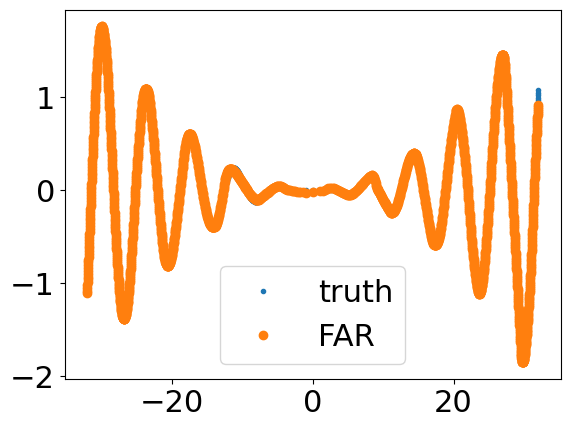

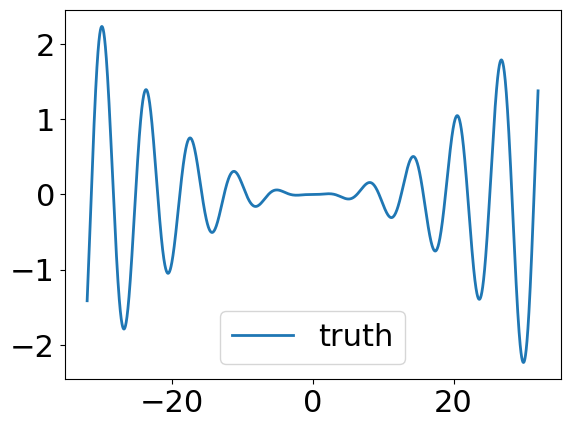

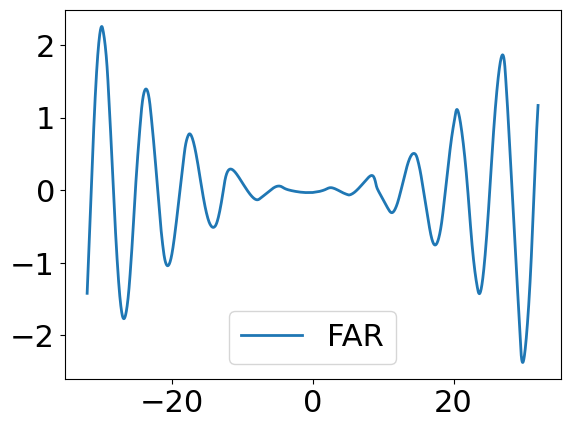

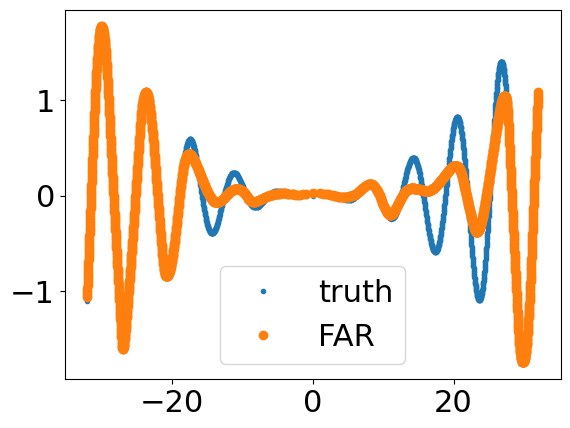

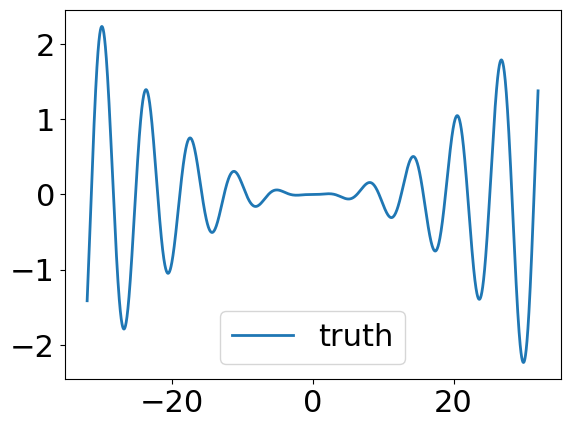

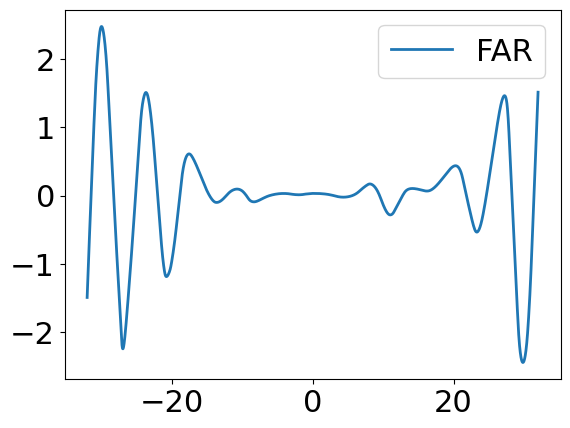

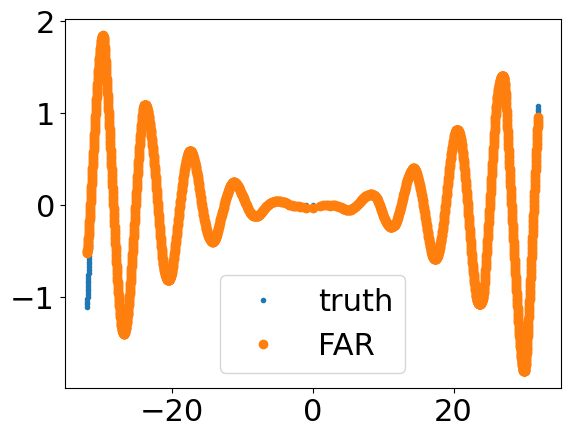

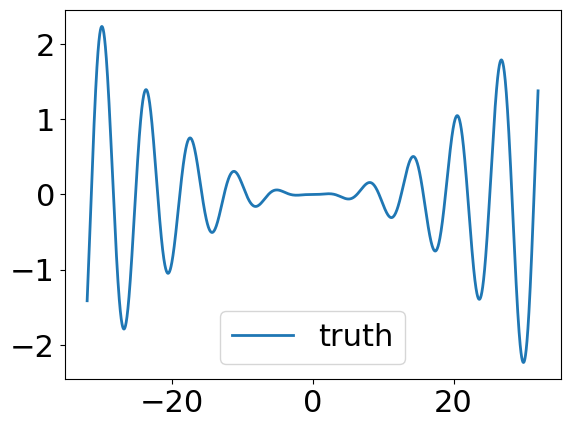

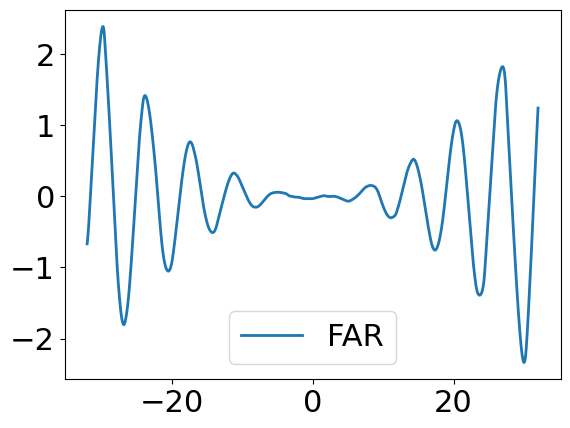

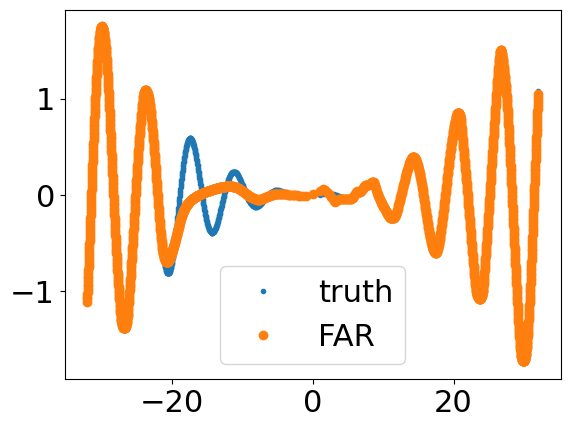

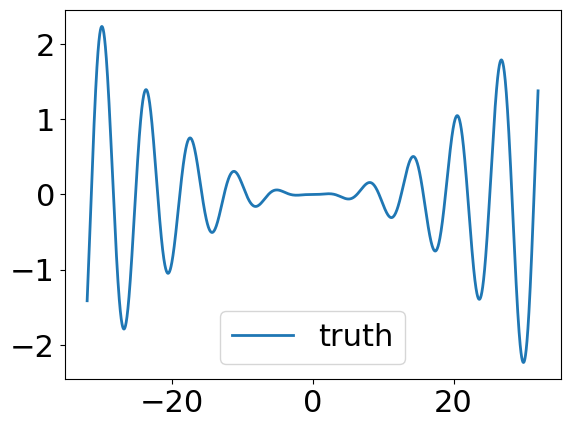

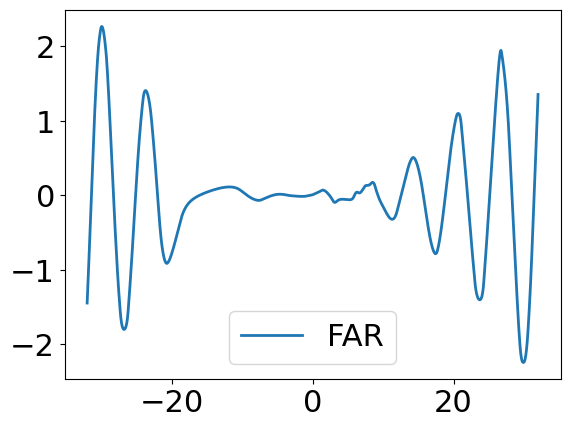

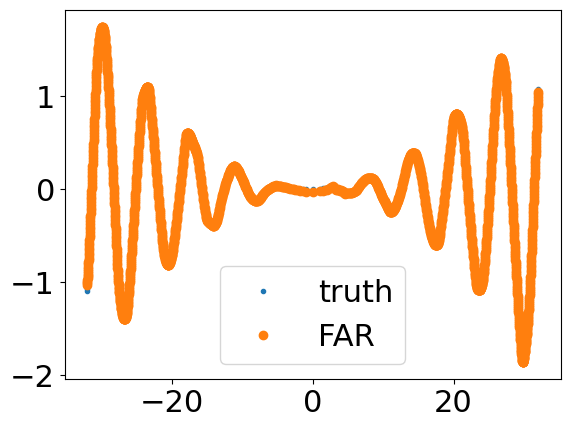

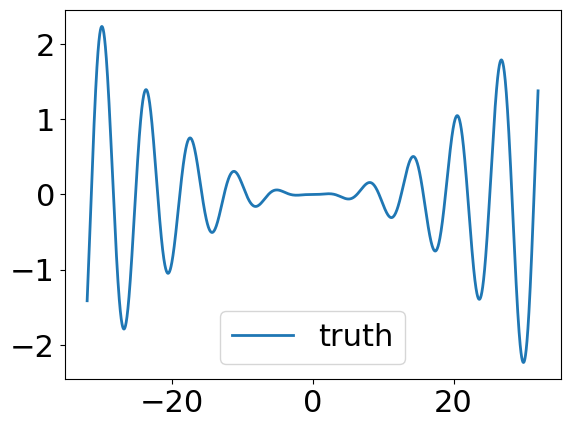

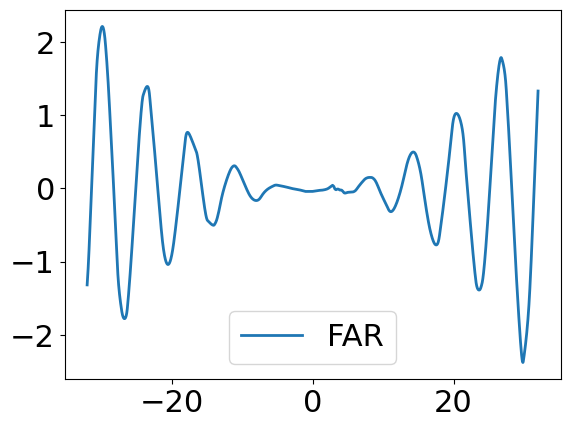

In [3]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_FAR = []

alpha = 0.5

for seed in seeds:
    set_all_seeds(seed)
    loss_FAR = FAR(alpha = alpha, version='FAR')
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
               
            loss = loss_FAR(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='FAR')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='FAR')
    plt.legend()

    preds_FAR.append(pred_Y)
    


Epoch=0, train_MAE=0.6261, train_RMSE=0.7949, train_Pearson=0.0114, train_Spearman=0.0100, lr=0.0100
test_MAE=0.6024, test_RMSE=0.7753, test_Pearson=0.1697, test_Spearman=0.0923
Epoch=1, train_MAE=0.6189, train_RMSE=0.7774, train_Pearson=0.1092, train_Spearman=0.0732, lr=0.0100
test_MAE=0.6003, test_RMSE=0.7716, test_Pearson=0.2011, test_Spearman=0.2011
Epoch=2, train_MAE=0.6243, train_RMSE=0.7861, train_Pearson=-0.0033, train_Spearman=-0.0082, lr=0.0100
test_MAE=0.6031, test_RMSE=0.7778, test_Pearson=-0.0049, test_Spearman=0.0021
Epoch=3, train_MAE=0.6207, train_RMSE=0.7823, train_Pearson=0.0221, train_Spearman=-0.0142, lr=0.0100
test_MAE=0.5996, test_RMSE=0.7720, test_Pearson=0.2211, test_Spearman=0.0988
Epoch=4, train_MAE=0.6227, train_RMSE=0.7872, train_Pearson=-0.0027, train_Spearman=-0.0352, lr=0.0100
test_MAE=0.6083, test_RMSE=0.7869, test_Pearson=-0.2113, test_Spearman=-0.1142
Epoch=5, train_MAE=0.6204, train_RMSE=0.7821, train_Pearson=0.0357, train_Spearman=0.0270, lr=0.0100
t

Epoch=46, train_MAE=0.6247, train_RMSE=0.7896, train_Pearson=0.0740, train_Spearman=0.0360, lr=0.0100
test_MAE=0.6100, test_RMSE=0.7835, test_Pearson=0.0762, test_Spearman=0.0485
Epoch=47, train_MAE=0.6220, train_RMSE=0.7845, train_Pearson=0.1021, train_Spearman=0.0027, lr=0.0100
test_MAE=0.6071, test_RMSE=0.7785, test_Pearson=0.1707, test_Spearman=-0.0266
Epoch=48, train_MAE=0.6197, train_RMSE=0.7801, train_Pearson=0.1607, train_Spearman=0.0410, lr=0.0100
test_MAE=0.6033, test_RMSE=0.7718, test_Pearson=0.2866, test_Spearman=0.1744
Epoch=49, train_MAE=0.6189, train_RMSE=0.7773, train_Pearson=0.1939, train_Spearman=0.1427, lr=0.0100
test_MAE=0.6037, test_RMSE=0.7724, test_Pearson=0.2479, test_Spearman=0.1956
Epoch=50, train_MAE=0.6192, train_RMSE=0.7775, train_Pearson=0.1968, train_Spearman=0.1243, lr=0.0100
test_MAE=0.6033, test_RMSE=0.7717, test_Pearson=0.2534, test_Spearman=0.1387
Epoch=51, train_MAE=0.6189, train_RMSE=0.7767, train_Pearson=0.2068, train_Spearman=0.1338, lr=0.0100
te

Epoch=92, train_MAE=0.6338, train_RMSE=0.7955, train_Pearson=0.1275, train_Spearman=0.0803, lr=0.0100
test_MAE=0.6219, test_RMSE=0.7935, test_Pearson=0.1747, test_Spearman=0.0072
Epoch=93, train_MAE=0.6330, train_RMSE=0.7947, train_Pearson=0.1376, train_Spearman=0.0260, lr=0.0100
test_MAE=0.6216, test_RMSE=0.7914, test_Pearson=0.1825, test_Spearman=-0.0224
Epoch=94, train_MAE=0.6321, train_RMSE=0.7894, train_Pearson=0.1920, train_Spearman=0.1287, lr=0.0100
test_MAE=0.6174, test_RMSE=0.7836, test_Pearson=0.2772, test_Spearman=0.2611
Epoch=95, train_MAE=0.6311, train_RMSE=0.7881, train_Pearson=0.1959, train_Spearman=0.1422, lr=0.0100
test_MAE=0.6170, test_RMSE=0.7829, test_Pearson=0.3020, test_Spearman=0.1998
Epoch=96, train_MAE=0.6315, train_RMSE=0.7895, train_Pearson=0.2179, train_Spearman=0.1310, lr=0.0100
test_MAE=0.6188, test_RMSE=0.7897, test_Pearson=0.2020, test_Spearman=0.0577
Epoch=97, train_MAE=0.6294, train_RMSE=0.7883, train_Pearson=0.1908, train_Spearman=0.1092, lr=0.0100
te

test_MAE=0.5845, test_RMSE=0.7477, test_Pearson=0.3105, test_Spearman=0.1247
Epoch=138, train_MAE=0.5664, train_RMSE=0.7252, train_Pearson=0.3891, train_Spearman=0.1932, lr=0.0010
test_MAE=0.5536, test_RMSE=0.7076, test_Pearson=0.4261, test_Spearman=0.1958
Epoch=139, train_MAE=0.5594, train_RMSE=0.7221, train_Pearson=0.4021, train_Spearman=0.1958, lr=0.0010
test_MAE=0.5404, test_RMSE=0.6909, test_Pearson=0.4608, test_Spearman=0.1956
Epoch=140, train_MAE=0.5543, train_RMSE=0.7036, train_Pearson=0.4365, train_Spearman=0.2761, lr=0.0010
test_MAE=0.5421, test_RMSE=0.6970, test_Pearson=0.4662, test_Spearman=0.2035
Epoch=141, train_MAE=0.5428, train_RMSE=0.7034, train_Pearson=0.4535, train_Spearman=0.2962, lr=0.0010
test_MAE=0.5420, test_RMSE=0.6904, test_Pearson=0.4627, test_Spearman=0.3238
Epoch=142, train_MAE=0.5412, train_RMSE=0.6912, train_Pearson=0.4667, train_Spearman=0.3304, lr=0.0010
test_MAE=0.5299, test_RMSE=0.6829, test_Pearson=0.4925, test_Spearman=0.2701
Epoch=143, train_MAE=0.

test_MAE=0.2092, test_RMSE=0.2845, test_Pearson=0.9308, test_Spearman=0.8579
Epoch=184, train_MAE=0.2034, train_RMSE=0.2718, train_Pearson=0.9376, train_Spearman=0.8903, lr=0.0010
test_MAE=0.2033, test_RMSE=0.2688, test_Pearson=0.9394, test_Spearman=0.8784
Epoch=185, train_MAE=0.2234, train_RMSE=0.3109, train_Pearson=0.9196, train_Spearman=0.8752, lr=0.0010
test_MAE=0.2638, test_RMSE=0.3306, test_Pearson=0.9184, test_Spearman=0.8558
Epoch=186, train_MAE=0.2387, train_RMSE=0.3151, train_Pearson=0.9168, train_Spearman=0.8693, lr=0.0010
test_MAE=0.1914, test_RMSE=0.2564, test_Pearson=0.9510, test_Spearman=0.8957
Epoch=187, train_MAE=0.2034, train_RMSE=0.2771, train_Pearson=0.9351, train_Spearman=0.8987, lr=0.0010
test_MAE=0.2155, test_RMSE=0.2738, test_Pearson=0.9376, test_Spearman=0.8905
Epoch=188, train_MAE=0.1929, train_RMSE=0.2602, train_Pearson=0.9436, train_Spearman=0.9123, lr=0.0010
test_MAE=0.2168, test_RMSE=0.2930, test_Pearson=0.9268, test_Spearman=0.8621
Epoch=189, train_MAE=0.

test_MAE=0.0786, test_RMSE=0.1573, test_Pearson=0.9794, test_Spearman=0.9375
Epoch=230, train_MAE=0.0663, train_RMSE=0.1409, train_Pearson=0.9836, train_Spearman=0.9541, lr=0.0001
test_MAE=0.0773, test_RMSE=0.1563, test_Pearson=0.9797, test_Spearman=0.9379
Epoch=231, train_MAE=0.0663, train_RMSE=0.1408, train_Pearson=0.9837, train_Spearman=0.9539, lr=0.0001
test_MAE=0.0775, test_RMSE=0.1548, test_Pearson=0.9800, test_Spearman=0.9381
Epoch=232, train_MAE=0.0675, train_RMSE=0.1403, train_Pearson=0.9838, train_Spearman=0.9544, lr=0.0001
test_MAE=0.0800, test_RMSE=0.1547, test_Pearson=0.9800, test_Spearman=0.9385
Epoch=233, train_MAE=0.0674, train_RMSE=0.1409, train_Pearson=0.9836, train_Spearman=0.9539, lr=0.0001
test_MAE=0.0781, test_RMSE=0.1554, test_Pearson=0.9799, test_Spearman=0.9382
Epoch=234, train_MAE=0.0665, train_RMSE=0.1397, train_Pearson=0.9839, train_Spearman=0.9546, lr=0.0001
test_MAE=0.0785, test_RMSE=0.1530, test_Pearson=0.9805, test_Spearman=0.9389
Epoch=235, train_MAE=0.

test_MAE=0.0655, test_RMSE=0.1346, test_Pearson=0.9849, test_Spearman=0.9539
Epoch=276, train_MAE=0.0562, train_RMSE=0.1225, train_Pearson=0.9876, train_Spearman=0.9685, lr=0.0001
test_MAE=0.0655, test_RMSE=0.1339, test_Pearson=0.9851, test_Spearman=0.9545
Epoch=277, train_MAE=0.0559, train_RMSE=0.1224, train_Pearson=0.9877, train_Spearman=0.9681, lr=0.0001
test_MAE=0.0644, test_RMSE=0.1339, test_Pearson=0.9851, test_Spearman=0.9546
Epoch=278, train_MAE=0.0560, train_RMSE=0.1223, train_Pearson=0.9877, train_Spearman=0.9687, lr=0.0001
test_MAE=0.0657, test_RMSE=0.1345, test_Pearson=0.9850, test_Spearman=0.9548
Epoch=279, train_MAE=0.0560, train_RMSE=0.1218, train_Pearson=0.9878, train_Spearman=0.9698, lr=0.0001
test_MAE=0.0629, test_RMSE=0.1324, test_Pearson=0.9854, test_Spearman=0.9568
Epoch=280, train_MAE=0.0549, train_RMSE=0.1208, train_Pearson=0.9880, train_Spearman=0.9709, lr=0.0001
test_MAE=0.0647, test_RMSE=0.1326, test_Pearson=0.9855, test_Spearman=0.9571
Epoch=281, train_MAE=0.

Epoch=21, train_MAE=0.6121, train_RMSE=0.7674, train_Pearson=0.1907, train_Spearman=0.1163, lr=0.0100
test_MAE=0.5911, test_RMSE=0.7543, test_Pearson=0.2761, test_Spearman=0.2047
Epoch=22, train_MAE=0.6137, train_RMSE=0.7680, train_Pearson=0.2147, train_Spearman=0.1233, lr=0.0100
test_MAE=0.5979, test_RMSE=0.7596, test_Pearson=0.3138, test_Spearman=0.1681
Epoch=23, train_MAE=0.6146, train_RMSE=0.7680, train_Pearson=0.2346, train_Spearman=0.1483, lr=0.0100
test_MAE=0.6006, test_RMSE=0.7662, test_Pearson=0.2732, test_Spearman=0.2223
Epoch=24, train_MAE=0.6191, train_RMSE=0.7702, train_Pearson=0.2203, train_Spearman=0.1344, lr=0.0100
test_MAE=0.5998, test_RMSE=0.7573, test_Pearson=0.2927, test_Spearman=0.2566
Epoch=25, train_MAE=0.6194, train_RMSE=0.7704, train_Pearson=0.2276, train_Spearman=0.1647, lr=0.0100
test_MAE=0.6061, test_RMSE=0.7677, test_Pearson=0.3013, test_Spearman=0.1297
Epoch=26, train_MAE=0.6213, train_RMSE=0.7713, train_Pearson=0.2165, train_Spearman=0.1089, lr=0.0100
tes

Epoch=67, train_MAE=0.6986, train_RMSE=0.8680, train_Pearson=0.2027, train_Spearman=0.1436, lr=0.0100
test_MAE=0.6892, test_RMSE=0.8494, test_Pearson=0.3302, test_Spearman=0.2116
Epoch=68, train_MAE=0.7238, train_RMSE=0.8956, train_Pearson=0.1715, train_Spearman=0.1295, lr=0.0100
test_MAE=0.7171, test_RMSE=0.8885, test_Pearson=0.2713, test_Spearman=0.1789
Epoch=69, train_MAE=0.7277, train_RMSE=0.8991, train_Pearson=0.2069, train_Spearman=0.1498, lr=0.0100
test_MAE=0.7086, test_RMSE=0.8885, test_Pearson=0.2430, test_Spearman=0.1778
Epoch=70, train_MAE=0.7198, train_RMSE=0.8911, train_Pearson=0.1907, train_Spearman=0.1336, lr=0.0100
test_MAE=0.6993, test_RMSE=0.8644, test_Pearson=0.2925, test_Spearman=0.1759
Epoch=71, train_MAE=0.7163, train_RMSE=0.8848, train_Pearson=0.2170, train_Spearman=0.1363, lr=0.0100
test_MAE=0.6949, test_RMSE=0.8509, test_Pearson=0.3152, test_Spearman=0.2048
Epoch=72, train_MAE=0.7194, train_RMSE=0.8864, train_Pearson=0.2201, train_Spearman=0.1509, lr=0.0100
tes

Epoch=113, train_MAE=0.5901, train_RMSE=0.7421, train_Pearson=0.3164, train_Spearman=0.1575, lr=0.0010
test_MAE=0.5737, test_RMSE=0.7281, test_Pearson=0.3547, test_Spearman=0.1392
Epoch=114, train_MAE=0.5840, train_RMSE=0.7373, train_Pearson=0.3335, train_Spearman=0.1603, lr=0.0010
test_MAE=0.5716, test_RMSE=0.7257, test_Pearson=0.3610, test_Spearman=0.1388
Epoch=115, train_MAE=0.5829, train_RMSE=0.7365, train_Pearson=0.3351, train_Spearman=0.1600, lr=0.0010
test_MAE=0.5706, test_RMSE=0.7248, test_Pearson=0.3661, test_Spearman=0.1264
Epoch=116, train_MAE=0.5821, train_RMSE=0.7349, train_Pearson=0.3403, train_Spearman=0.1740, lr=0.0010
test_MAE=0.5739, test_RMSE=0.7272, test_Pearson=0.3683, test_Spearman=0.1354
Epoch=117, train_MAE=0.5777, train_RMSE=0.7309, train_Pearson=0.3538, train_Spearman=0.1931, lr=0.0010
test_MAE=0.5666, test_RMSE=0.7204, test_Pearson=0.3766, test_Spearman=0.1578
Epoch=118, train_MAE=0.5734, train_RMSE=0.7288, train_Pearson=0.3610, train_Spearman=0.1724, lr=0.00

test_MAE=0.3721, test_RMSE=0.5570, test_Pearson=0.7046, test_Spearman=0.6241
Epoch=159, train_MAE=0.3420, train_RMSE=0.5259, train_Pearson=0.7420, train_Spearman=0.6838, lr=0.0010
test_MAE=0.3720, test_RMSE=0.5524, test_Pearson=0.7217, test_Spearman=0.6567
Epoch=160, train_MAE=0.3404, train_RMSE=0.5184, train_Pearson=0.7590, train_Spearman=0.7063, lr=0.0010
test_MAE=0.3432, test_RMSE=0.5251, test_Pearson=0.7412, test_Spearman=0.6569
Epoch=161, train_MAE=0.3297, train_RMSE=0.5051, train_Pearson=0.7654, train_Spearman=0.7037, lr=0.0010
test_MAE=0.3466, test_RMSE=0.5341, test_Pearson=0.7588, test_Spearman=0.6889
Epoch=162, train_MAE=0.3170, train_RMSE=0.4914, train_Pearson=0.7826, train_Spearman=0.7345, lr=0.0010
test_MAE=0.3162, test_RMSE=0.5093, test_Pearson=0.7688, test_Spearman=0.6809
Epoch=163, train_MAE=0.2975, train_RMSE=0.4802, train_Pearson=0.7939, train_Spearman=0.7362, lr=0.0010
test_MAE=0.3229, test_RMSE=0.5103, test_Pearson=0.7785, test_Spearman=0.7273
Epoch=164, train_MAE=0.

test_MAE=0.0418, test_RMSE=0.0635, test_Pearson=0.9969, test_Spearman=0.9964
Epoch=205, train_MAE=0.0394, train_RMSE=0.0627, train_Pearson=0.9969, train_Spearman=0.9967, lr=0.0001
test_MAE=0.0405, test_RMSE=0.0626, test_Pearson=0.9969, test_Spearman=0.9967
Epoch=206, train_MAE=0.0376, train_RMSE=0.0639, train_Pearson=0.9967, train_Spearman=0.9965, lr=0.0001
test_MAE=0.0386, test_RMSE=0.0613, test_Pearson=0.9969, test_Spearman=0.9964
Epoch=207, train_MAE=0.0360, train_RMSE=0.0595, train_Pearson=0.9972, train_Spearman=0.9971, lr=0.0001
test_MAE=0.0400, test_RMSE=0.0614, test_Pearson=0.9970, test_Spearman=0.9968
Epoch=208, train_MAE=0.0366, train_RMSE=0.0608, train_Pearson=0.9970, train_Spearman=0.9970, lr=0.0001
test_MAE=0.0374, test_RMSE=0.0572, test_Pearson=0.9973, test_Spearman=0.9971
Epoch=209, train_MAE=0.0356, train_RMSE=0.0581, train_Pearson=0.9973, train_Spearman=0.9973, lr=0.0001
test_MAE=0.0372, test_RMSE=0.0584, test_Pearson=0.9972, test_Spearman=0.9971
Epoch=210, train_MAE=0.

test_MAE=0.0226, test_RMSE=0.0307, test_Pearson=0.9992, test_Spearman=0.9990
Epoch=251, train_MAE=0.0209, train_RMSE=0.0308, train_Pearson=0.9992, train_Spearman=0.9992, lr=0.0001
test_MAE=0.0208, test_RMSE=0.0306, test_Pearson=0.9992, test_Spearman=0.9991
Epoch=252, train_MAE=0.0200, train_RMSE=0.0295, train_Pearson=0.9993, train_Spearman=0.9993, lr=0.0001
test_MAE=0.0215, test_RMSE=0.0308, test_Pearson=0.9992, test_Spearman=0.9990
Epoch=253, train_MAE=0.0205, train_RMSE=0.0300, train_Pearson=0.9993, train_Spearman=0.9992, lr=0.0001
test_MAE=0.0234, test_RMSE=0.0326, test_Pearson=0.9991, test_Spearman=0.9989
Epoch=254, train_MAE=0.0202, train_RMSE=0.0293, train_Pearson=0.9993, train_Spearman=0.9992, lr=0.0001
test_MAE=0.0213, test_RMSE=0.0311, test_Pearson=0.9993, test_Spearman=0.9991
Epoch=255, train_MAE=0.0208, train_RMSE=0.0301, train_Pearson=0.9993, train_Spearman=0.9992, lr=0.0001
test_MAE=0.0257, test_RMSE=0.0342, test_Pearson=0.9990, test_Spearman=0.9989
Epoch=256, train_MAE=0.

test_MAE=0.0167, test_RMSE=0.0224, test_Pearson=0.9996, test_Spearman=0.9995
Epoch=297, train_MAE=0.0153, train_RMSE=0.0206, train_Pearson=0.9997, train_Spearman=0.9996, lr=0.0001
test_MAE=0.0150, test_RMSE=0.0207, test_Pearson=0.9997, test_Spearman=0.9995
Epoch=298, train_MAE=0.0157, train_RMSE=0.0213, train_Pearson=0.9996, train_Spearman=0.9995, lr=0.0001
test_MAE=0.0169, test_RMSE=0.0217, test_Pearson=0.9996, test_Spearman=0.9995
Epoch=299, train_MAE=0.0162, train_RMSE=0.0216, train_Pearson=0.9996, train_Spearman=0.9995, lr=0.0001
test_MAE=0.0164, test_RMSE=0.0215, test_Pearson=0.9996, test_Spearman=0.9994
torch.Size([128, 1])
torch.Size([2048, 1])
Epoch=0, train_MAE=0.6936, train_RMSE=0.8758, train_Pearson=-0.0338, train_Spearman=-0.0188, lr=0.0100
test_MAE=0.6223, test_RMSE=0.7918, test_Pearson=-0.1379, test_Spearman=-0.0894
Epoch=1, train_MAE=0.6242, train_RMSE=0.7829, train_Pearson=0.0817, train_Spearman=0.0565, lr=0.0100
test_MAE=0.6095, test_RMSE=0.7809, test_Pearson=0.2569, t

Epoch=42, train_MAE=0.6752, train_RMSE=0.8468, train_Pearson=-0.2207, train_Spearman=-0.1331, lr=0.0100
test_MAE=0.6604, test_RMSE=0.8428, test_Pearson=-0.3153, test_Spearman=-0.1979
Epoch=43, train_MAE=0.6740, train_RMSE=0.8486, train_Pearson=-0.2297, train_Spearman=-0.1482, lr=0.0100
test_MAE=0.6593, test_RMSE=0.8429, test_Pearson=-0.3110, test_Spearman=-0.2152
Epoch=44, train_MAE=0.6738, train_RMSE=0.8487, train_Pearson=-0.2485, train_Spearman=-0.1676, lr=0.0100
test_MAE=0.6630, test_RMSE=0.8446, test_Pearson=-0.3060, test_Spearman=-0.2102
Epoch=45, train_MAE=0.6741, train_RMSE=0.8474, train_Pearson=-0.2428, train_Spearman=-0.1397, lr=0.0100
test_MAE=0.6648, test_RMSE=0.8512, test_Pearson=-0.2936, test_Spearman=-0.2516
Epoch=46, train_MAE=0.6734, train_RMSE=0.8485, train_Pearson=-0.2184, train_Spearman=-0.1429, lr=0.0100
test_MAE=0.6608, test_RMSE=0.8446, test_Pearson=-0.2995, test_Spearman=-0.2248
Epoch=47, train_MAE=0.6715, train_RMSE=0.8443, train_Pearson=-0.2050, train_Spearman=

Epoch=87, train_MAE=0.6313, train_RMSE=0.8061, train_Pearson=0.0495, train_Spearman=0.0556, lr=0.0100
test_MAE=0.6564, test_RMSE=0.8535, test_Pearson=-0.0787, test_Spearman=0.0525
Epoch=88, train_MAE=0.6780, train_RMSE=0.8600, train_Pearson=-0.0788, train_Spearman=0.0042, lr=0.0100
test_MAE=0.6932, test_RMSE=0.8908, test_Pearson=-0.2008, test_Spearman=-0.2042
Epoch=89, train_MAE=0.7401, train_RMSE=0.9259, train_Pearson=-0.1145, train_Spearman=-0.0861, lr=0.0100
test_MAE=0.7338, test_RMSE=0.9169, test_Pearson=-0.0557, test_Spearman=-0.0463
Epoch=90, train_MAE=0.7192, train_RMSE=0.9021, train_Pearson=-0.0148, train_Spearman=-0.0048, lr=0.0100
test_MAE=0.7301, test_RMSE=0.9116, test_Pearson=-0.0796, test_Spearman=-0.1137
Epoch=91, train_MAE=0.7503, train_RMSE=0.9281, train_Pearson=0.0073, train_Spearman=-0.0527, lr=0.0100
test_MAE=0.7703, test_RMSE=0.9156, test_Pearson=0.2213, test_Spearman=0.1467
Epoch=92, train_MAE=0.7225, train_RMSE=0.8767, train_Pearson=0.1465, train_Spearman=0.1352, 

test_MAE=0.5883, test_RMSE=0.7533, test_Pearson=0.2635, test_Spearman=0.2346
Epoch=133, train_MAE=0.6116, train_RMSE=0.7693, train_Pearson=0.1859, train_Spearman=0.1543, lr=0.0010
test_MAE=0.5870, test_RMSE=0.7514, test_Pearson=0.2633, test_Spearman=0.2196
Epoch=134, train_MAE=0.6127, train_RMSE=0.7728, train_Pearson=0.1784, train_Spearman=0.1377, lr=0.0010
test_MAE=0.5920, test_RMSE=0.7516, test_Pearson=0.2662, test_Spearman=0.2309
Epoch=135, train_MAE=0.6141, train_RMSE=0.7710, train_Pearson=0.1693, train_Spearman=0.1083, lr=0.0010
test_MAE=0.5878, test_RMSE=0.7523, test_Pearson=0.2701, test_Spearman=0.2274
Epoch=136, train_MAE=0.6114, train_RMSE=0.7671, train_Pearson=0.1951, train_Spearman=0.1532, lr=0.0010
test_MAE=0.5871, test_RMSE=0.7515, test_Pearson=0.2770, test_Spearman=0.2243
Epoch=137, train_MAE=0.6115, train_RMSE=0.7671, train_Pearson=0.1937, train_Spearman=0.1179, lr=0.0010
test_MAE=0.5895, test_RMSE=0.7495, test_Pearson=0.2725, test_Spearman=0.2232
Epoch=138, train_MAE=0.

test_MAE=0.5719, test_RMSE=0.7218, test_Pearson=0.4036, test_Spearman=0.2856
Epoch=179, train_MAE=0.6019, train_RMSE=0.7650, train_Pearson=0.2931, train_Spearman=0.2036, lr=0.0010
test_MAE=0.5826, test_RMSE=0.7382, test_Pearson=0.3922, test_Spearman=0.2229
Epoch=180, train_MAE=0.5894, train_RMSE=0.7333, train_Pearson=0.3493, train_Spearman=0.3132, lr=0.0010
test_MAE=0.5628, test_RMSE=0.7173, test_Pearson=0.4020, test_Spearman=0.2464
Epoch=181, train_MAE=0.5817, train_RMSE=0.7347, train_Pearson=0.3558, train_Spearman=0.3189, lr=0.0010
test_MAE=0.5622, test_RMSE=0.7101, test_Pearson=0.4300, test_Spearman=0.2245
Epoch=182, train_MAE=0.5847, train_RMSE=0.7419, train_Pearson=0.3305, train_Spearman=0.2354, lr=0.0010
test_MAE=0.5583, test_RMSE=0.7053, test_Pearson=0.4262, test_Spearman=0.3696
Epoch=183, train_MAE=0.5842, train_RMSE=0.7373, train_Pearson=0.3490, train_Spearman=0.2625, lr=0.0010
test_MAE=0.5549, test_RMSE=0.7032, test_Pearson=0.4364, test_Spearman=0.3793
Epoch=184, train_MAE=0.

test_MAE=0.4429, test_RMSE=0.6001, test_Pearson=0.6357, test_Spearman=0.5305
Epoch=225, train_MAE=0.4392, train_RMSE=0.6013, train_Pearson=0.6393, train_Spearman=0.5549, lr=0.0001
test_MAE=0.4464, test_RMSE=0.6013, test_Pearson=0.6339, test_Spearman=0.5176
Epoch=226, train_MAE=0.4384, train_RMSE=0.6012, train_Pearson=0.6391, train_Spearman=0.5517, lr=0.0001
test_MAE=0.4428, test_RMSE=0.6017, test_Pearson=0.6333, test_Spearman=0.5164
Epoch=227, train_MAE=0.4367, train_RMSE=0.6011, train_Pearson=0.6392, train_Spearman=0.5504, lr=0.0001
test_MAE=0.4461, test_RMSE=0.6038, test_Pearson=0.6303, test_Spearman=0.5060
Epoch=228, train_MAE=0.4396, train_RMSE=0.6019, train_Pearson=0.6381, train_Spearman=0.5521, lr=0.0001
test_MAE=0.4445, test_RMSE=0.6022, test_Pearson=0.6325, test_Spearman=0.5177
Epoch=229, train_MAE=0.4345, train_RMSE=0.5997, train_Pearson=0.6413, train_Spearman=0.5550, lr=0.0001
test_MAE=0.4437, test_RMSE=0.6021, test_Pearson=0.6327, test_Spearman=0.5107
Epoch=230, train_MAE=0.

test_MAE=0.4099, test_RMSE=0.5708, test_Pearson=0.6790, test_Spearman=0.5956
Epoch=271, train_MAE=0.4034, train_RMSE=0.5714, train_Pearson=0.6825, train_Spearman=0.6231, lr=0.0001
test_MAE=0.4105, test_RMSE=0.5725, test_Pearson=0.6767, test_Spearman=0.5857
Epoch=272, train_MAE=0.4027, train_RMSE=0.5716, train_Pearson=0.6825, train_Spearman=0.6212, lr=0.0001
test_MAE=0.4093, test_RMSE=0.5692, test_Pearson=0.6822, test_Spearman=0.5980
Epoch=273, train_MAE=0.4034, train_RMSE=0.5696, train_Pearson=0.6866, train_Spearman=0.6304, lr=0.0001
test_MAE=0.4097, test_RMSE=0.5683, test_Pearson=0.6829, test_Spearman=0.5986
Epoch=274, train_MAE=0.4024, train_RMSE=0.5690, train_Pearson=0.6864, train_Spearman=0.6285, lr=0.0001
test_MAE=0.4067, test_RMSE=0.5677, test_Pearson=0.6850, test_Spearman=0.6018
Epoch=275, train_MAE=0.4026, train_RMSE=0.5692, train_Pearson=0.6861, train_Spearman=0.6264, lr=0.0001
test_MAE=0.4067, test_RMSE=0.5681, test_Pearson=0.6829, test_Spearman=0.5926
Epoch=276, train_MAE=0.

Epoch=16, train_MAE=0.8390, train_RMSE=1.0428, train_Pearson=-0.0245, train_Spearman=-0.0005, lr=0.0100
test_MAE=0.8124, test_RMSE=1.0047, test_Pearson=-0.2305, test_Spearman=-0.0721
Epoch=17, train_MAE=0.8058, train_RMSE=1.0021, train_Pearson=-0.1214, train_Spearman=-0.0373, lr=0.0100
test_MAE=0.8136, test_RMSE=1.0146, test_Pearson=-0.1086, test_Spearman=-0.0328
Epoch=18, train_MAE=0.8705, train_RMSE=1.0730, train_Pearson=-0.0340, train_Spearman=-0.0016, lr=0.0100
test_MAE=0.9602, test_RMSE=1.1589, test_Pearson=0.0031, test_Spearman=0.0131
Epoch=19, train_MAE=0.9269, train_RMSE=1.1335, train_Pearson=-0.0050, train_Spearman=0.0051, lr=0.0100
test_MAE=0.8514, test_RMSE=1.0511, test_Pearson=-0.0850, test_Spearman=-0.0593
Epoch=20, train_MAE=0.8308, train_RMSE=1.0332, train_Pearson=-0.0416, train_Spearman=-0.0039, lr=0.0100
test_MAE=0.8172, test_RMSE=1.0193, test_Pearson=-0.1236, test_Spearman=-0.1002
Epoch=21, train_MAE=0.8102, train_RMSE=1.0095, train_Pearson=-0.0521, train_Spearman=0.0

test_MAE=0.5921, test_RMSE=0.7601, test_Pearson=0.2101, test_Spearman=0.1174
Epoch=62, train_MAE=0.6167, train_RMSE=0.7725, train_Pearson=0.2132, train_Spearman=0.1434, lr=0.0100
test_MAE=0.5981, test_RMSE=0.7571, test_Pearson=0.3021, test_Spearman=0.1695
Epoch=63, train_MAE=0.6177, train_RMSE=0.7769, train_Pearson=0.1304, train_Spearman=0.0621, lr=0.0100
test_MAE=0.6182, test_RMSE=0.7811, test_Pearson=0.1181, test_Spearman=0.1465
Epoch=64, train_MAE=0.6329, train_RMSE=0.7820, train_Pearson=0.1403, train_Spearman=-0.0446, lr=0.0100
test_MAE=0.6088, test_RMSE=0.7714, test_Pearson=0.1816, test_Spearman=0.0570
Epoch=65, train_MAE=0.6241, train_RMSE=0.7766, train_Pearson=0.1356, train_Spearman=-0.0101, lr=0.0100
test_MAE=0.5935, test_RMSE=0.7598, test_Pearson=0.2134, test_Spearman=-0.0500
Epoch=66, train_MAE=0.6251, train_RMSE=0.7783, train_Pearson=0.1725, train_Spearman=0.0849, lr=0.0100
test_MAE=0.6184, test_RMSE=0.7983, test_Pearson=0.0473, test_Spearman=0.0688
Epoch=67, train_MAE=0.621

test_MAE=0.5798, test_RMSE=0.7415, test_Pearson=0.3006, test_Spearman=0.1865
Epoch=108, train_MAE=0.6136, train_RMSE=0.7687, train_Pearson=0.2035, train_Spearman=0.1228, lr=0.0010
test_MAE=0.5924, test_RMSE=0.7539, test_Pearson=0.2968, test_Spearman=0.1841
Epoch=109, train_MAE=0.6073, train_RMSE=0.7618, train_Pearson=0.2303, train_Spearman=0.1443, lr=0.0010
test_MAE=0.5792, test_RMSE=0.7403, test_Pearson=0.3063, test_Spearman=0.1763
Epoch=110, train_MAE=0.6047, train_RMSE=0.7617, train_Pearson=0.2382, train_Spearman=0.1596, lr=0.0010
test_MAE=0.5788, test_RMSE=0.7402, test_Pearson=0.3080, test_Spearman=0.1784
Epoch=111, train_MAE=0.6048, train_RMSE=0.7657, train_Pearson=0.2431, train_Spearman=0.1538, lr=0.0010
test_MAE=0.5794, test_RMSE=0.7391, test_Pearson=0.3133, test_Spearman=0.1707
Epoch=112, train_MAE=0.6071, train_RMSE=0.7608, train_Pearson=0.2438, train_Spearman=0.1414, lr=0.0010
test_MAE=0.5878, test_RMSE=0.7486, test_Pearson=0.3094, test_Spearman=0.1675
Epoch=113, train_MAE=0.

test_MAE=0.5606, test_RMSE=0.7083, test_Pearson=0.4166, test_Spearman=0.2433
Epoch=154, train_MAE=0.5873, train_RMSE=0.7381, train_Pearson=0.3368, train_Spearman=0.1771, lr=0.0010
test_MAE=0.5653, test_RMSE=0.7145, test_Pearson=0.3958, test_Spearman=0.1961
Epoch=155, train_MAE=0.5842, train_RMSE=0.7327, train_Pearson=0.3541, train_Spearman=0.2073, lr=0.0010
test_MAE=0.5600, test_RMSE=0.7070, test_Pearson=0.4296, test_Spearman=0.2362
Epoch=156, train_MAE=0.5825, train_RMSE=0.7377, train_Pearson=0.3416, train_Spearman=0.1853, lr=0.0010
test_MAE=0.5603, test_RMSE=0.7069, test_Pearson=0.4284, test_Spearman=0.2582
Epoch=157, train_MAE=0.5790, train_RMSE=0.7274, train_Pearson=0.3679, train_Spearman=0.2160, lr=0.0010
test_MAE=0.5615, test_RMSE=0.7071, test_Pearson=0.4315, test_Spearman=0.2407
Epoch=158, train_MAE=0.5793, train_RMSE=0.7289, train_Pearson=0.3676, train_Spearman=0.2145, lr=0.0010
test_MAE=0.5621, test_RMSE=0.7083, test_Pearson=0.4253, test_Spearman=0.2558
Epoch=159, train_MAE=0.

test_MAE=0.4580, test_RMSE=0.6054, test_Pearson=0.6304, test_Spearman=0.3860
Epoch=200, train_MAE=0.4700, train_RMSE=0.6256, train_Pearson=0.5998, train_Spearman=0.3542, lr=0.0001
test_MAE=0.4435, test_RMSE=0.5991, test_Pearson=0.6378, test_Spearman=0.4001
Epoch=201, train_MAE=0.4590, train_RMSE=0.6222, train_Pearson=0.6064, train_Spearman=0.3668, lr=0.0001
test_MAE=0.4268, test_RMSE=0.5937, test_Pearson=0.6458, test_Spearman=0.4076
Epoch=202, train_MAE=0.4559, train_RMSE=0.6215, train_Pearson=0.6070, train_Spearman=0.3730, lr=0.0001
test_MAE=0.4267, test_RMSE=0.5937, test_Pearson=0.6464, test_Spearman=0.4113
Epoch=203, train_MAE=0.4530, train_RMSE=0.6215, train_Pearson=0.6086, train_Spearman=0.3763, lr=0.0001
test_MAE=0.4304, test_RMSE=0.5939, test_Pearson=0.6454, test_Spearman=0.4113
Epoch=204, train_MAE=0.4534, train_RMSE=0.6207, train_Pearson=0.6087, train_Spearman=0.3786, lr=0.0001
test_MAE=0.4269, test_RMSE=0.5933, test_Pearson=0.6466, test_Spearman=0.4143
Epoch=205, train_MAE=0.

test_MAE=0.4194, test_RMSE=0.5901, test_Pearson=0.6517, test_Spearman=0.4338
Epoch=246, train_MAE=0.4439, train_RMSE=0.6178, train_Pearson=0.6145, train_Spearman=0.3966, lr=0.0001
test_MAE=0.4193, test_RMSE=0.5897, test_Pearson=0.6518, test_Spearman=0.4354
Epoch=247, train_MAE=0.4443, train_RMSE=0.6174, train_Pearson=0.6143, train_Spearman=0.3986, lr=0.0001
test_MAE=0.4189, test_RMSE=0.5895, test_Pearson=0.6524, test_Spearman=0.4378
Epoch=248, train_MAE=0.4454, train_RMSE=0.6183, train_Pearson=0.6138, train_Spearman=0.3968, lr=0.0001
test_MAE=0.4223, test_RMSE=0.5906, test_Pearson=0.6511, test_Spearman=0.4360
Epoch=249, train_MAE=0.4450, train_RMSE=0.6177, train_Pearson=0.6142, train_Spearman=0.3952, lr=0.0001
test_MAE=0.4229, test_RMSE=0.5904, test_Pearson=0.6513, test_Spearman=0.4352
Epoch=250, train_MAE=0.4445, train_RMSE=0.6174, train_Pearson=0.6146, train_Spearman=0.3975, lr=0.0001
test_MAE=0.4188, test_RMSE=0.5894, test_Pearson=0.6523, test_Spearman=0.4353
Epoch=251, train_MAE=0.

test_MAE=0.4156, test_RMSE=0.5873, test_Pearson=0.6554, test_Spearman=0.4373
Epoch=292, train_MAE=0.4402, train_RMSE=0.6152, train_Pearson=0.6177, train_Spearman=0.3973, lr=0.0001
test_MAE=0.4151, test_RMSE=0.5875, test_Pearson=0.6557, test_Spearman=0.4361
Epoch=293, train_MAE=0.4401, train_RMSE=0.6155, train_Pearson=0.6177, train_Spearman=0.3967, lr=0.0001
test_MAE=0.4159, test_RMSE=0.5873, test_Pearson=0.6553, test_Spearman=0.4347
Epoch=294, train_MAE=0.4385, train_RMSE=0.6153, train_Pearson=0.6180, train_Spearman=0.3979, lr=0.0001
test_MAE=0.4142, test_RMSE=0.5873, test_Pearson=0.6558, test_Spearman=0.4359
Epoch=295, train_MAE=0.4383, train_RMSE=0.6154, train_Pearson=0.6181, train_Spearman=0.3981, lr=0.0001
test_MAE=0.4148, test_RMSE=0.5872, test_Pearson=0.6556, test_Spearman=0.4347
Epoch=296, train_MAE=0.4382, train_RMSE=0.6151, train_Pearson=0.6184, train_Spearman=0.3952, lr=0.0001
test_MAE=0.4140, test_RMSE=0.5871, test_Pearson=0.6558, test_Spearman=0.4350
Epoch=297, train_MAE=0.

test_MAE=0.7661, test_RMSE=0.9489, test_Pearson=-0.1391, test_Spearman=-0.0251
Epoch=37, train_MAE=0.7713, train_RMSE=0.9511, train_Pearson=-0.0765, train_Spearman=-0.0501, lr=0.0100
test_MAE=0.7698, test_RMSE=0.9560, test_Pearson=-0.2011, test_Spearman=-0.0131
Epoch=38, train_MAE=0.7655, train_RMSE=0.9402, train_Pearson=-0.0774, train_Spearman=-0.0633, lr=0.0100
test_MAE=0.7510, test_RMSE=0.9219, test_Pearson=-0.2992, test_Spearman=-0.1847
Epoch=39, train_MAE=0.7600, train_RMSE=0.9290, train_Pearson=0.0139, train_Spearman=-0.0450, lr=0.0100
test_MAE=0.7156, test_RMSE=0.8669, test_Pearson=0.0840, test_Spearman=0.0172
Epoch=40, train_MAE=0.7224, train_RMSE=0.8752, train_Pearson=0.0312, train_Spearman=-0.0075, lr=0.0100
test_MAE=0.6694, test_RMSE=0.8312, test_Pearson=0.1882, test_Spearman=0.0642
Epoch=41, train_MAE=0.6719, train_RMSE=0.8283, train_Pearson=0.1322, train_Spearman=0.0962, lr=0.0100
test_MAE=0.6428, test_RMSE=0.8052, test_Pearson=0.2383, test_Spearman=0.2056
Epoch=42, train_

test_MAE=0.6518, test_RMSE=0.8132, test_Pearson=0.1636, test_Spearman=-0.0355
Epoch=83, train_MAE=0.6713, train_RMSE=0.8247, train_Pearson=0.1584, train_Spearman=0.0195, lr=0.0100
test_MAE=0.6480, test_RMSE=0.8073, test_Pearson=0.2010, test_Spearman=0.1667
Epoch=84, train_MAE=0.6716, train_RMSE=0.8223, train_Pearson=0.1509, train_Spearman=0.0163, lr=0.0100
test_MAE=0.6546, test_RMSE=0.8143, test_Pearson=0.1368, test_Spearman=0.0268
Epoch=85, train_MAE=0.6719, train_RMSE=0.8207, train_Pearson=0.1190, train_Spearman=0.0500, lr=0.0100
test_MAE=0.6579, test_RMSE=0.8202, test_Pearson=0.1786, test_Spearman=-0.0922
Epoch=86, train_MAE=0.6781, train_RMSE=0.8319, train_Pearson=0.1526, train_Spearman=0.0381, lr=0.0100
test_MAE=0.6598, test_RMSE=0.8242, test_Pearson=0.1996, test_Spearman=0.1260
Epoch=87, train_MAE=0.6810, train_RMSE=0.8367, train_Pearson=0.1113, train_Spearman=0.0088, lr=0.0100
test_MAE=0.6644, test_RMSE=0.8280, test_Pearson=0.0848, test_Spearman=-0.1128
Epoch=88, train_MAE=0.684

Epoch=128, train_MAE=0.5430, train_RMSE=0.6984, train_Pearson=0.4618, train_Spearman=0.3419, lr=0.0010
test_MAE=0.5276, test_RMSE=0.6666, test_Pearson=0.5262, test_Spearman=0.4704
Epoch=129, train_MAE=0.5252, train_RMSE=0.6737, train_Pearson=0.5068, train_Spearman=0.4399, lr=0.0010
test_MAE=0.5198, test_RMSE=0.6626, test_Pearson=0.5253, test_Spearman=0.4242
Epoch=130, train_MAE=0.5174, train_RMSE=0.6605, train_Pearson=0.5356, train_Spearman=0.4705, lr=0.0010
test_MAE=0.5143, test_RMSE=0.6601, test_Pearson=0.5357, test_Spearman=0.4159
Epoch=131, train_MAE=0.5015, train_RMSE=0.6465, train_Pearson=0.5621, train_Spearman=0.5059, lr=0.0010
test_MAE=0.5045, test_RMSE=0.6396, test_Pearson=0.5701, test_Spearman=0.4717
Epoch=132, train_MAE=0.4821, train_RMSE=0.6322, train_Pearson=0.5895, train_Spearman=0.5327, lr=0.0010
test_MAE=0.4636, test_RMSE=0.6203, test_Pearson=0.6117, test_Spearman=0.5059
Epoch=133, train_MAE=0.4744, train_RMSE=0.6302, train_Pearson=0.5963, train_Spearman=0.5229, lr=0.00

test_MAE=0.1512, test_RMSE=0.2156, test_Pearson=0.9608, test_Spearman=0.9028
Epoch=174, train_MAE=0.1533, train_RMSE=0.2070, train_Pearson=0.9644, train_Spearman=0.9274, lr=0.0010
test_MAE=0.1694, test_RMSE=0.2126, test_Pearson=0.9622, test_Spearman=0.9179
Epoch=175, train_MAE=0.1449, train_RMSE=0.1987, train_Pearson=0.9671, train_Spearman=0.9346, lr=0.0010
test_MAE=0.1811, test_RMSE=0.2234, test_Pearson=0.9582, test_Spearman=0.9190
Epoch=176, train_MAE=0.1421, train_RMSE=0.1930, train_Pearson=0.9690, train_Spearman=0.9408, lr=0.0010
test_MAE=0.1486, test_RMSE=0.1927, test_Pearson=0.9689, test_Spearman=0.9264
Epoch=177, train_MAE=0.1492, train_RMSE=0.2054, train_Pearson=0.9649, train_Spearman=0.9351, lr=0.0010
test_MAE=0.1508, test_RMSE=0.1966, test_Pearson=0.9683, test_Spearman=0.9322
Epoch=178, train_MAE=0.1506, train_RMSE=0.1978, train_Pearson=0.9675, train_Spearman=0.9429, lr=0.0010
test_MAE=0.1474, test_RMSE=0.2010, test_Pearson=0.9693, test_Spearman=0.9254
Epoch=179, train_MAE=0.

test_MAE=0.0686, test_RMSE=0.1257, test_Pearson=0.9868, test_Spearman=0.9618
Epoch=220, train_MAE=0.0629, train_RMSE=0.1193, train_Pearson=0.9883, train_Spearman=0.9703, lr=0.0001
test_MAE=0.0680, test_RMSE=0.1255, test_Pearson=0.9869, test_Spearman=0.9617
Epoch=221, train_MAE=0.0627, train_RMSE=0.1190, train_Pearson=0.9884, train_Spearman=0.9703, lr=0.0001
test_MAE=0.0696, test_RMSE=0.1254, test_Pearson=0.9869, test_Spearman=0.9618
Epoch=222, train_MAE=0.0633, train_RMSE=0.1191, train_Pearson=0.9883, train_Spearman=0.9704, lr=0.0001
test_MAE=0.0689, test_RMSE=0.1255, test_Pearson=0.9869, test_Spearman=0.9616
Epoch=223, train_MAE=0.0625, train_RMSE=0.1187, train_Pearson=0.9884, train_Spearman=0.9703, lr=0.0001
test_MAE=0.0681, test_RMSE=0.1249, test_Pearson=0.9870, test_Spearman=0.9621
Epoch=224, train_MAE=0.0623, train_RMSE=0.1189, train_Pearson=0.9884, train_Spearman=0.9702, lr=0.0001
test_MAE=0.0684, test_RMSE=0.1252, test_Pearson=0.9870, test_Spearman=0.9615
Epoch=225, train_MAE=0.

test_MAE=0.0647, test_RMSE=0.1210, test_Pearson=0.9878, test_Spearman=0.9639
Epoch=266, train_MAE=0.0581, train_RMSE=0.1150, train_Pearson=0.9891, train_Spearman=0.9712, lr=0.0001
test_MAE=0.0641, test_RMSE=0.1212, test_Pearson=0.9878, test_Spearman=0.9637
Epoch=267, train_MAE=0.0583, train_RMSE=0.1152, train_Pearson=0.9891, train_Spearman=0.9712, lr=0.0001
test_MAE=0.0635, test_RMSE=0.1205, test_Pearson=0.9879, test_Spearman=0.9642
Epoch=268, train_MAE=0.0578, train_RMSE=0.1150, train_Pearson=0.9891, train_Spearman=0.9712, lr=0.0001
test_MAE=0.0636, test_RMSE=0.1210, test_Pearson=0.9878, test_Spearman=0.9640
Epoch=269, train_MAE=0.0573, train_RMSE=0.1147, train_Pearson=0.9892, train_Spearman=0.9713, lr=0.0001
test_MAE=0.0625, test_RMSE=0.1201, test_Pearson=0.9880, test_Spearman=0.9645
Epoch=270, train_MAE=0.0568, train_RMSE=0.1145, train_Pearson=0.9892, train_Spearman=0.9713, lr=0.0001
test_MAE=0.0619, test_RMSE=0.1201, test_Pearson=0.9880, test_Spearman=0.9644
Epoch=271, train_MAE=0.

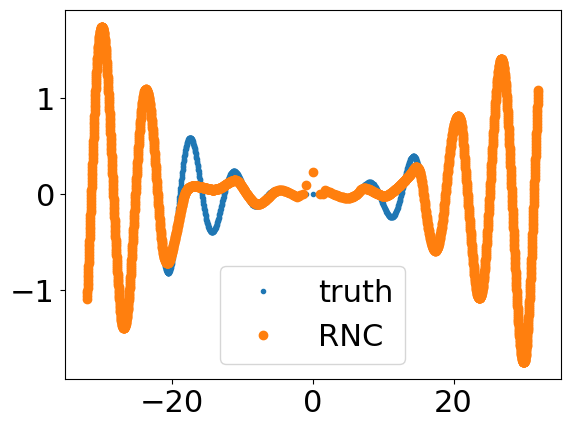

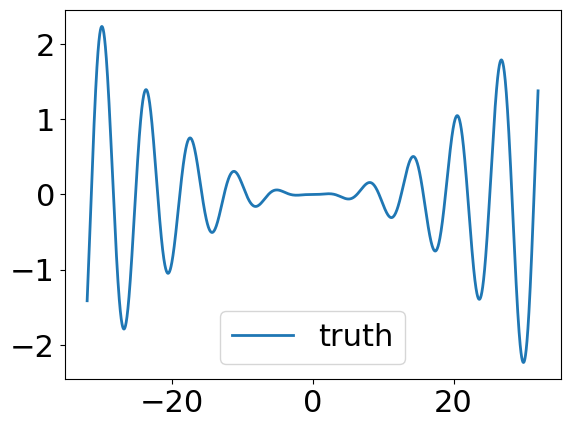

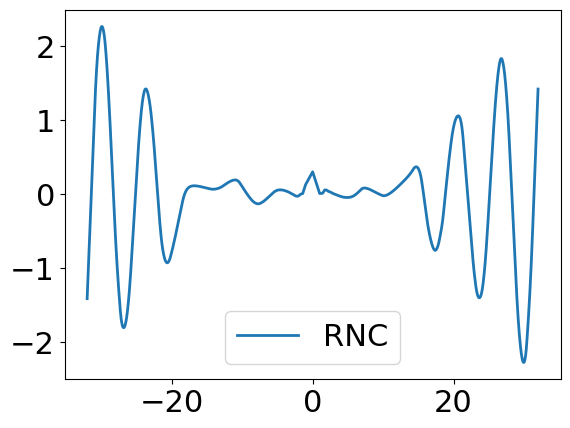

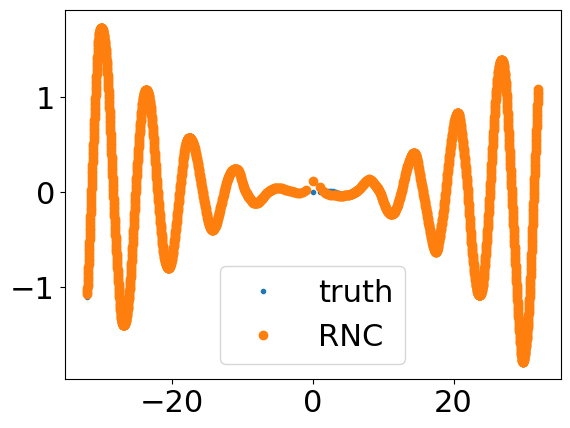

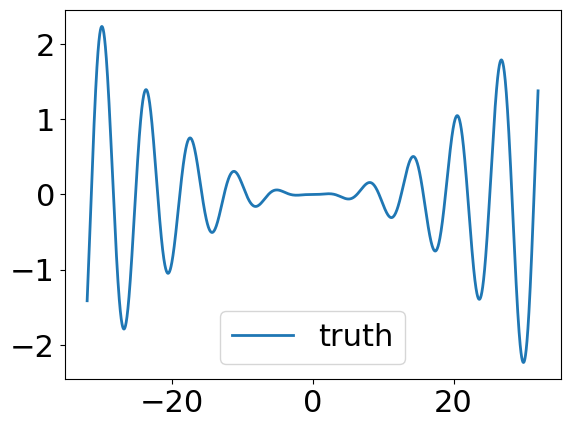

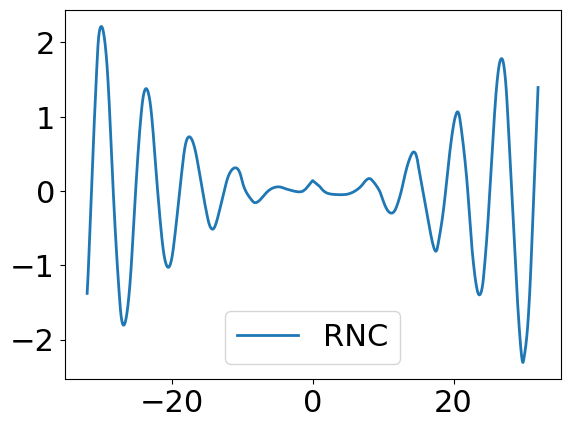

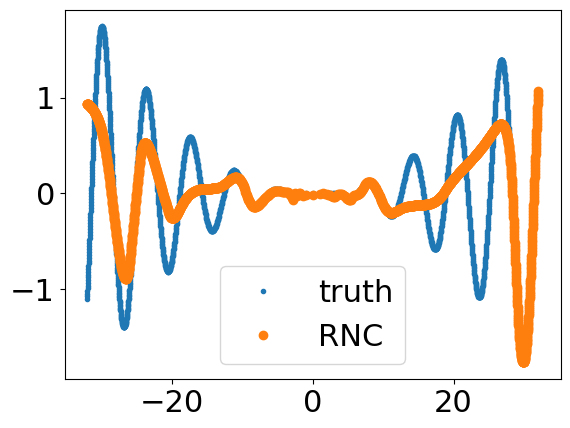

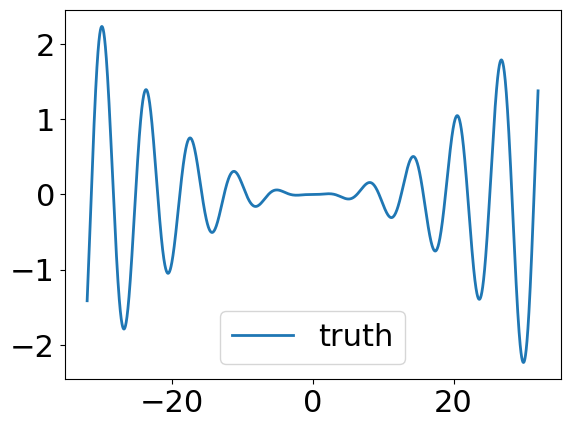

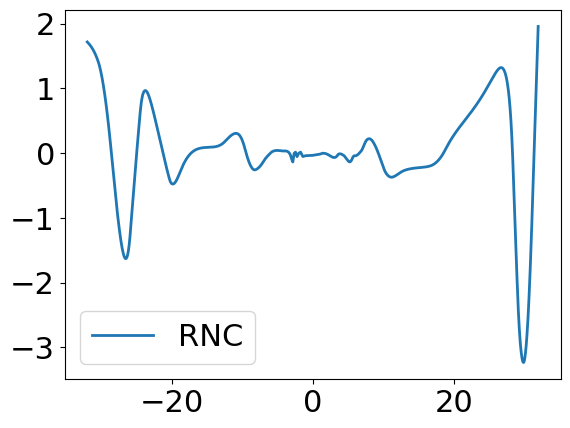

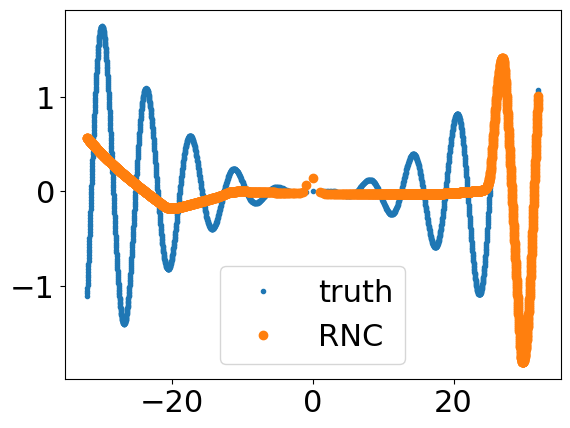

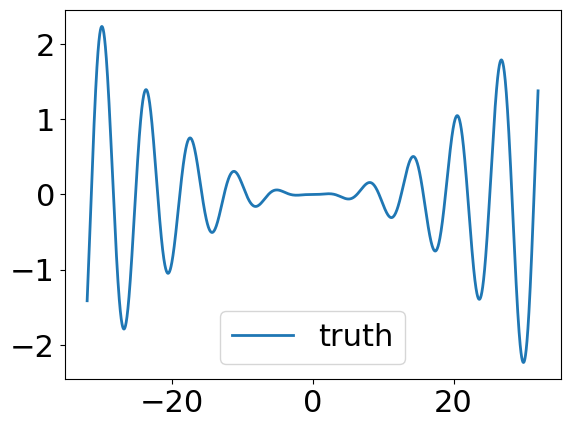

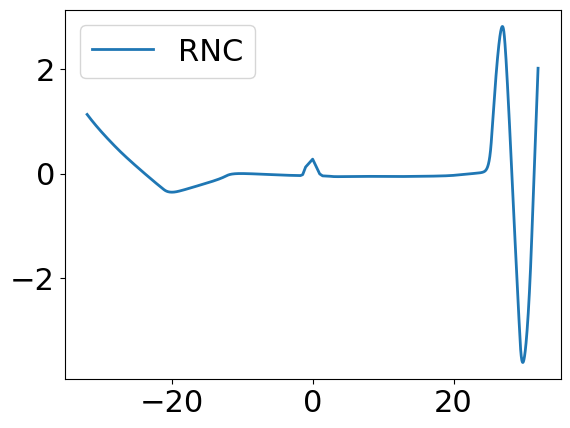

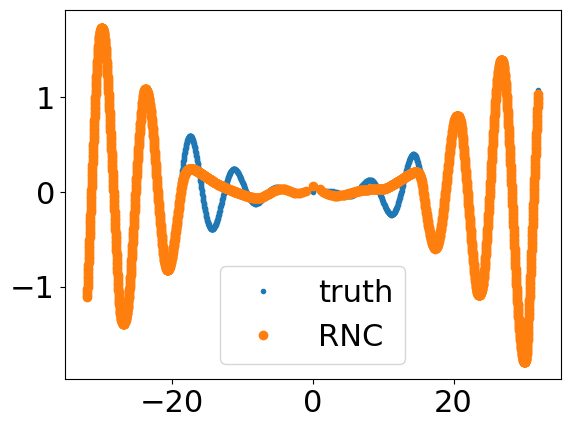

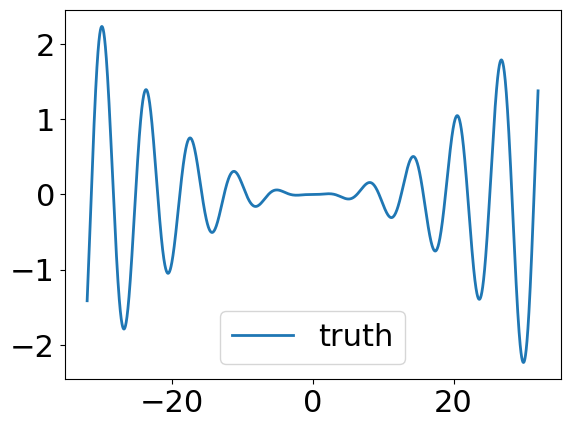

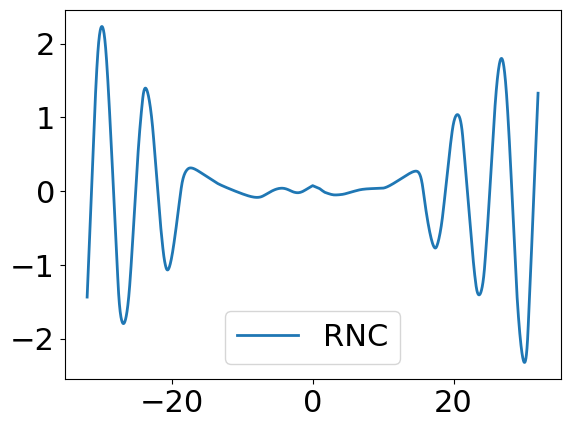

In [4]:
lr = 0.01
decay = 0


seeds = [1,2,3,4,5]
preds_RNC = []

for seed in seeds:
    set_all_seeds(seed)
    RNC = RnCLoss(temperature=4)
    basic_loss = torch.nn.L1Loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, feat = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            if epoch < 100:
                loss = RNC(feat, tr_Y)
            else:
                loss = basic_loss(pred_Y, tr_Y)
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, feat = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, feat = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='RNC')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='RNC')
    plt.legend()

    preds_RNC.append(pred_Y)
    


Epoch=0, train_MAE=1.3842, train_RMSE=1.7766, train_Pearson=-0.0080, train_Spearman=-0.0013, lr=0.0100
test_MAE=1.0070, test_RMSE=1.2631, test_Pearson=-0.1611, test_Spearman=-0.1180
Epoch=1, train_MAE=0.7151, train_RMSE=0.9084, train_Pearson=0.0297, train_Spearman=0.0245, lr=0.0100
test_MAE=0.6188, test_RMSE=0.7879, test_Pearson=0.1853, test_Spearman=0.1624
Epoch=2, train_MAE=0.6576, train_RMSE=0.8384, train_Pearson=0.1355, train_Spearman=0.1019, lr=0.0100
test_MAE=0.5929, test_RMSE=0.7608, test_Pearson=0.2122, test_Spearman=0.2012
Epoch=3, train_MAE=0.6330, train_RMSE=0.7961, train_Pearson=0.0334, train_Spearman=0.0196, lr=0.0100
test_MAE=0.5974, test_RMSE=0.7749, test_Pearson=0.2059, test_Spearman=0.1966
Epoch=4, train_MAE=0.6430, train_RMSE=0.8044, train_Pearson=0.0897, train_Spearman=0.0562, lr=0.0100
test_MAE=0.6186, test_RMSE=0.8108, test_Pearson=0.2112, test_Spearman=0.1960
Epoch=5, train_MAE=0.6401, train_RMSE=0.7952, train_Pearson=0.0944, train_Spearman=0.0552, lr=0.0100
test_

Epoch=46, train_MAE=0.6317, train_RMSE=0.8068, train_Pearson=0.1397, train_Spearman=0.0952, lr=0.0100
test_MAE=0.5973, test_RMSE=0.7642, test_Pearson=0.2324, test_Spearman=0.0540
Epoch=47, train_MAE=0.6198, train_RMSE=0.7756, train_Pearson=0.1296, train_Spearman=0.0970, lr=0.0100
test_MAE=0.6087, test_RMSE=0.7779, test_Pearson=0.2569, test_Spearman=0.2090
Epoch=48, train_MAE=0.6185, train_RMSE=0.7802, train_Pearson=0.0645, train_Spearman=0.0610, lr=0.0100
test_MAE=0.6011, test_RMSE=0.7651, test_Pearson=0.2769, test_Spearman=0.1996
Epoch=49, train_MAE=0.6205, train_RMSE=0.7774, train_Pearson=0.1027, train_Spearman=0.0628, lr=0.0100
test_MAE=0.5942, test_RMSE=0.7515, test_Pearson=0.2786, test_Spearman=0.2221
Epoch=50, train_MAE=0.6280, train_RMSE=0.8015, train_Pearson=0.1251, train_Spearman=0.1034, lr=0.0100
test_MAE=0.5925, test_RMSE=0.7550, test_Pearson=0.2731, test_Spearman=0.2011
Epoch=51, train_MAE=0.6191, train_RMSE=0.7732, train_Pearson=0.1631, train_Spearman=0.1071, lr=0.0100
tes

Epoch=92, train_MAE=0.6145, train_RMSE=0.7703, train_Pearson=0.1706, train_Spearman=0.1124, lr=0.0100
test_MAE=0.5919, test_RMSE=0.7572, test_Pearson=0.3094, test_Spearman=0.1660
Epoch=93, train_MAE=0.6152, train_RMSE=0.7690, train_Pearson=0.1796, train_Spearman=0.1130, lr=0.0100
test_MAE=0.5897, test_RMSE=0.7550, test_Pearson=0.2558, test_Spearman=0.2132
Epoch=94, train_MAE=0.6191, train_RMSE=0.7722, train_Pearson=0.1704, train_Spearman=0.0697, lr=0.0100
test_MAE=0.6056, test_RMSE=0.7664, test_Pearson=0.2296, test_Spearman=0.1943
Epoch=95, train_MAE=0.6265, train_RMSE=0.7885, train_Pearson=0.1430, train_Spearman=0.1119, lr=0.0100
test_MAE=0.5858, test_RMSE=0.7581, test_Pearson=0.2739, test_Spearman=0.2170
Epoch=96, train_MAE=0.6489, train_RMSE=0.8198, train_Pearson=0.1088, train_Spearman=0.0851, lr=0.0100
test_MAE=0.6319, test_RMSE=0.8011, test_Pearson=0.2485, test_Spearman=0.1799
Epoch=97, train_MAE=0.6313, train_RMSE=0.7846, train_Pearson=0.1603, train_Spearman=0.0752, lr=0.0100
tes

test_MAE=0.5560, test_RMSE=0.6989, test_Pearson=0.5094, test_Spearman=0.3621
Epoch=138, train_MAE=0.5741, train_RMSE=0.7094, train_Pearson=0.4692, train_Spearman=0.3854, lr=0.0010
test_MAE=0.5541, test_RMSE=0.6940, test_Pearson=0.4884, test_Spearman=0.3566
Epoch=139, train_MAE=0.5737, train_RMSE=0.7084, train_Pearson=0.4596, train_Spearman=0.3534, lr=0.0010
test_MAE=0.5559, test_RMSE=0.6984, test_Pearson=0.4950, test_Spearman=0.3981
Epoch=140, train_MAE=0.5724, train_RMSE=0.7079, train_Pearson=0.4747, train_Spearman=0.3928, lr=0.0010
test_MAE=0.5513, test_RMSE=0.6908, test_Pearson=0.5080, test_Spearman=0.3620
Epoch=141, train_MAE=0.5682, train_RMSE=0.7018, train_Pearson=0.4810, train_Spearman=0.3669, lr=0.0010
test_MAE=0.5516, test_RMSE=0.6938, test_Pearson=0.5213, test_Spearman=0.4078
Epoch=142, train_MAE=0.5695, train_RMSE=0.7052, train_Pearson=0.4790, train_Spearman=0.3903, lr=0.0010
test_MAE=0.5486, test_RMSE=0.6883, test_Pearson=0.5224, test_Spearman=0.3792
Epoch=143, train_MAE=0.

test_MAE=0.3503, test_RMSE=0.4962, test_Pearson=0.7796, test_Spearman=0.6766
Epoch=184, train_MAE=0.3614, train_RMSE=0.5203, train_Pearson=0.7467, train_Spearman=0.6667, lr=0.0010
test_MAE=0.3385, test_RMSE=0.4877, test_Pearson=0.7799, test_Spearman=0.6882
Epoch=185, train_MAE=0.3612, train_RMSE=0.5152, train_Pearson=0.7521, train_Spearman=0.6747, lr=0.0010
test_MAE=0.3472, test_RMSE=0.4812, test_Pearson=0.7895, test_Spearman=0.6933
Epoch=186, train_MAE=0.3555, train_RMSE=0.5095, train_Pearson=0.7586, train_Spearman=0.6767, lr=0.0010
test_MAE=0.3462, test_RMSE=0.4775, test_Pearson=0.7949, test_Spearman=0.7017
Epoch=187, train_MAE=0.3569, train_RMSE=0.5008, train_Pearson=0.7678, train_Spearman=0.6854, lr=0.0010
test_MAE=0.3558, test_RMSE=0.4808, test_Pearson=0.7898, test_Spearman=0.7169
Epoch=188, train_MAE=0.3594, train_RMSE=0.5007, train_Pearson=0.7678, train_Spearman=0.6921, lr=0.0010
test_MAE=0.3434, test_RMSE=0.4706, test_Pearson=0.8003, test_Spearman=0.7045
Epoch=189, train_MAE=0.

test_MAE=0.2505, test_RMSE=0.3858, test_Pearson=0.8706, test_Spearman=0.8128
Epoch=230, train_MAE=0.2619, train_RMSE=0.4150, train_Pearson=0.8480, train_Spearman=0.8026, lr=0.0001
test_MAE=0.2497, test_RMSE=0.3852, test_Pearson=0.8712, test_Spearman=0.8142
Epoch=231, train_MAE=0.2622, train_RMSE=0.4160, train_Pearson=0.8470, train_Spearman=0.8038, lr=0.0001
test_MAE=0.2486, test_RMSE=0.3850, test_Pearson=0.8708, test_Spearman=0.8135
Epoch=232, train_MAE=0.2619, train_RMSE=0.4155, train_Pearson=0.8474, train_Spearman=0.8009, lr=0.0001
test_MAE=0.2491, test_RMSE=0.3842, test_Pearson=0.8722, test_Spearman=0.8137
Epoch=233, train_MAE=0.2609, train_RMSE=0.4138, train_Pearson=0.8488, train_Spearman=0.8069, lr=0.0001
test_MAE=0.2492, test_RMSE=0.3842, test_Pearson=0.8718, test_Spearman=0.8178
Epoch=234, train_MAE=0.2601, train_RMSE=0.4137, train_Pearson=0.8489, train_Spearman=0.8063, lr=0.0001
test_MAE=0.2473, test_RMSE=0.3822, test_Pearson=0.8734, test_Spearman=0.8161
Epoch=235, train_MAE=0.

test_MAE=0.2190, test_RMSE=0.3470, test_Pearson=0.8981, test_Spearman=0.8389
Epoch=276, train_MAE=0.2312, train_RMSE=0.3724, train_Pearson=0.8801, train_Spearman=0.8329, lr=0.0001
test_MAE=0.2176, test_RMSE=0.3427, test_Pearson=0.9002, test_Spearman=0.8402
Epoch=277, train_MAE=0.2308, train_RMSE=0.3696, train_Pearson=0.8828, train_Spearman=0.8397, lr=0.0001
test_MAE=0.2175, test_RMSE=0.3432, test_Pearson=0.8999, test_Spearman=0.8433
Epoch=278, train_MAE=0.2288, train_RMSE=0.3688, train_Pearson=0.8826, train_Spearman=0.8385, lr=0.0001
test_MAE=0.2163, test_RMSE=0.3407, test_Pearson=0.9009, test_Spearman=0.8408
Epoch=279, train_MAE=0.2278, train_RMSE=0.3685, train_Pearson=0.8827, train_Spearman=0.8358, lr=0.0001
test_MAE=0.2140, test_RMSE=0.3401, test_Pearson=0.9016, test_Spearman=0.8452
Epoch=280, train_MAE=0.2272, train_RMSE=0.3688, train_Pearson=0.8827, train_Spearman=0.8416, lr=0.0001
test_MAE=0.2144, test_RMSE=0.3395, test_Pearson=0.9024, test_Spearman=0.8448
Epoch=281, train_MAE=0.

Epoch=21, train_MAE=0.6109, train_RMSE=0.7702, train_Pearson=0.1869, train_Spearman=0.1036, lr=0.0100
test_MAE=0.6791, test_RMSE=0.9686, test_Pearson=0.2244, test_Spearman=0.2141
Epoch=22, train_MAE=0.6545, train_RMSE=0.8542, train_Pearson=0.1188, train_Spearman=0.0642, lr=0.0100
test_MAE=0.6270, test_RMSE=0.8050, test_Pearson=0.2314, test_Spearman=0.1976
Epoch=23, train_MAE=0.6365, train_RMSE=0.7955, train_Pearson=0.1255, train_Spearman=0.0909, lr=0.0100
test_MAE=0.5980, test_RMSE=0.7600, test_Pearson=0.2517, test_Spearman=0.2083
Epoch=24, train_MAE=0.6236, train_RMSE=0.7797, train_Pearson=0.1413, train_Spearman=0.1157, lr=0.0100
test_MAE=0.5907, test_RMSE=0.7594, test_Pearson=0.2361, test_Spearman=0.2119
Epoch=25, train_MAE=0.6277, train_RMSE=0.7854, train_Pearson=0.1295, train_Spearman=0.0943, lr=0.0100
test_MAE=0.6255, test_RMSE=0.8017, test_Pearson=0.2025, test_Spearman=0.0597
Epoch=26, train_MAE=0.6306, train_RMSE=0.8003, train_Pearson=0.1184, train_Spearman=0.0716, lr=0.0100
tes

Epoch=67, train_MAE=0.6125, train_RMSE=0.7720, train_Pearson=0.1822, train_Spearman=0.1153, lr=0.0100
test_MAE=0.5965, test_RMSE=0.7610, test_Pearson=0.2626, test_Spearman=0.2013
Epoch=68, train_MAE=0.6423, train_RMSE=0.8247, train_Pearson=0.1692, train_Spearman=0.1226, lr=0.0100
test_MAE=0.6090, test_RMSE=0.7737, test_Pearson=0.2966, test_Spearman=0.1624
Epoch=69, train_MAE=0.6459, train_RMSE=0.8376, train_Pearson=0.0929, train_Spearman=0.0793, lr=0.0100
test_MAE=0.6145, test_RMSE=0.7772, test_Pearson=0.2207, test_Spearman=0.2105
Epoch=70, train_MAE=0.6360, train_RMSE=0.7912, train_Pearson=0.1471, train_Spearman=0.0959, lr=0.0100
test_MAE=0.5872, test_RMSE=0.7552, test_Pearson=0.2573, test_Spearman=0.1974
Epoch=71, train_MAE=0.6166, train_RMSE=0.7661, train_Pearson=0.2151, train_Spearman=0.1447, lr=0.0100
test_MAE=0.6028, test_RMSE=0.7977, test_Pearson=0.2529, test_Spearman=0.1946
Epoch=72, train_MAE=0.6201, train_RMSE=0.7934, train_Pearson=0.1889, train_Spearman=0.1380, lr=0.0100
tes

Epoch=113, train_MAE=0.5904, train_RMSE=0.7377, train_Pearson=0.3845, train_Spearman=0.3838, lr=0.0010
test_MAE=0.5762, test_RMSE=0.7307, test_Pearson=0.4356, test_Spearman=0.3579
Epoch=114, train_MAE=0.5869, train_RMSE=0.7311, train_Pearson=0.3985, train_Spearman=0.3433, lr=0.0010
test_MAE=0.5715, test_RMSE=0.7251, test_Pearson=0.4437, test_Spearman=0.3563
Epoch=115, train_MAE=0.5848, train_RMSE=0.7300, train_Pearson=0.4048, train_Spearman=0.3809, lr=0.0010
test_MAE=0.5634, test_RMSE=0.7124, test_Pearson=0.4414, test_Spearman=0.3151
Epoch=116, train_MAE=0.5839, train_RMSE=0.7290, train_Pearson=0.4122, train_Spearman=0.3727, lr=0.0010
test_MAE=0.5622, test_RMSE=0.7123, test_Pearson=0.4745, test_Spearman=0.3859
Epoch=117, train_MAE=0.5811, train_RMSE=0.7278, train_Pearson=0.4176, train_Spearman=0.3842, lr=0.0010
test_MAE=0.5641, test_RMSE=0.7166, test_Pearson=0.4736, test_Spearman=0.3512
Epoch=118, train_MAE=0.5765, train_RMSE=0.7194, train_Pearson=0.4280, train_Spearman=0.3616, lr=0.00

test_MAE=0.2641, test_RMSE=0.3962, test_Pearson=0.8729, test_Spearman=0.9050
Epoch=159, train_MAE=0.2515, train_RMSE=0.3955, train_Pearson=0.8671, train_Spearman=0.8909, lr=0.0010
test_MAE=0.2365, test_RMSE=0.3761, test_Pearson=0.8835, test_Spearman=0.9103
Epoch=160, train_MAE=0.2412, train_RMSE=0.3855, train_Pearson=0.8727, train_Spearman=0.8935, lr=0.0010
test_MAE=0.2500, test_RMSE=0.3902, test_Pearson=0.8826, test_Spearman=0.9120
Epoch=161, train_MAE=0.2356, train_RMSE=0.3814, train_Pearson=0.8787, train_Spearman=0.8984, lr=0.0010
test_MAE=0.2217, test_RMSE=0.3493, test_Pearson=0.9031, test_Spearman=0.9264
Epoch=162, train_MAE=0.2382, train_RMSE=0.3700, train_Pearson=0.8839, train_Spearman=0.9072, lr=0.0010
test_MAE=0.2495, test_RMSE=0.3662, test_Pearson=0.8897, test_Spearman=0.9154
Epoch=163, train_MAE=0.2228, train_RMSE=0.3612, train_Pearson=0.8916, train_Spearman=0.9136, lr=0.0010
test_MAE=0.1978, test_RMSE=0.3316, test_Pearson=0.9090, test_Spearman=0.9335
Epoch=164, train_MAE=0.

test_MAE=0.0328, test_RMSE=0.0497, test_Pearson=0.9981, test_Spearman=0.9984
Epoch=205, train_MAE=0.0342, train_RMSE=0.0551, train_Pearson=0.9976, train_Spearman=0.9982, lr=0.0001
test_MAE=0.0344, test_RMSE=0.0509, test_Pearson=0.9980, test_Spearman=0.9980
Epoch=206, train_MAE=0.0344, train_RMSE=0.0569, train_Pearson=0.9974, train_Spearman=0.9979, lr=0.0001
test_MAE=0.0357, test_RMSE=0.0542, test_Pearson=0.9976, test_Spearman=0.9978
Epoch=207, train_MAE=0.0341, train_RMSE=0.0573, train_Pearson=0.9974, train_Spearman=0.9980, lr=0.0001
test_MAE=0.0321, test_RMSE=0.0490, test_Pearson=0.9981, test_Spearman=0.9982
Epoch=208, train_MAE=0.0327, train_RMSE=0.0533, train_Pearson=0.9977, train_Spearman=0.9983, lr=0.0001
test_MAE=0.0321, test_RMSE=0.0483, test_Pearson=0.9981, test_Spearman=0.9984
Epoch=209, train_MAE=0.0329, train_RMSE=0.0529, train_Pearson=0.9978, train_Spearman=0.9985, lr=0.0001
test_MAE=0.0323, test_RMSE=0.0486, test_Pearson=0.9981, test_Spearman=0.9984
Epoch=210, train_MAE=0.

test_MAE=0.0249, test_RMSE=0.0361, test_Pearson=0.9989, test_Spearman=0.9992
Epoch=251, train_MAE=0.0251, train_RMSE=0.0393, train_Pearson=0.9987, train_Spearman=0.9991, lr=0.0001
test_MAE=0.0255, test_RMSE=0.0367, test_Pearson=0.9989, test_Spearman=0.9990
Epoch=252, train_MAE=0.0256, train_RMSE=0.0403, train_Pearson=0.9987, train_Spearman=0.9990, lr=0.0001
test_MAE=0.0256, test_RMSE=0.0363, test_Pearson=0.9989, test_Spearman=0.9989
Epoch=253, train_MAE=0.0251, train_RMSE=0.0402, train_Pearson=0.9987, train_Spearman=0.9989, lr=0.0001
test_MAE=0.0243, test_RMSE=0.0355, test_Pearson=0.9990, test_Spearman=0.9990
Epoch=254, train_MAE=0.0244, train_RMSE=0.0386, train_Pearson=0.9988, train_Spearman=0.9991, lr=0.0001
test_MAE=0.0244, test_RMSE=0.0353, test_Pearson=0.9990, test_Spearman=0.9990
Epoch=255, train_MAE=0.0256, train_RMSE=0.0403, train_Pearson=0.9987, train_Spearman=0.9990, lr=0.0001
test_MAE=0.0241, test_RMSE=0.0350, test_Pearson=0.9990, test_Spearman=0.9991
Epoch=256, train_MAE=0.

test_MAE=0.0205, test_RMSE=0.0291, test_Pearson=0.9993, test_Spearman=0.9993
Epoch=297, train_MAE=0.0203, train_RMSE=0.0308, train_Pearson=0.9992, train_Spearman=0.9994, lr=0.0001
test_MAE=0.0201, test_RMSE=0.0290, test_Pearson=0.9993, test_Spearman=0.9993
Epoch=298, train_MAE=0.0208, train_RMSE=0.0311, train_Pearson=0.9992, train_Spearman=0.9993, lr=0.0001
test_MAE=0.0203, test_RMSE=0.0289, test_Pearson=0.9993, test_Spearman=0.9993
Epoch=299, train_MAE=0.0222, train_RMSE=0.0326, train_Pearson=0.9991, train_Spearman=0.9993, lr=0.0001
test_MAE=0.0223, test_RMSE=0.0305, test_Pearson=0.9992, test_Spearman=0.9992
torch.Size([128, 1])
torch.Size([2048, 1])
Epoch=0, train_MAE=1.9181, train_RMSE=2.7594, train_Pearson=-0.0100, train_Spearman=-0.0613, lr=0.0100
test_MAE=0.6093, test_RMSE=0.7750, test_Pearson=0.1960, test_Spearman=0.1989
Epoch=1, train_MAE=0.6622, train_RMSE=0.8313, train_Pearson=0.0731, train_Spearman=0.0522, lr=0.0100
test_MAE=0.6455, test_RMSE=0.8141, test_Pearson=0.2008, tes

test_MAE=0.5947, test_RMSE=0.7509, test_Pearson=0.2884, test_Spearman=0.1587
Epoch=43, train_MAE=0.6171, train_RMSE=0.7700, train_Pearson=0.1802, train_Spearman=0.1169, lr=0.0100
test_MAE=0.5916, test_RMSE=0.7545, test_Pearson=0.2602, test_Spearman=0.1779
Epoch=44, train_MAE=0.6221, train_RMSE=0.7770, train_Pearson=0.1309, train_Spearman=0.1025, lr=0.0100
test_MAE=0.5948, test_RMSE=0.7569, test_Pearson=0.2316, test_Spearman=0.2138
Epoch=45, train_MAE=0.6216, train_RMSE=0.7892, train_Pearson=0.1822, train_Spearman=0.1246, lr=0.0100
test_MAE=0.5832, test_RMSE=0.7525, test_Pearson=0.2864, test_Spearman=0.2043
Epoch=46, train_MAE=0.6170, train_RMSE=0.7766, train_Pearson=0.1763, train_Spearman=0.1197, lr=0.0100
test_MAE=0.6020, test_RMSE=0.7665, test_Pearson=0.3245, test_Spearman=0.1544
Epoch=47, train_MAE=0.6140, train_RMSE=0.7671, train_Pearson=0.1922, train_Spearman=0.1414, lr=0.0100
test_MAE=0.5919, test_RMSE=0.7504, test_Pearson=0.2700, test_Spearman=0.2339
Epoch=48, train_MAE=0.6178, 

test_MAE=0.5330, test_RMSE=0.6790, test_Pearson=0.5064, test_Spearman=0.5470
Epoch=89, train_MAE=0.5584, train_RMSE=0.7222, train_Pearson=0.4125, train_Spearman=0.4346, lr=0.0100
test_MAE=0.5283, test_RMSE=0.6907, test_Pearson=0.5137, test_Spearman=0.5873
Epoch=90, train_MAE=0.5329, train_RMSE=0.6983, train_Pearson=0.4594, train_Spearman=0.5034, lr=0.0100
test_MAE=0.5583, test_RMSE=0.7302, test_Pearson=0.5167, test_Spearman=0.5553
Epoch=91, train_MAE=0.5107, train_RMSE=0.6805, train_Pearson=0.5059, train_Spearman=0.5669, lr=0.0100
test_MAE=0.5290, test_RMSE=0.6883, test_Pearson=0.5399, test_Spearman=0.5647
Epoch=92, train_MAE=0.5328, train_RMSE=0.7057, train_Pearson=0.4568, train_Spearman=0.5156, lr=0.0100
test_MAE=0.5211, test_RMSE=0.6790, test_Pearson=0.5507, test_Spearman=0.6237
Epoch=93, train_MAE=0.5553, train_RMSE=0.7336, train_Pearson=0.4129, train_Spearman=0.4628, lr=0.0100
test_MAE=0.5045, test_RMSE=0.6677, test_Pearson=0.5316, test_Spearman=0.5815
Epoch=94, train_MAE=0.4629, 

test_MAE=0.2846, test_RMSE=0.5213, test_Pearson=0.7513, test_Spearman=0.8113
Epoch=135, train_MAE=0.2925, train_RMSE=0.5618, train_Pearson=0.7205, train_Spearman=0.7981, lr=0.0010
test_MAE=0.2720, test_RMSE=0.5104, test_Pearson=0.7622, test_Spearman=0.8228
Epoch=136, train_MAE=0.2787, train_RMSE=0.5373, train_Pearson=0.7407, train_Spearman=0.8084, lr=0.0010
test_MAE=0.2711, test_RMSE=0.5021, test_Pearson=0.7697, test_Spearman=0.8372
Epoch=137, train_MAE=0.2725, train_RMSE=0.5351, train_Pearson=0.7452, train_Spearman=0.8128, lr=0.0010
test_MAE=0.2648, test_RMSE=0.5064, test_Pearson=0.7674, test_Spearman=0.8334
Epoch=138, train_MAE=0.2671, train_RMSE=0.5460, train_Pearson=0.7404, train_Spearman=0.8152, lr=0.0010
test_MAE=0.2628, test_RMSE=0.5088, test_Pearson=0.7671, test_Spearman=0.8345
Epoch=139, train_MAE=0.2702, train_RMSE=0.5350, train_Pearson=0.7448, train_Spearman=0.8131, lr=0.0010
test_MAE=0.2711, test_RMSE=0.5008, test_Pearson=0.7685, test_Spearman=0.8283
Epoch=140, train_MAE=0.

test_MAE=0.1433, test_RMSE=0.2981, test_Pearson=0.9243, test_Spearman=0.9244
Epoch=181, train_MAE=0.1555, train_RMSE=0.3309, train_Pearson=0.9060, train_Spearman=0.9033, lr=0.0010
test_MAE=0.1478, test_RMSE=0.3014, test_Pearson=0.9237, test_Spearman=0.9226
Epoch=182, train_MAE=0.1524, train_RMSE=0.3269, train_Pearson=0.9084, train_Spearman=0.9068, lr=0.0010
test_MAE=0.1603, test_RMSE=0.3052, test_Pearson=0.9200, test_Spearman=0.9210
Epoch=183, train_MAE=0.1563, train_RMSE=0.3325, train_Pearson=0.9055, train_Spearman=0.9061, lr=0.0010
test_MAE=0.1351, test_RMSE=0.2918, test_Pearson=0.9276, test_Spearman=0.9271
Epoch=184, train_MAE=0.1509, train_RMSE=0.3234, train_Pearson=0.9104, train_Spearman=0.9078, lr=0.0010
test_MAE=0.1372, test_RMSE=0.2878, test_Pearson=0.9305, test_Spearman=0.9323
Epoch=185, train_MAE=0.1493, train_RMSE=0.3205, train_Pearson=0.9121, train_Spearman=0.9103, lr=0.0010
test_MAE=0.1506, test_RMSE=0.3104, test_Pearson=0.9200, test_Spearman=0.9152
Epoch=186, train_MAE=0.

test_MAE=0.0903, test_RMSE=0.2188, test_Pearson=0.9598, test_Spearman=0.9624
Epoch=227, train_MAE=0.0964, train_RMSE=0.2523, train_Pearson=0.9467, train_Spearman=0.9453, lr=0.0001
test_MAE=0.0899, test_RMSE=0.2183, test_Pearson=0.9600, test_Spearman=0.9623
Epoch=228, train_MAE=0.0965, train_RMSE=0.2518, train_Pearson=0.9468, train_Spearman=0.9447, lr=0.0001
test_MAE=0.0892, test_RMSE=0.2192, test_Pearson=0.9596, test_Spearman=0.9614
Epoch=229, train_MAE=0.0961, train_RMSE=0.2520, train_Pearson=0.9468, train_Spearman=0.9450, lr=0.0001
test_MAE=0.0882, test_RMSE=0.2188, test_Pearson=0.9597, test_Spearman=0.9619
Epoch=230, train_MAE=0.0952, train_RMSE=0.2524, train_Pearson=0.9466, train_Spearman=0.9450, lr=0.0001
test_MAE=0.0881, test_RMSE=0.2180, test_Pearson=0.9600, test_Spearman=0.9621
Epoch=231, train_MAE=0.0948, train_RMSE=0.2516, train_Pearson=0.9469, train_Spearman=0.9449, lr=0.0001
test_MAE=0.0883, test_RMSE=0.2182, test_Pearson=0.9599, test_Spearman=0.9618
Epoch=232, train_MAE=0.

test_MAE=0.0782, test_RMSE=0.2066, test_Pearson=0.9640, test_Spearman=0.9639
Epoch=273, train_MAE=0.0856, train_RMSE=0.2424, train_Pearson=0.9512, train_Spearman=0.9478, lr=0.0001
test_MAE=0.0773, test_RMSE=0.2066, test_Pearson=0.9640, test_Spearman=0.9639
Epoch=274, train_MAE=0.0852, train_RMSE=0.2426, train_Pearson=0.9511, train_Spearman=0.9475, lr=0.0001
test_MAE=0.0771, test_RMSE=0.2059, test_Pearson=0.9643, test_Spearman=0.9640
Epoch=275, train_MAE=0.0855, train_RMSE=0.2418, train_Pearson=0.9514, train_Spearman=0.9480, lr=0.0001
test_MAE=0.0777, test_RMSE=0.2056, test_Pearson=0.9644, test_Spearman=0.9640
Epoch=276, train_MAE=0.0852, train_RMSE=0.2415, train_Pearson=0.9515, train_Spearman=0.9478, lr=0.0001
test_MAE=0.0769, test_RMSE=0.2053, test_Pearson=0.9645, test_Spearman=0.9643
Epoch=277, train_MAE=0.0856, train_RMSE=0.2412, train_Pearson=0.9517, train_Spearman=0.9480, lr=0.0001
test_MAE=0.0766, test_RMSE=0.2051, test_Pearson=0.9646, test_Spearman=0.9640
Epoch=278, train_MAE=0.

Epoch=18, train_MAE=0.6367, train_RMSE=0.8014, train_Pearson=0.1474, train_Spearman=0.1049, lr=0.0100
test_MAE=0.5982, test_RMSE=0.7661, test_Pearson=0.2502, test_Spearman=0.1665
Epoch=19, train_MAE=0.6501, train_RMSE=0.8185, train_Pearson=0.0391, train_Spearman=0.0238, lr=0.0100
test_MAE=0.6060, test_RMSE=0.7732, test_Pearson=0.1861, test_Spearman=0.1741
Epoch=20, train_MAE=0.6322, train_RMSE=0.7880, train_Pearson=0.1036, train_Spearman=0.0831, lr=0.0100
test_MAE=0.5931, test_RMSE=0.7645, test_Pearson=0.2162, test_Spearman=0.2010
Epoch=21, train_MAE=0.6191, train_RMSE=0.7750, train_Pearson=0.1381, train_Spearman=0.0737, lr=0.0100
test_MAE=0.5980, test_RMSE=0.7629, test_Pearson=0.2138, test_Spearman=0.2026
Epoch=22, train_MAE=0.6226, train_RMSE=0.7817, train_Pearson=0.1467, train_Spearman=0.0891, lr=0.0100
test_MAE=0.6175, test_RMSE=0.7805, test_Pearson=0.2339, test_Spearman=0.2016
Epoch=23, train_MAE=0.6789, train_RMSE=0.8497, train_Pearson=0.1020, train_Spearman=0.0695, lr=0.0100
tes

Epoch=64, train_MAE=0.7889, train_RMSE=1.0588, train_Pearson=0.0825, train_Spearman=0.0213, lr=0.0100
test_MAE=0.6365, test_RMSE=0.8073, test_Pearson=0.0038, test_Spearman=-0.0758
Epoch=65, train_MAE=0.6847, train_RMSE=0.8496, train_Pearson=0.0161, train_Spearman=0.0382, lr=0.0100
test_MAE=0.7838, test_RMSE=0.9582, test_Pearson=-0.0002, test_Spearman=-0.0258
Epoch=66, train_MAE=4.0734, train_RMSE=4.8655, train_Pearson=0.0488, train_Spearman=0.0461, lr=0.0100
test_MAE=3.4154, test_RMSE=4.2302, test_Pearson=0.1687, test_Spearman=0.1102
Epoch=67, train_MAE=3.0908, train_RMSE=5.1209, train_Pearson=0.0554, train_Spearman=0.0413, lr=0.0100
test_MAE=3.4702, test_RMSE=4.0572, test_Pearson=0.1578, test_Spearman=0.0989
Epoch=68, train_MAE=3.1406, train_RMSE=4.0503, train_Pearson=0.0024, train_Spearman=0.0022, lr=0.0100
test_MAE=1.5326, test_RMSE=1.9961, test_Pearson=0.0989, test_Spearman=0.1258
Epoch=69, train_MAE=1.6232, train_RMSE=2.0266, train_Pearson=0.0127, train_Spearman=0.0216, lr=0.0100


Epoch=110, train_MAE=0.6036, train_RMSE=0.7545, train_Pearson=0.2667, train_Spearman=0.2044, lr=0.0010
test_MAE=0.5779, test_RMSE=0.7340, test_Pearson=0.3618, test_Spearman=0.2220
Epoch=111, train_MAE=0.6025, train_RMSE=0.7525, train_Pearson=0.2775, train_Spearman=0.1672, lr=0.0010
test_MAE=0.5774, test_RMSE=0.7334, test_Pearson=0.3644, test_Spearman=0.2263
Epoch=112, train_MAE=0.6033, train_RMSE=0.7537, train_Pearson=0.2775, train_Spearman=0.2128, lr=0.0010
test_MAE=0.5871, test_RMSE=0.7410, test_Pearson=0.3689, test_Spearman=0.2601
Epoch=113, train_MAE=0.6049, train_RMSE=0.7562, train_Pearson=0.2561, train_Spearman=0.2012, lr=0.0010
test_MAE=0.5836, test_RMSE=0.7385, test_Pearson=0.3666, test_Spearman=0.2447
Epoch=114, train_MAE=0.6020, train_RMSE=0.7512, train_Pearson=0.2807, train_Spearman=0.1995, lr=0.0010
test_MAE=0.5783, test_RMSE=0.7342, test_Pearson=0.3677, test_Spearman=0.2413
Epoch=115, train_MAE=0.6049, train_RMSE=0.7562, train_Pearson=0.2568, train_Spearman=0.2077, lr=0.00

test_MAE=0.5742, test_RMSE=0.7275, test_Pearson=0.3848, test_Spearman=0.2690
Epoch=156, train_MAE=0.5941, train_RMSE=0.7462, train_Pearson=0.2987, train_Spearman=0.2372, lr=0.0010
test_MAE=0.5693, test_RMSE=0.7242, test_Pearson=0.3875, test_Spearman=0.2748
Epoch=157, train_MAE=0.5964, train_RMSE=0.7482, train_Pearson=0.2911, train_Spearman=0.2079, lr=0.0010
test_MAE=0.5706, test_RMSE=0.7245, test_Pearson=0.3866, test_Spearman=0.2587
Epoch=158, train_MAE=0.6003, train_RMSE=0.7491, train_Pearson=0.2893, train_Spearman=0.2196, lr=0.0010
test_MAE=0.5836, test_RMSE=0.7336, test_Pearson=0.3859, test_Spearman=0.2689
Epoch=159, train_MAE=0.5957, train_RMSE=0.7462, train_Pearson=0.2982, train_Spearman=0.2559, lr=0.0010
test_MAE=0.5708, test_RMSE=0.7251, test_Pearson=0.3888, test_Spearman=0.2933
Epoch=160, train_MAE=0.5992, train_RMSE=0.7508, train_Pearson=0.2786, train_Spearman=0.2002, lr=0.0010
test_MAE=0.5686, test_RMSE=0.7225, test_Pearson=0.3868, test_Spearman=0.2694
Epoch=161, train_MAE=0.

test_MAE=0.5546, test_RMSE=0.7086, test_Pearson=0.4246, test_Spearman=0.3081
Epoch=202, train_MAE=0.5771, train_RMSE=0.7318, train_Pearson=0.3536, train_Spearman=0.2746, lr=0.0001
test_MAE=0.5542, test_RMSE=0.7083, test_Pearson=0.4249, test_Spearman=0.3103
Epoch=203, train_MAE=0.5768, train_RMSE=0.7313, train_Pearson=0.3534, train_Spearman=0.2740, lr=0.0001
test_MAE=0.5542, test_RMSE=0.7081, test_Pearson=0.4241, test_Spearman=0.3082
Epoch=204, train_MAE=0.5768, train_RMSE=0.7317, train_Pearson=0.3525, train_Spearman=0.2698, lr=0.0001
test_MAE=0.5543, test_RMSE=0.7082, test_Pearson=0.4239, test_Spearman=0.3058
Epoch=205, train_MAE=0.5768, train_RMSE=0.7320, train_Pearson=0.3511, train_Spearman=0.2634, lr=0.0001
test_MAE=0.5543, test_RMSE=0.7080, test_Pearson=0.4241, test_Spearman=0.3051
Epoch=206, train_MAE=0.5770, train_RMSE=0.7316, train_Pearson=0.3531, train_Spearman=0.2663, lr=0.0001
test_MAE=0.5543, test_RMSE=0.7082, test_Pearson=0.4246, test_Spearman=0.3043
Epoch=207, train_MAE=0.

test_MAE=0.5520, test_RMSE=0.7063, test_Pearson=0.4287, test_Spearman=0.3216
Epoch=248, train_MAE=0.5743, train_RMSE=0.7293, train_Pearson=0.3619, train_Spearman=0.2988, lr=0.0001
test_MAE=0.5521, test_RMSE=0.7064, test_Pearson=0.4288, test_Spearman=0.3274
Epoch=249, train_MAE=0.5768, train_RMSE=0.7294, train_Pearson=0.3600, train_Spearman=0.2891, lr=0.0001
test_MAE=0.5520, test_RMSE=0.7062, test_Pearson=0.4290, test_Spearman=0.3180
Epoch=250, train_MAE=0.5753, train_RMSE=0.7299, train_Pearson=0.3621, train_Spearman=0.2939, lr=0.0001
test_MAE=0.5516, test_RMSE=0.7058, test_Pearson=0.4302, test_Spearman=0.3240
Epoch=251, train_MAE=0.5738, train_RMSE=0.7287, train_Pearson=0.3623, train_Spearman=0.2953, lr=0.0001
test_MAE=0.5517, test_RMSE=0.7059, test_Pearson=0.4305, test_Spearman=0.3291
Epoch=252, train_MAE=0.5732, train_RMSE=0.7285, train_Pearson=0.3632, train_Spearman=0.2998, lr=0.0001
test_MAE=0.5518, test_RMSE=0.7056, test_Pearson=0.4309, test_Spearman=0.3262
Epoch=253, train_MAE=0.

test_MAE=0.5486, test_RMSE=0.7018, test_Pearson=0.4419, test_Spearman=0.3426
Epoch=294, train_MAE=0.5702, train_RMSE=0.7246, train_Pearson=0.3767, train_Spearman=0.3156, lr=0.0001
test_MAE=0.5489, test_RMSE=0.7014, test_Pearson=0.4420, test_Spearman=0.3384
Epoch=295, train_MAE=0.5697, train_RMSE=0.7240, train_Pearson=0.3776, train_Spearman=0.3136, lr=0.0001
test_MAE=0.5485, test_RMSE=0.7015, test_Pearson=0.4416, test_Spearman=0.3359
Epoch=296, train_MAE=0.5697, train_RMSE=0.7242, train_Pearson=0.3771, train_Spearman=0.3124, lr=0.0001
test_MAE=0.5483, test_RMSE=0.7013, test_Pearson=0.4426, test_Spearman=0.3369
Epoch=297, train_MAE=0.5698, train_RMSE=0.7242, train_Pearson=0.3774, train_Spearman=0.3129, lr=0.0001
test_MAE=0.5486, test_RMSE=0.7012, test_Pearson=0.4428, test_Spearman=0.3383
Epoch=298, train_MAE=0.5700, train_RMSE=0.7242, train_Pearson=0.3768, train_Spearman=0.3107, lr=0.0001
test_MAE=0.5487, test_RMSE=0.7012, test_Pearson=0.4422, test_Spearman=0.3353
Epoch=299, train_MAE=0.

test_MAE=0.5996, test_RMSE=0.7618, test_Pearson=0.2828, test_Spearman=0.2013
Epoch=40, train_MAE=0.6638, train_RMSE=0.8502, train_Pearson=0.1244, train_Spearman=0.0890, lr=0.0100
test_MAE=0.6217, test_RMSE=0.7806, test_Pearson=0.2504, test_Spearman=0.2011
Epoch=41, train_MAE=0.6592, train_RMSE=0.8410, train_Pearson=0.0213, train_Spearman=0.0122, lr=0.0100
test_MAE=0.8221, test_RMSE=1.1307, test_Pearson=0.2129, test_Spearman=0.1151
Epoch=42, train_MAE=0.7109, train_RMSE=0.8954, train_Pearson=0.0656, train_Spearman=0.0549, lr=0.0100
test_MAE=0.7029, test_RMSE=0.8729, test_Pearson=0.2399, test_Spearman=0.1390
Epoch=43, train_MAE=0.6715, train_RMSE=0.8292, train_Pearson=0.0069, train_Spearman=-0.0157, lr=0.0100
test_MAE=0.5935, test_RMSE=0.7596, test_Pearson=0.2740, test_Spearman=0.2072
Epoch=44, train_MAE=0.6391, train_RMSE=0.8056, train_Pearson=0.1394, train_Spearman=0.1095, lr=0.0100
test_MAE=0.6388, test_RMSE=0.7992, test_Pearson=0.2174, test_Spearman=0.2011
Epoch=45, train_MAE=0.6458,

test_MAE=0.5986, test_RMSE=0.7657, test_Pearson=0.2214, test_Spearman=0.1788
Epoch=86, train_MAE=0.6375, train_RMSE=0.8111, train_Pearson=0.1052, train_Spearman=0.0596, lr=0.0100
test_MAE=0.6216, test_RMSE=0.7963, test_Pearson=0.2375, test_Spearman=0.2074
Epoch=87, train_MAE=0.6406, train_RMSE=0.8128, train_Pearson=0.1218, train_Spearman=0.0710, lr=0.0100
test_MAE=0.5938, test_RMSE=0.7620, test_Pearson=0.2711, test_Spearman=0.2370
Epoch=88, train_MAE=0.6454, train_RMSE=0.8054, train_Pearson=0.0156, train_Spearman=0.0056, lr=0.0100
test_MAE=0.6419, test_RMSE=0.7871, test_Pearson=0.2415, test_Spearman=0.1992
Epoch=89, train_MAE=0.6678, train_RMSE=0.8569, train_Pearson=0.1150, train_Spearman=0.0422, lr=0.0100
test_MAE=0.5963, test_RMSE=0.7584, test_Pearson=0.2437, test_Spearman=0.1548
Epoch=90, train_MAE=0.6430, train_RMSE=0.7990, train_Pearson=0.0732, train_Spearman=0.0324, lr=0.0100
test_MAE=0.5992, test_RMSE=0.7711, test_Pearson=0.2571, test_Spearman=0.1893
Epoch=91, train_MAE=0.6237, 

test_MAE=0.5867, test_RMSE=0.7551, test_Pearson=0.4873, test_Spearman=0.5458
Epoch=132, train_MAE=0.6024, train_RMSE=0.7606, train_Pearson=0.3754, train_Spearman=0.3946, lr=0.0010
test_MAE=0.5807, test_RMSE=0.7480, test_Pearson=0.4572, test_Spearman=0.4344
Epoch=133, train_MAE=0.6029, train_RMSE=0.7603, train_Pearson=0.3571, train_Spearman=0.3577, lr=0.0010
test_MAE=0.5807, test_RMSE=0.7492, test_Pearson=0.4939, test_Spearman=0.5001
Epoch=134, train_MAE=0.5993, train_RMSE=0.7573, train_Pearson=0.4521, train_Spearman=0.4933, lr=0.0010
test_MAE=0.5816, test_RMSE=0.7508, test_Pearson=0.4983, test_Spearman=0.5319
Epoch=135, train_MAE=0.5977, train_RMSE=0.7545, train_Pearson=0.4474, train_Spearman=0.4761, lr=0.0010
test_MAE=0.5806, test_RMSE=0.7491, test_Pearson=0.5082, test_Spearman=0.5299
Epoch=136, train_MAE=0.5984, train_RMSE=0.7569, train_Pearson=0.4477, train_Spearman=0.4980, lr=0.0010
test_MAE=0.5794, test_RMSE=0.7484, test_Pearson=0.4934, test_Spearman=0.4660
Epoch=137, train_MAE=0.

test_MAE=0.2097, test_RMSE=0.2849, test_Pearson=0.9310, test_Spearman=0.8948
Epoch=178, train_MAE=0.1774, train_RMSE=0.2627, train_Pearson=0.9422, train_Spearman=0.9282, lr=0.0010
test_MAE=0.1485, test_RMSE=0.2152, test_Pearson=0.9656, test_Spearman=0.9377
Epoch=179, train_MAE=0.1373, train_RMSE=0.1924, train_Pearson=0.9695, train_Spearman=0.9537, lr=0.0010
test_MAE=0.2107, test_RMSE=0.3232, test_Pearson=0.9119, test_Spearman=0.8961
Epoch=180, train_MAE=0.1847, train_RMSE=0.2763, train_Pearson=0.9366, train_Spearman=0.9207, lr=0.0010
test_MAE=0.1463, test_RMSE=0.1818, test_Pearson=0.9766, test_Spearman=0.9627
Epoch=181, train_MAE=0.1608, train_RMSE=0.2243, train_Pearson=0.9582, train_Spearman=0.9514, lr=0.0010
test_MAE=0.1349, test_RMSE=0.1857, test_Pearson=0.9745, test_Spearman=0.9633
Epoch=182, train_MAE=0.1289, train_RMSE=0.1790, train_Pearson=0.9736, train_Spearman=0.9650, lr=0.0010
test_MAE=0.1387, test_RMSE=0.1868, test_Pearson=0.9778, test_Spearman=0.9629
Epoch=183, train_MAE=0.

test_MAE=0.0294, test_RMSE=0.0449, test_Pearson=0.9984, test_Spearman=0.9980
Epoch=224, train_MAE=0.0253, train_RMSE=0.0401, train_Pearson=0.9987, train_Spearman=0.9984, lr=0.0001
test_MAE=0.0260, test_RMSE=0.0428, test_Pearson=0.9985, test_Spearman=0.9979
Epoch=225, train_MAE=0.0254, train_RMSE=0.0401, train_Pearson=0.9987, train_Spearman=0.9984, lr=0.0001
test_MAE=0.0269, test_RMSE=0.0426, test_Pearson=0.9985, test_Spearman=0.9980
Epoch=226, train_MAE=0.0252, train_RMSE=0.0401, train_Pearson=0.9987, train_Spearman=0.9985, lr=0.0001
test_MAE=0.0258, test_RMSE=0.0421, test_Pearson=0.9985, test_Spearman=0.9981
Epoch=227, train_MAE=0.0232, train_RMSE=0.0383, train_Pearson=0.9988, train_Spearman=0.9986, lr=0.0001
test_MAE=0.0240, test_RMSE=0.0398, test_Pearson=0.9987, test_Spearman=0.9983
Epoch=228, train_MAE=0.0234, train_RMSE=0.0381, train_Pearson=0.9988, train_Spearman=0.9986, lr=0.0001
test_MAE=0.0270, test_RMSE=0.0415, test_Pearson=0.9986, test_Spearman=0.9982
Epoch=229, train_MAE=0.

test_MAE=0.0150, test_RMSE=0.0224, test_Pearson=0.9996, test_Spearman=0.9994
Epoch=270, train_MAE=0.0155, train_RMSE=0.0229, train_Pearson=0.9996, train_Spearman=0.9994, lr=0.0001
test_MAE=0.0148, test_RMSE=0.0217, test_Pearson=0.9996, test_Spearman=0.9994
Epoch=271, train_MAE=0.0150, train_RMSE=0.0220, train_Pearson=0.9996, train_Spearman=0.9994, lr=0.0001
test_MAE=0.0153, test_RMSE=0.0219, test_Pearson=0.9996, test_Spearman=0.9995
Epoch=272, train_MAE=0.0143, train_RMSE=0.0216, train_Pearson=0.9996, train_Spearman=0.9994, lr=0.0001
test_MAE=0.0145, test_RMSE=0.0214, test_Pearson=0.9996, test_Spearman=0.9995
Epoch=273, train_MAE=0.0152, train_RMSE=0.0227, train_Pearson=0.9996, train_Spearman=0.9994, lr=0.0001
test_MAE=0.0165, test_RMSE=0.0228, test_Pearson=0.9996, test_Spearman=0.9994
Epoch=274, train_MAE=0.0165, train_RMSE=0.0235, train_Pearson=0.9996, train_Spearman=0.9994, lr=0.0001
test_MAE=0.0176, test_RMSE=0.0252, test_Pearson=0.9995, test_Spearman=0.9993
Epoch=275, train_MAE=0.

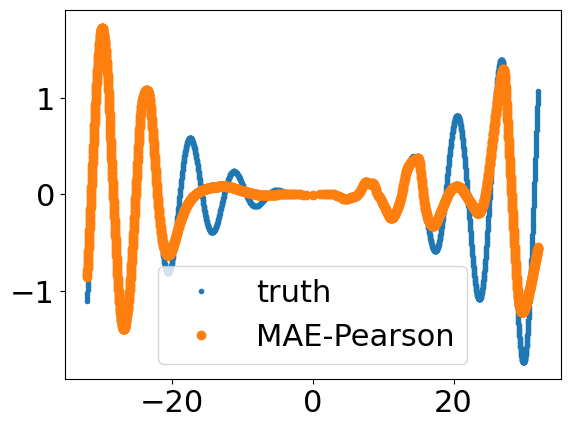

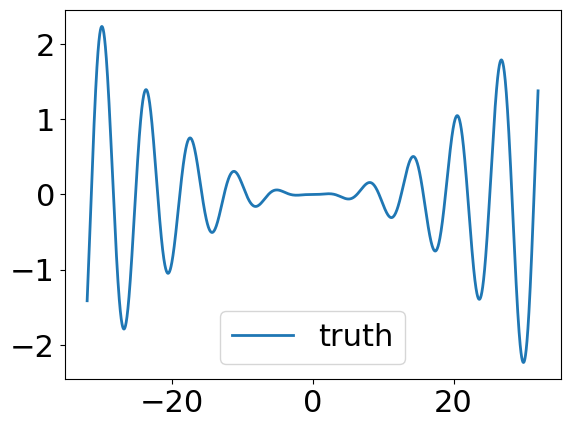

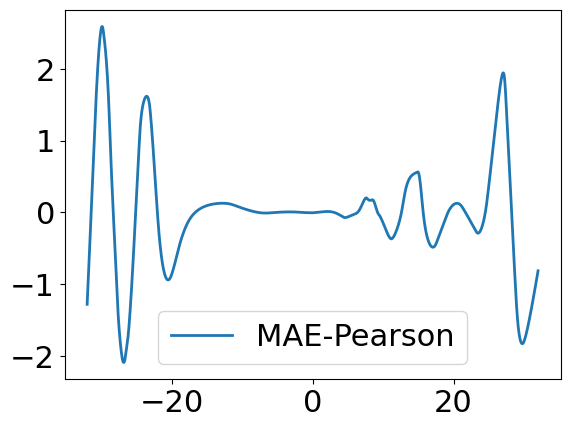

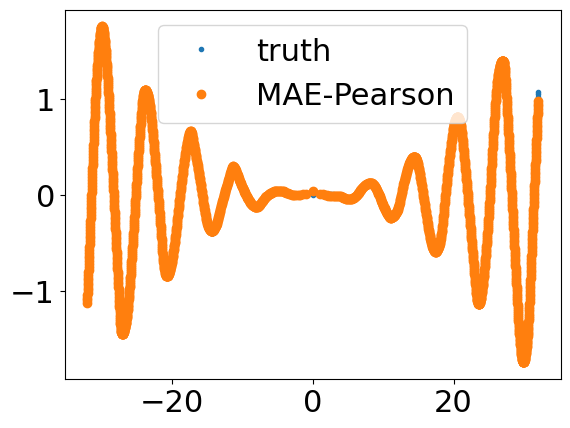

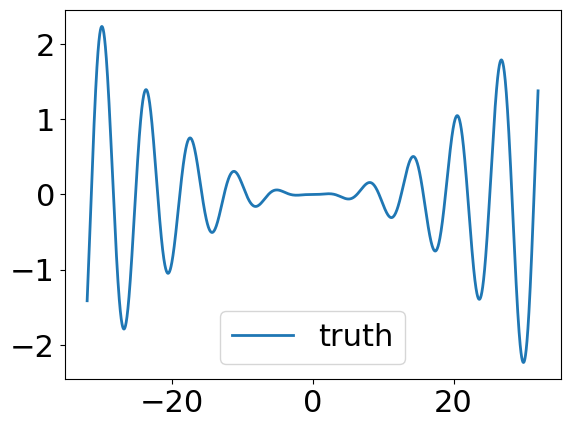

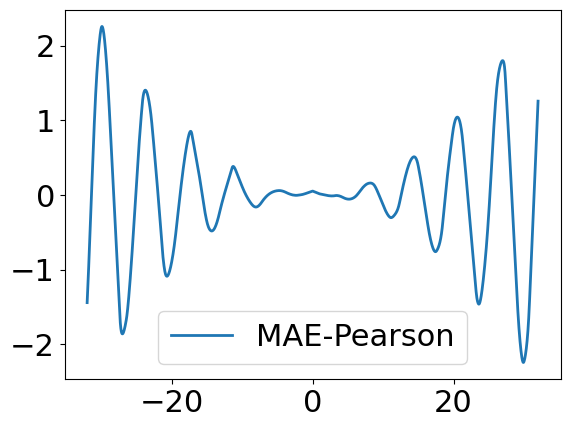

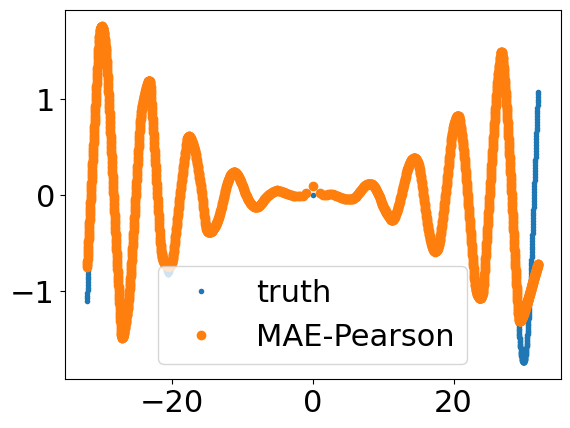

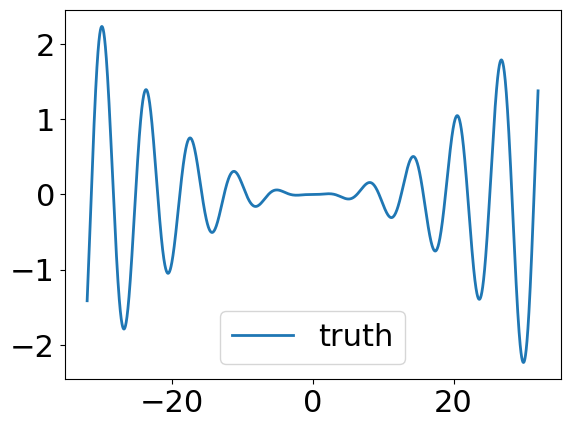

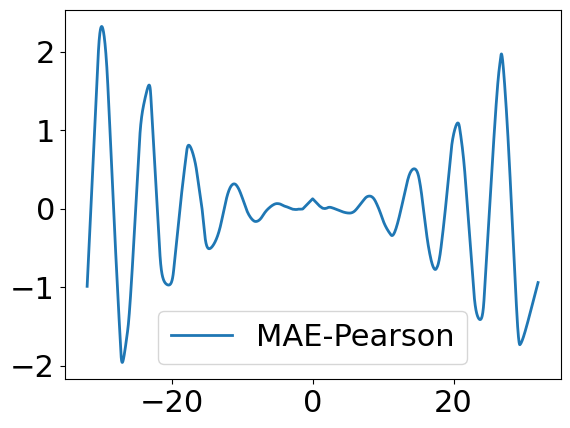

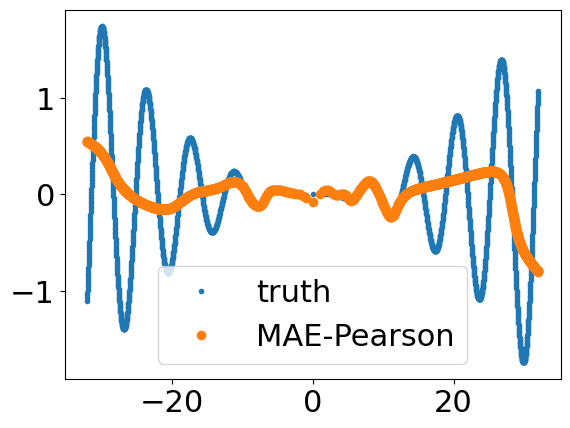

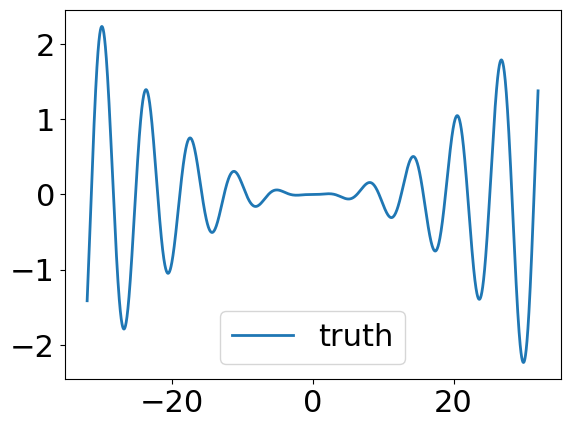

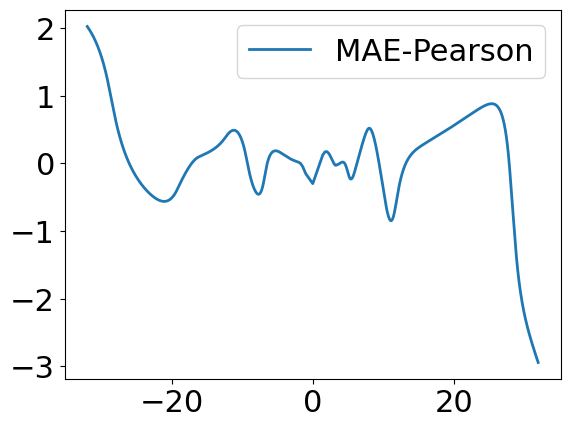

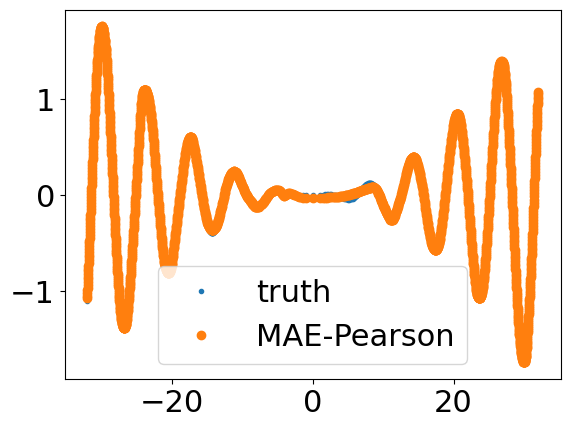

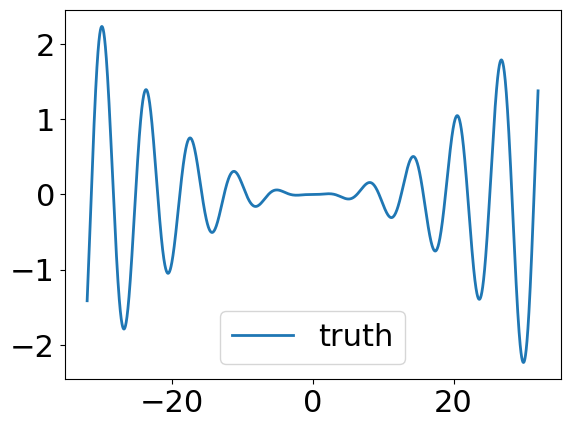

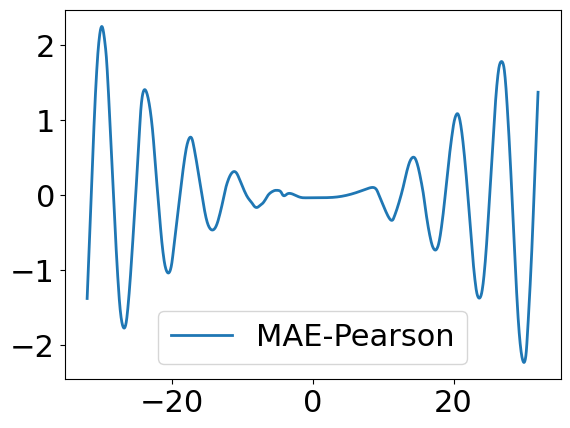

In [5]:
lr = 0.01
decay = 0
class pearson_loss(torch.nn.Module):
    def __init__(self, device = None):
        super().__init__()
        if not device:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device


    def forward(self, y_pred, y_truth):
        pred_std, truth_std = y_pred.std(dim=0), y_truth.std(dim=0)
        pred_mean, truth_mean = y_pred.mean(dim=0), y_truth.mean(dim=0)
        loss = ((y_pred-pred_mean)/pred_std - (y_truth-truth_mean)/truth_std)**2/2
        return loss.mean()


seeds = [1,2,3,4,5]
preds_Pearson = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    loss_pearson = pearson_loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            ploss = loss_pearson(pred_Y, tr_Y)
            beta = ploss.detach()/2
            loss = (1-beta)*loss_MAE(pred_Y, tr_Y) + beta*ploss
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE-Pearson')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE-Pearson')
    plt.legend()

    preds_Pearson.append(pred_Y)
    


Epoch=0, train_MAE=1.2483, train_RMSE=1.6333, train_Pearson=0.0110, train_Spearman=0.0102, lr=0.0100
test_MAE=0.6838, test_RMSE=0.8673, test_Pearson=-0.1440, test_Spearman=-0.1173
Epoch=1, train_MAE=0.6853, train_RMSE=0.8614, train_Pearson=0.0045, train_Spearman=-0.0029, lr=0.0100
test_MAE=0.6099, test_RMSE=0.7795, test_Pearson=0.1809, test_Spearman=0.2008
Epoch=2, train_MAE=0.6442, train_RMSE=0.8023, train_Pearson=0.0716, train_Spearman=0.0647, lr=0.0100
test_MAE=0.6162, test_RMSE=0.7913, test_Pearson=0.1392, test_Spearman=0.0939
Epoch=3, train_MAE=0.6335, train_RMSE=0.7926, train_Pearson=0.0179, train_Spearman=0.0145, lr=0.0100
test_MAE=0.6350, test_RMSE=0.8034, test_Pearson=0.1509, test_Spearman=0.1791
Epoch=4, train_MAE=0.6389, train_RMSE=0.7985, train_Pearson=-0.0212, train_Spearman=-0.0233, lr=0.0100
test_MAE=0.5984, test_RMSE=0.7698, test_Pearson=0.1896, test_Spearman=0.1866
Epoch=5, train_MAE=0.6232, train_RMSE=0.7857, train_Pearson=0.0590, train_Spearman=0.0390, lr=0.0100
test

Epoch=46, train_MAE=0.6181, train_RMSE=0.7772, train_Pearson=0.1219, train_Spearman=0.0607, lr=0.0100
test_MAE=0.5989, test_RMSE=0.7693, test_Pearson=0.2501, test_Spearman=0.1824
Epoch=47, train_MAE=0.6186, train_RMSE=0.7774, train_Pearson=0.1228, train_Spearman=0.0925, lr=0.0100
test_MAE=0.5933, test_RMSE=0.7601, test_Pearson=0.2606, test_Spearman=0.2023
Epoch=48, train_MAE=0.6152, train_RMSE=0.7711, train_Pearson=0.1724, train_Spearman=0.1092, lr=0.0100
test_MAE=0.5925, test_RMSE=0.7592, test_Pearson=0.2401, test_Spearman=0.1919
Epoch=49, train_MAE=0.6141, train_RMSE=0.7711, train_Pearson=0.1748, train_Spearman=0.1113, lr=0.0100
test_MAE=0.5910, test_RMSE=0.7591, test_Pearson=0.2369, test_Spearman=0.1921
Epoch=50, train_MAE=0.6149, train_RMSE=0.7724, train_Pearson=0.1667, train_Spearman=0.0962, lr=0.0100
test_MAE=0.5915, test_RMSE=0.7568, test_Pearson=0.2604, test_Spearman=0.2145
Epoch=51, train_MAE=0.6153, train_RMSE=0.7737, train_Pearson=0.1637, train_Spearman=0.1020, lr=0.0100
tes

Epoch=92, train_MAE=0.6181, train_RMSE=0.7775, train_Pearson=0.1262, train_Spearman=0.0874, lr=0.0100
test_MAE=0.6042, test_RMSE=0.7794, test_Pearson=0.0084, test_Spearman=-0.0106
Epoch=93, train_MAE=0.6202, train_RMSE=0.7828, train_Pearson=0.0008, train_Spearman=-0.0050, lr=0.0100
test_MAE=0.6013, test_RMSE=0.7753, test_Pearson=0.1689, test_Spearman=0.0752
Epoch=94, train_MAE=0.6215, train_RMSE=0.7835, train_Pearson=0.0314, train_Spearman=0.0101, lr=0.0100
test_MAE=0.6027, test_RMSE=0.7746, test_Pearson=0.2177, test_Spearman=0.2000
Epoch=95, train_MAE=0.6209, train_RMSE=0.7802, train_Pearson=0.0664, train_Spearman=0.0347, lr=0.0100
test_MAE=0.6000, test_RMSE=0.7694, test_Pearson=0.2284, test_Spearman=0.2011
Epoch=96, train_MAE=0.6230, train_RMSE=0.7856, train_Pearson=-0.0494, train_Spearman=-0.0526, lr=0.0100
test_MAE=0.6058, test_RMSE=0.7787, test_Pearson=0.1391, test_Spearman=0.1279
Epoch=97, train_MAE=0.6212, train_RMSE=0.7814, train_Pearson=0.0430, train_Spearman=0.0359, lr=0.0100

test_MAE=0.5844, test_RMSE=0.7513, test_Pearson=0.2708, test_Spearman=0.1983
Epoch=138, train_MAE=0.6058, train_RMSE=0.7655, train_Pearson=0.2195, train_Spearman=0.1360, lr=0.0010
test_MAE=0.5792, test_RMSE=0.7428, test_Pearson=0.3015, test_Spearman=0.2145
Epoch=139, train_MAE=0.6078, train_RMSE=0.7697, train_Pearson=0.2092, train_Spearman=0.1256, lr=0.0010
test_MAE=0.5826, test_RMSE=0.7429, test_Pearson=0.3096, test_Spearman=0.1749
Epoch=140, train_MAE=0.6100, train_RMSE=0.7719, train_Pearson=0.2020, train_Spearman=0.0967, lr=0.0010
test_MAE=0.5834, test_RMSE=0.7471, test_Pearson=0.3044, test_Spearman=0.1938
Epoch=141, train_MAE=0.6082, train_RMSE=0.7682, train_Pearson=0.2004, train_Spearman=0.1049, lr=0.0010
test_MAE=0.5800, test_RMSE=0.7440, test_Pearson=0.2950, test_Spearman=0.1942
Epoch=142, train_MAE=0.6067, train_RMSE=0.7613, train_Pearson=0.2280, train_Spearman=0.1373, lr=0.0010
test_MAE=0.5890, test_RMSE=0.7555, test_Pearson=0.2766, test_Spearman=0.2223
Epoch=143, train_MAE=0.

test_MAE=0.5300, test_RMSE=0.6874, test_Pearson=0.4870, test_Spearman=0.3390
Epoch=184, train_MAE=0.5638, train_RMSE=0.7363, train_Pearson=0.3814, train_Spearman=0.3221, lr=0.0010
test_MAE=0.5628, test_RMSE=0.7294, test_Pearson=0.3718, test_Spearman=0.2862
Epoch=185, train_MAE=0.5550, train_RMSE=0.7199, train_Pearson=0.3994, train_Spearman=0.2998, lr=0.0010
test_MAE=0.5764, test_RMSE=0.7548, test_Pearson=0.2864, test_Spearman=0.1457
Epoch=186, train_MAE=0.5548, train_RMSE=0.7167, train_Pearson=0.4053, train_Spearman=0.3148, lr=0.0010
test_MAE=0.5231, test_RMSE=0.6807, test_Pearson=0.4882, test_Spearman=0.3894
Epoch=187, train_MAE=0.5316, train_RMSE=0.6920, train_Pearson=0.4738, train_Spearman=0.3974, lr=0.0010
test_MAE=0.5092, test_RMSE=0.6688, test_Pearson=0.5165, test_Spearman=0.3758
Epoch=188, train_MAE=0.5280, train_RMSE=0.6936, train_Pearson=0.4610, train_Spearman=0.3614, lr=0.0010
test_MAE=0.5036, test_RMSE=0.6695, test_Pearson=0.5109, test_Spearman=0.3640
Epoch=189, train_MAE=0.

test_MAE=0.3726, test_RMSE=0.5618, test_Pearson=0.7024, test_Spearman=0.5791
Epoch=230, train_MAE=0.3770, train_RMSE=0.5654, train_Pearson=0.6979, train_Spearman=0.5832, lr=0.0001
test_MAE=0.3707, test_RMSE=0.5580, test_Pearson=0.7060, test_Spearman=0.5804
Epoch=231, train_MAE=0.3766, train_RMSE=0.5683, train_Pearson=0.6946, train_Spearman=0.5878, lr=0.0001
test_MAE=0.3737, test_RMSE=0.5618, test_Pearson=0.6980, test_Spearman=0.5617
Epoch=232, train_MAE=0.3733, train_RMSE=0.5648, train_Pearson=0.6977, train_Spearman=0.5785, lr=0.0001
test_MAE=0.3670, test_RMSE=0.5559, test_Pearson=0.7121, test_Spearman=0.5929
Epoch=233, train_MAE=0.3716, train_RMSE=0.5607, train_Pearson=0.7057, train_Spearman=0.6023, lr=0.0001
test_MAE=0.3681, test_RMSE=0.5536, test_Pearson=0.7105, test_Spearman=0.5787
Epoch=234, train_MAE=0.3720, train_RMSE=0.5590, train_Pearson=0.7041, train_Spearman=0.5847, lr=0.0001
test_MAE=0.3707, test_RMSE=0.5521, test_Pearson=0.7103, test_Spearman=0.5760
Epoch=235, train_MAE=0.

test_MAE=0.2972, test_RMSE=0.4821, test_Pearson=0.7885, test_Spearman=0.6772
Epoch=276, train_MAE=0.3028, train_RMSE=0.4901, train_Pearson=0.7817, train_Spearman=0.6809, lr=0.0001
test_MAE=0.2965, test_RMSE=0.4753, test_Pearson=0.7957, test_Spearman=0.6883
Epoch=277, train_MAE=0.3001, train_RMSE=0.4849, train_Pearson=0.7873, train_Spearman=0.6941, lr=0.0001
test_MAE=0.2962, test_RMSE=0.4737, test_Pearson=0.7963, test_Spearman=0.6865
Epoch=278, train_MAE=0.2980, train_RMSE=0.4822, train_Pearson=0.7891, train_Spearman=0.6961, lr=0.0001
test_MAE=0.2888, test_RMSE=0.4704, test_Pearson=0.7995, test_Spearman=0.6925
Epoch=279, train_MAE=0.2958, train_RMSE=0.4827, train_Pearson=0.7887, train_Spearman=0.6910, lr=0.0001
test_MAE=0.2875, test_RMSE=0.4705, test_Pearson=0.8005, test_Spearman=0.6948
Epoch=280, train_MAE=0.2951, train_RMSE=0.4810, train_Pearson=0.7907, train_Spearman=0.6954, lr=0.0001
test_MAE=0.2911, test_RMSE=0.4693, test_Pearson=0.8007, test_Spearman=0.6944
Epoch=281, train_MAE=0.

Epoch=21, train_MAE=0.6208, train_RMSE=0.7744, train_Pearson=0.1376, train_Spearman=0.0906, lr=0.0100
test_MAE=0.5967, test_RMSE=0.7665, test_Pearson=0.2343, test_Spearman=0.1995
Epoch=22, train_MAE=0.6189, train_RMSE=0.7761, train_Pearson=0.1391, train_Spearman=0.0741, lr=0.0100
test_MAE=0.5975, test_RMSE=0.7676, test_Pearson=0.2165, test_Spearman=0.1622
Epoch=23, train_MAE=0.6210, train_RMSE=0.7787, train_Pearson=0.0892, train_Spearman=0.0659, lr=0.0100
test_MAE=0.6002, test_RMSE=0.7670, test_Pearson=0.2294, test_Spearman=0.1654
Epoch=24, train_MAE=0.6209, train_RMSE=0.7818, train_Pearson=0.1143, train_Spearman=0.0842, lr=0.0100
test_MAE=0.5903, test_RMSE=0.7573, test_Pearson=0.2282, test_Spearman=0.2011
Epoch=25, train_MAE=0.6182, train_RMSE=0.7768, train_Pearson=0.1152, train_Spearman=0.0871, lr=0.0100
test_MAE=0.6086, test_RMSE=0.7838, test_Pearson=0.0056, test_Spearman=0.0401
Epoch=26, train_MAE=0.6205, train_RMSE=0.7791, train_Pearson=0.0823, train_Spearman=0.0641, lr=0.0100
tes

Epoch=67, train_MAE=0.6217, train_RMSE=0.7787, train_Pearson=0.0889, train_Spearman=0.0733, lr=0.0100
test_MAE=0.5966, test_RMSE=0.7661, test_Pearson=0.2352, test_Spearman=0.1981
Epoch=68, train_MAE=0.6183, train_RMSE=0.7737, train_Pearson=0.1534, train_Spearman=0.0991, lr=0.0100
test_MAE=0.5946, test_RMSE=0.7630, test_Pearson=0.2438, test_Spearman=0.2012
Epoch=69, train_MAE=0.6232, train_RMSE=0.7810, train_Pearson=0.0790, train_Spearman=0.0422, lr=0.0100
test_MAE=0.5991, test_RMSE=0.7676, test_Pearson=0.2452, test_Spearman=0.2012
Epoch=70, train_MAE=0.6187, train_RMSE=0.7775, train_Pearson=0.1072, train_Spearman=0.0642, lr=0.0100
test_MAE=0.5935, test_RMSE=0.7613, test_Pearson=0.2615, test_Spearman=0.1903
Epoch=71, train_MAE=0.6196, train_RMSE=0.7763, train_Pearson=0.1312, train_Spearman=0.0871, lr=0.0100
test_MAE=0.5946, test_RMSE=0.7609, test_Pearson=0.2663, test_Spearman=0.2096
Epoch=72, train_MAE=0.6157, train_RMSE=0.7748, train_Pearson=0.1539, train_Spearman=0.0894, lr=0.0100
tes

Epoch=113, train_MAE=0.6155, train_RMSE=0.7741, train_Pearson=0.1595, train_Spearman=0.1015, lr=0.0010
test_MAE=0.5958, test_RMSE=0.7660, test_Pearson=0.2223, test_Spearman=0.2079
Epoch=114, train_MAE=0.6141, train_RMSE=0.7722, train_Pearson=0.1732, train_Spearman=0.1284, lr=0.0010
test_MAE=0.5940, test_RMSE=0.7633, test_Pearson=0.2174, test_Spearman=0.2029
Epoch=115, train_MAE=0.6140, train_RMSE=0.7718, train_Pearson=0.1658, train_Spearman=0.1239, lr=0.0010
test_MAE=0.5934, test_RMSE=0.7627, test_Pearson=0.2172, test_Spearman=0.2030
Epoch=116, train_MAE=0.6135, train_RMSE=0.7713, train_Pearson=0.1733, train_Spearman=0.1271, lr=0.0010
test_MAE=0.5934, test_RMSE=0.7623, test_Pearson=0.2242, test_Spearman=0.2073
Epoch=117, train_MAE=0.6136, train_RMSE=0.7706, train_Pearson=0.1791, train_Spearman=0.1205, lr=0.0010
test_MAE=0.5935, test_RMSE=0.7616, test_Pearson=0.2380, test_Spearman=0.1963
Epoch=118, train_MAE=0.6135, train_RMSE=0.7707, train_Pearson=0.1702, train_Spearman=0.1132, lr=0.00

test_MAE=0.5828, test_RMSE=0.7404, test_Pearson=0.3412, test_Spearman=0.2066
Epoch=159, train_MAE=0.6095, train_RMSE=0.7640, train_Pearson=0.2215, train_Spearman=0.1563, lr=0.0010
test_MAE=0.5820, test_RMSE=0.7422, test_Pearson=0.3004, test_Spearman=0.1520
Epoch=160, train_MAE=0.6053, train_RMSE=0.7581, train_Pearson=0.2443, train_Spearman=0.1082, lr=0.0010
test_MAE=0.5864, test_RMSE=0.7454, test_Pearson=0.3254, test_Spearman=0.1872
Epoch=161, train_MAE=0.6048, train_RMSE=0.7593, train_Pearson=0.2405, train_Spearman=0.1447, lr=0.0010
test_MAE=0.5771, test_RMSE=0.7316, test_Pearson=0.3556, test_Spearman=0.1546
Epoch=162, train_MAE=0.6059, train_RMSE=0.7596, train_Pearson=0.2387, train_Spearman=0.1645, lr=0.0010
test_MAE=0.5770, test_RMSE=0.7335, test_Pearson=0.3320, test_Spearman=0.1535
Epoch=163, train_MAE=0.6012, train_RMSE=0.7532, train_Pearson=0.2683, train_Spearman=0.0990, lr=0.0010
test_MAE=0.5766, test_RMSE=0.7311, test_Pearson=0.3500, test_Spearman=0.1452
Epoch=164, train_MAE=0.

test_MAE=0.5366, test_RMSE=0.6881, test_Pearson=0.4667, test_Spearman=0.3170
Epoch=205, train_MAE=0.5588, train_RMSE=0.7143, train_Pearson=0.4070, train_Spearman=0.2958, lr=0.0001
test_MAE=0.5353, test_RMSE=0.6866, test_Pearson=0.4707, test_Spearman=0.3255
Epoch=206, train_MAE=0.5578, train_RMSE=0.7132, train_Pearson=0.4100, train_Spearman=0.2984, lr=0.0001
test_MAE=0.5341, test_RMSE=0.6852, test_Pearson=0.4741, test_Spearman=0.3317
Epoch=207, train_MAE=0.5583, train_RMSE=0.7133, train_Pearson=0.4098, train_Spearman=0.3100, lr=0.0001
test_MAE=0.5325, test_RMSE=0.6842, test_Pearson=0.4763, test_Spearman=0.3392
Epoch=208, train_MAE=0.5569, train_RMSE=0.7134, train_Pearson=0.4108, train_Spearman=0.2964, lr=0.0001
test_MAE=0.5347, test_RMSE=0.6858, test_Pearson=0.4721, test_Spearman=0.3218
Epoch=209, train_MAE=0.5556, train_RMSE=0.7108, train_Pearson=0.4166, train_Spearman=0.3065, lr=0.0001
test_MAE=0.5308, test_RMSE=0.6824, test_Pearson=0.4819, test_Spearman=0.3435
Epoch=210, train_MAE=0.

test_MAE=0.4656, test_RMSE=0.6199, test_Pearson=0.6056, test_Spearman=0.3926
Epoch=251, train_MAE=0.4884, train_RMSE=0.6458, train_Pearson=0.5651, train_Spearman=0.3633, lr=0.0001
test_MAE=0.4547, test_RMSE=0.6152, test_Pearson=0.6127, test_Spearman=0.3987
Epoch=252, train_MAE=0.4911, train_RMSE=0.6455, train_Pearson=0.5651, train_Spearman=0.3644, lr=0.0001
test_MAE=0.4702, test_RMSE=0.6220, test_Pearson=0.6003, test_Spearman=0.3749
Epoch=253, train_MAE=0.4816, train_RMSE=0.6405, train_Pearson=0.5762, train_Spearman=0.3800, lr=0.0001
test_MAE=0.4533, test_RMSE=0.6136, test_Pearson=0.6162, test_Spearman=0.3984
Epoch=254, train_MAE=0.4777, train_RMSE=0.6388, train_Pearson=0.5796, train_Spearman=0.3775, lr=0.0001
test_MAE=0.4541, test_RMSE=0.6128, test_Pearson=0.6168, test_Spearman=0.3988
Epoch=255, train_MAE=0.4802, train_RMSE=0.6408, train_Pearson=0.5752, train_Spearman=0.3665, lr=0.0001
test_MAE=0.4592, test_RMSE=0.6143, test_Pearson=0.6141, test_Spearman=0.3975
Epoch=256, train_MAE=0.

test_MAE=0.4103, test_RMSE=0.5762, test_Pearson=0.6717, test_Spearman=0.4563
Epoch=297, train_MAE=0.4365, train_RMSE=0.6026, train_Pearson=0.6374, train_Spearman=0.4305, lr=0.0001
test_MAE=0.4120, test_RMSE=0.5756, test_Pearson=0.6728, test_Spearman=0.4641
Epoch=298, train_MAE=0.4349, train_RMSE=0.6017, train_Pearson=0.6386, train_Spearman=0.4445, lr=0.0001
test_MAE=0.4072, test_RMSE=0.5745, test_Pearson=0.6739, test_Spearman=0.4712
Epoch=299, train_MAE=0.4320, train_RMSE=0.6015, train_Pearson=0.6386, train_Spearman=0.4403, lr=0.0001
test_MAE=0.4099, test_RMSE=0.5760, test_Pearson=0.6723, test_Spearman=0.4643
torch.Size([128, 1])
torch.Size([2048, 1])
Epoch=0, train_MAE=1.5152, train_RMSE=2.1597, train_Pearson=-0.0081, train_Spearman=-0.0388, lr=0.0100
test_MAE=0.6700, test_RMSE=0.8509, test_Pearson=0.1443, test_Spearman=0.0953
Epoch=1, train_MAE=0.6772, train_RMSE=0.8583, train_Pearson=-0.0005, train_Spearman=-0.0059, lr=0.0100
test_MAE=0.6335, test_RMSE=0.8115, test_Pearson=-0.1272, 

test_MAE=0.6010, test_RMSE=0.7733, test_Pearson=0.2362, test_Spearman=0.1904
Epoch=43, train_MAE=0.6163, train_RMSE=0.7743, train_Pearson=0.1580, train_Spearman=0.1135, lr=0.0100
test_MAE=0.5901, test_RMSE=0.7576, test_Pearson=0.2359, test_Spearman=0.2010
Epoch=44, train_MAE=0.6203, train_RMSE=0.7748, train_Pearson=0.1439, train_Spearman=0.1104, lr=0.0100
test_MAE=0.5993, test_RMSE=0.7638, test_Pearson=0.2540, test_Spearman=0.1988
Epoch=45, train_MAE=0.6193, train_RMSE=0.7770, train_Pearson=0.1099, train_Spearman=0.0759, lr=0.0100
test_MAE=0.5965, test_RMSE=0.7648, test_Pearson=0.2498, test_Spearman=0.2061
Epoch=46, train_MAE=0.6177, train_RMSE=0.7740, train_Pearson=0.1383, train_Spearman=0.1070, lr=0.0100
test_MAE=0.5934, test_RMSE=0.7612, test_Pearson=0.2428, test_Spearman=0.1995
Epoch=47, train_MAE=0.6221, train_RMSE=0.7828, train_Pearson=0.0677, train_Spearman=0.0305, lr=0.0100
test_MAE=0.6028, test_RMSE=0.7758, test_Pearson=0.0980, test_Spearman=0.0617
Epoch=48, train_MAE=0.6182, 

test_MAE=0.5958, test_RMSE=0.7659, test_Pearson=0.2198, test_Spearman=0.2023
Epoch=89, train_MAE=0.6178, train_RMSE=0.7733, train_Pearson=0.1522, train_Spearman=0.0996, lr=0.0100
test_MAE=0.5913, test_RMSE=0.7593, test_Pearson=0.2370, test_Spearman=0.2072
Epoch=90, train_MAE=0.6176, train_RMSE=0.7735, train_Pearson=0.1505, train_Spearman=0.0898, lr=0.0100
test_MAE=0.6029, test_RMSE=0.7767, test_Pearson=0.1376, test_Spearman=0.1185
Epoch=91, train_MAE=0.6200, train_RMSE=0.7816, train_Pearson=0.0428, train_Spearman=0.0299, lr=0.0100
test_MAE=0.5958, test_RMSE=0.7652, test_Pearson=0.2355, test_Spearman=0.2012
Epoch=92, train_MAE=0.6198, train_RMSE=0.7756, train_Pearson=0.1255, train_Spearman=0.0746, lr=0.0100
test_MAE=0.5980, test_RMSE=0.7690, test_Pearson=0.2057, test_Spearman=0.1566
Epoch=93, train_MAE=0.6234, train_RMSE=0.7802, train_Pearson=0.1154, train_Spearman=0.0947, lr=0.0100
test_MAE=0.6084, test_RMSE=0.7668, test_Pearson=0.2121, test_Spearman=0.2056
Epoch=94, train_MAE=0.6216, 

test_MAE=0.5827, test_RMSE=0.7409, test_Pearson=0.3158, test_Spearman=0.1708
Epoch=135, train_MAE=0.6055, train_RMSE=0.7571, train_Pearson=0.2533, train_Spearman=0.1260, lr=0.0010
test_MAE=0.5892, test_RMSE=0.7518, test_Pearson=0.2781, test_Spearman=0.1527
Epoch=136, train_MAE=0.6087, train_RMSE=0.7685, train_Pearson=0.2074, train_Spearman=0.1533, lr=0.0010
test_MAE=0.5859, test_RMSE=0.7446, test_Pearson=0.3165, test_Spearman=0.1567
Epoch=137, train_MAE=0.6089, train_RMSE=0.7639, train_Pearson=0.2117, train_Spearman=0.1515, lr=0.0010
test_MAE=0.5930, test_RMSE=0.7619, test_Pearson=0.2477, test_Spearman=0.2048
Epoch=138, train_MAE=0.6076, train_RMSE=0.7627, train_Pearson=0.2245, train_Spearman=0.1289, lr=0.0010
test_MAE=0.5832, test_RMSE=0.7416, test_Pearson=0.3302, test_Spearman=0.1757
Epoch=139, train_MAE=0.6103, train_RMSE=0.7649, train_Pearson=0.2129, train_Spearman=0.1072, lr=0.0010
test_MAE=0.5893, test_RMSE=0.7498, test_Pearson=0.3029, test_Spearman=0.1433
Epoch=140, train_MAE=0.

test_MAE=0.5817, test_RMSE=0.7462, test_Pearson=0.2932, test_Spearman=0.1531
Epoch=181, train_MAE=0.5958, train_RMSE=0.7630, train_Pearson=0.2559, train_Spearman=0.1610, lr=0.0010
test_MAE=0.5839, test_RMSE=0.7461, test_Pearson=0.2866, test_Spearman=0.1443
Epoch=182, train_MAE=0.5950, train_RMSE=0.7577, train_Pearson=0.2584, train_Spearman=0.1595, lr=0.0010
test_MAE=0.5789, test_RMSE=0.7457, test_Pearson=0.2949, test_Spearman=0.2391
Epoch=183, train_MAE=0.5981, train_RMSE=0.7643, train_Pearson=0.2485, train_Spearman=0.1996, lr=0.0010
test_MAE=0.5807, test_RMSE=0.7417, test_Pearson=0.3000, test_Spearman=0.1859
Epoch=184, train_MAE=0.5979, train_RMSE=0.7568, train_Pearson=0.2494, train_Spearman=0.1460, lr=0.0010
test_MAE=0.5814, test_RMSE=0.7458, test_Pearson=0.2946, test_Spearman=0.2022
Epoch=185, train_MAE=0.5929, train_RMSE=0.7570, train_Pearson=0.2636, train_Spearman=0.1898, lr=0.0010
test_MAE=0.5790, test_RMSE=0.7452, test_Pearson=0.2994, test_Spearman=0.2030
Epoch=186, train_MAE=0.

test_MAE=0.5397, test_RMSE=0.7199, test_Pearson=0.3879, test_Spearman=0.2993
Epoch=227, train_MAE=0.5427, train_RMSE=0.7290, train_Pearson=0.3680, train_Spearman=0.2938, lr=0.0001
test_MAE=0.5377, test_RMSE=0.7178, test_Pearson=0.3925, test_Spearman=0.3101
Epoch=228, train_MAE=0.5420, train_RMSE=0.7285, train_Pearson=0.3689, train_Spearman=0.2947, lr=0.0001
test_MAE=0.5370, test_RMSE=0.7176, test_Pearson=0.3933, test_Spearman=0.3115
Epoch=229, train_MAE=0.5407, train_RMSE=0.7282, train_Pearson=0.3713, train_Spearman=0.2955, lr=0.0001
test_MAE=0.5365, test_RMSE=0.7186, test_Pearson=0.3934, test_Spearman=0.3113
Epoch=230, train_MAE=0.5403, train_RMSE=0.7285, train_Pearson=0.3719, train_Spearman=0.3001, lr=0.0001
test_MAE=0.5365, test_RMSE=0.7179, test_Pearson=0.3955, test_Spearman=0.3131
Epoch=231, train_MAE=0.5387, train_RMSE=0.7269, train_Pearson=0.3741, train_Spearman=0.3066, lr=0.0001
test_MAE=0.5352, test_RMSE=0.7159, test_Pearson=0.3977, test_Spearman=0.3280
Epoch=232, train_MAE=0.

test_MAE=0.5041, test_RMSE=0.6873, test_Pearson=0.4739, test_Spearman=0.4129
Epoch=273, train_MAE=0.5109, train_RMSE=0.7007, train_Pearson=0.4438, train_Spearman=0.3700, lr=0.0001
test_MAE=0.5054, test_RMSE=0.6869, test_Pearson=0.4726, test_Spearman=0.4139
Epoch=274, train_MAE=0.5120, train_RMSE=0.7019, train_Pearson=0.4419, train_Spearman=0.3644, lr=0.0001
test_MAE=0.5028, test_RMSE=0.6868, test_Pearson=0.4735, test_Spearman=0.4021
Epoch=275, train_MAE=0.5109, train_RMSE=0.7001, train_Pearson=0.4461, train_Spearman=0.3761, lr=0.0001
test_MAE=0.5048, test_RMSE=0.6850, test_Pearson=0.4799, test_Spearman=0.4139
Epoch=276, train_MAE=0.5105, train_RMSE=0.6988, train_Pearson=0.4489, train_Spearman=0.3725, lr=0.0001
test_MAE=0.5056, test_RMSE=0.6846, test_Pearson=0.4760, test_Spearman=0.4166
Epoch=277, train_MAE=0.5109, train_RMSE=0.6991, train_Pearson=0.4479, train_Spearman=0.3683, lr=0.0001
test_MAE=0.5032, test_RMSE=0.6845, test_Pearson=0.4789, test_Spearman=0.4054
Epoch=278, train_MAE=0.

Epoch=18, train_MAE=0.6230, train_RMSE=0.7817, train_Pearson=0.0617, train_Spearman=0.0389, lr=0.0100
test_MAE=0.6039, test_RMSE=0.7767, test_Pearson=0.1398, test_Spearman=0.1378
Epoch=19, train_MAE=0.6295, train_RMSE=0.7927, train_Pearson=0.0016, train_Spearman=-0.0116, lr=0.0100
test_MAE=0.6164, test_RMSE=0.7923, test_Pearson=0.1854, test_Spearman=0.1596
Epoch=20, train_MAE=0.6239, train_RMSE=0.7872, train_Pearson=0.0222, train_Spearman=0.0461, lr=0.0100
test_MAE=0.5981, test_RMSE=0.7664, test_Pearson=0.2004, test_Spearman=0.1882
Epoch=21, train_MAE=0.6267, train_RMSE=0.7861, train_Pearson=0.0577, train_Spearman=0.0352, lr=0.0100
test_MAE=0.6018, test_RMSE=0.7670, test_Pearson=0.2185, test_Spearman=0.1964
Epoch=22, train_MAE=0.6224, train_RMSE=0.7803, train_Pearson=0.0628, train_Spearman=0.0471, lr=0.0100
test_MAE=0.5942, test_RMSE=0.7630, test_Pearson=0.2389, test_Spearman=0.2045
Epoch=23, train_MAE=0.6247, train_RMSE=0.7831, train_Pearson=0.1173, train_Spearman=0.0721, lr=0.0100
te

Epoch=64, train_MAE=0.6196, train_RMSE=0.7780, train_Pearson=0.0996, train_Spearman=0.0588, lr=0.0100
test_MAE=0.5937, test_RMSE=0.7619, test_Pearson=0.2662, test_Spearman=0.1964
Epoch=65, train_MAE=0.6225, train_RMSE=0.7788, train_Pearson=0.1176, train_Spearman=0.0698, lr=0.0100
test_MAE=0.5926, test_RMSE=0.7613, test_Pearson=0.2449, test_Spearman=0.2035
Epoch=66, train_MAE=0.6164, train_RMSE=0.7768, train_Pearson=0.1093, train_Spearman=0.0640, lr=0.0100
test_MAE=0.6099, test_RMSE=0.7842, test_Pearson=-0.0092, test_Spearman=-0.0039
Epoch=67, train_MAE=0.6209, train_RMSE=0.7816, train_Pearson=0.0319, train_Spearman=0.0170, lr=0.0100
test_MAE=0.6002, test_RMSE=0.7725, test_Pearson=0.1909, test_Spearman=0.1665
Epoch=68, train_MAE=0.6185, train_RMSE=0.7790, train_Pearson=0.0880, train_Spearman=0.0474, lr=0.0100
test_MAE=0.5989, test_RMSE=0.7701, test_Pearson=0.2310, test_Spearman=0.1923
Epoch=69, train_MAE=0.6201, train_RMSE=0.7799, train_Pearson=0.0922, train_Spearman=0.0641, lr=0.0100
t

Epoch=110, train_MAE=0.6125, train_RMSE=0.7697, train_Pearson=0.2022, train_Spearman=0.1443, lr=0.0010
test_MAE=0.5949, test_RMSE=0.7626, test_Pearson=0.2318, test_Spearman=0.1742
Epoch=111, train_MAE=0.6131, train_RMSE=0.7746, train_Pearson=0.1687, train_Spearman=0.0912, lr=0.0010
test_MAE=0.5941, test_RMSE=0.7663, test_Pearson=0.2162, test_Spearman=0.2018
Epoch=112, train_MAE=0.6125, train_RMSE=0.7707, train_Pearson=0.1706, train_Spearman=0.0873, lr=0.0010
test_MAE=0.5958, test_RMSE=0.7639, test_Pearson=0.2519, test_Spearman=0.0795
Epoch=113, train_MAE=0.6124, train_RMSE=0.7694, train_Pearson=0.2056, train_Spearman=0.0880, lr=0.0010
test_MAE=0.5948, test_RMSE=0.7620, test_Pearson=0.2335, test_Spearman=0.1831
Epoch=114, train_MAE=0.6117, train_RMSE=0.7717, train_Pearson=0.1826, train_Spearman=0.0700, lr=0.0010
test_MAE=0.5937, test_RMSE=0.7651, test_Pearson=0.2172, test_Spearman=0.1652
Epoch=115, train_MAE=0.6159, train_RMSE=0.7766, train_Pearson=0.1160, train_Spearman=0.0605, lr=0.00

test_MAE=0.5823, test_RMSE=0.7406, test_Pearson=0.3069, test_Spearman=0.2034
Epoch=156, train_MAE=0.6035, train_RMSE=0.7587, train_Pearson=0.2440, train_Spearman=0.1495, lr=0.0010
test_MAE=0.5865, test_RMSE=0.7468, test_Pearson=0.2946, test_Spearman=0.1643
Epoch=157, train_MAE=0.6083, train_RMSE=0.7669, train_Pearson=0.2110, train_Spearman=0.1041, lr=0.0010
test_MAE=0.5927, test_RMSE=0.7584, test_Pearson=0.2444, test_Spearman=0.1256
Epoch=158, train_MAE=0.6075, train_RMSE=0.7638, train_Pearson=0.2130, train_Spearman=0.0979, lr=0.0010
test_MAE=0.5909, test_RMSE=0.7538, test_Pearson=0.2502, test_Spearman=0.1124
Epoch=159, train_MAE=0.6068, train_RMSE=0.7636, train_Pearson=0.2164, train_Spearman=0.1376, lr=0.0010
test_MAE=0.5910, test_RMSE=0.7548, test_Pearson=0.2618, test_Spearman=0.1258
Epoch=160, train_MAE=0.6074, train_RMSE=0.7651, train_Pearson=0.2141, train_Spearman=0.1505, lr=0.0010
test_MAE=0.5871, test_RMSE=0.7480, test_Pearson=0.2837, test_Spearman=0.1598
Epoch=161, train_MAE=0.

test_MAE=0.5743, test_RMSE=0.7270, test_Pearson=0.3587, test_Spearman=0.1907
Epoch=202, train_MAE=0.5899, train_RMSE=0.7433, train_Pearson=0.3094, train_Spearman=0.1890, lr=0.0001
test_MAE=0.5733, test_RMSE=0.7259, test_Pearson=0.3612, test_Spearman=0.1850
Epoch=203, train_MAE=0.5896, train_RMSE=0.7442, train_Pearson=0.3068, train_Spearman=0.1711, lr=0.0001
test_MAE=0.5728, test_RMSE=0.7262, test_Pearson=0.3573, test_Spearman=0.1560
Epoch=204, train_MAE=0.5896, train_RMSE=0.7445, train_Pearson=0.3064, train_Spearman=0.1625, lr=0.0001
test_MAE=0.5727, test_RMSE=0.7253, test_Pearson=0.3610, test_Spearman=0.1743
Epoch=205, train_MAE=0.5893, train_RMSE=0.7435, train_Pearson=0.3089, train_Spearman=0.1745, lr=0.0001
test_MAE=0.5737, test_RMSE=0.7267, test_Pearson=0.3583, test_Spearman=0.1735
Epoch=206, train_MAE=0.5892, train_RMSE=0.7430, train_Pearson=0.3104, train_Spearman=0.1800, lr=0.0001
test_MAE=0.5726, test_RMSE=0.7251, test_Pearson=0.3621, test_Spearman=0.1781
Epoch=207, train_MAE=0.

test_MAE=0.5673, test_RMSE=0.7194, test_Pearson=0.3792, test_Spearman=0.2020
Epoch=248, train_MAE=0.5842, train_RMSE=0.7384, train_Pearson=0.3291, train_Spearman=0.2121, lr=0.0001
test_MAE=0.5690, test_RMSE=0.7209, test_Pearson=0.3754, test_Spearman=0.2236
Epoch=249, train_MAE=0.5848, train_RMSE=0.7402, train_Pearson=0.3246, train_Spearman=0.1950, lr=0.0001
test_MAE=0.5666, test_RMSE=0.7197, test_Pearson=0.3785, test_Spearman=0.1872
Epoch=250, train_MAE=0.5836, train_RMSE=0.7390, train_Pearson=0.3306, train_Spearman=0.1992, lr=0.0001
test_MAE=0.5671, test_RMSE=0.7186, test_Pearson=0.3817, test_Spearman=0.2254
Epoch=251, train_MAE=0.5835, train_RMSE=0.7373, train_Pearson=0.3330, train_Spearman=0.2263, lr=0.0001
test_MAE=0.5682, test_RMSE=0.7197, test_Pearson=0.3790, test_Spearman=0.2331
Epoch=252, train_MAE=0.5832, train_RMSE=0.7375, train_Pearson=0.3336, train_Spearman=0.2213, lr=0.0001
test_MAE=0.5668, test_RMSE=0.7188, test_Pearson=0.3809, test_Spearman=0.2157
Epoch=253, train_MAE=0.

test_MAE=0.5621, test_RMSE=0.7142, test_Pearson=0.3960, test_Spearman=0.2266
Epoch=294, train_MAE=0.5776, train_RMSE=0.7320, train_Pearson=0.3541, train_Spearman=0.2436, lr=0.0001
test_MAE=0.5628, test_RMSE=0.7140, test_Pearson=0.3954, test_Spearman=0.2351
Epoch=295, train_MAE=0.5770, train_RMSE=0.7320, train_Pearson=0.3545, train_Spearman=0.2338, lr=0.0001
test_MAE=0.5622, test_RMSE=0.7139, test_Pearson=0.3962, test_Spearman=0.2212
Epoch=296, train_MAE=0.5764, train_RMSE=0.7314, train_Pearson=0.3571, train_Spearman=0.2333, lr=0.0001
test_MAE=0.5616, test_RMSE=0.7132, test_Pearson=0.3982, test_Spearman=0.2366
Epoch=297, train_MAE=0.5770, train_RMSE=0.7310, train_Pearson=0.3559, train_Spearman=0.2581, lr=0.0001
test_MAE=0.5624, test_RMSE=0.7135, test_Pearson=0.3970, test_Spearman=0.2420
Epoch=298, train_MAE=0.5766, train_RMSE=0.7315, train_Pearson=0.3568, train_Spearman=0.2322, lr=0.0001
test_MAE=0.5617, test_RMSE=0.7137, test_Pearson=0.3973, test_Spearman=0.2165
Epoch=299, train_MAE=0.

test_MAE=0.5988, test_RMSE=0.7696, test_Pearson=0.2188, test_Spearman=0.2012
Epoch=40, train_MAE=0.6191, train_RMSE=0.7788, train_Pearson=0.1097, train_Spearman=0.0882, lr=0.0100
test_MAE=0.5962, test_RMSE=0.7666, test_Pearson=0.2353, test_Spearman=0.2009
Epoch=41, train_MAE=0.6206, train_RMSE=0.7796, train_Pearson=0.1365, train_Spearman=0.0928, lr=0.0100
test_MAE=0.5965, test_RMSE=0.7665, test_Pearson=0.2279, test_Spearman=0.2011
Epoch=42, train_MAE=0.6221, train_RMSE=0.7823, train_Pearson=0.0648, train_Spearman=0.0386, lr=0.0100
test_MAE=0.6026, test_RMSE=0.7718, test_Pearson=0.2054, test_Spearman=0.1959
Epoch=43, train_MAE=0.6232, train_RMSE=0.7779, train_Pearson=0.0979, train_Spearman=0.0713, lr=0.0100
test_MAE=0.5962, test_RMSE=0.7656, test_Pearson=0.2274, test_Spearman=0.2010
Epoch=44, train_MAE=0.6227, train_RMSE=0.7865, train_Pearson=-0.0190, train_Spearman=-0.0244, lr=0.0100
test_MAE=0.5977, test_RMSE=0.7682, test_Pearson=0.2125, test_Spearman=0.1621
Epoch=45, train_MAE=0.6177

test_MAE=0.6016, test_RMSE=0.7745, test_Pearson=0.1951, test_Spearman=0.1818
Epoch=86, train_MAE=0.6197, train_RMSE=0.7798, train_Pearson=0.0683, train_Spearman=0.0489, lr=0.0100
test_MAE=0.5988, test_RMSE=0.7707, test_Pearson=0.1915, test_Spearman=0.1819
Epoch=87, train_MAE=0.6192, train_RMSE=0.7807, train_Pearson=0.0456, train_Spearman=0.0415, lr=0.0100
test_MAE=0.6001, test_RMSE=0.7728, test_Pearson=0.2474, test_Spearman=0.2071
Epoch=88, train_MAE=0.6186, train_RMSE=0.7771, train_Pearson=0.1149, train_Spearman=0.0690, lr=0.0100
test_MAE=0.5979, test_RMSE=0.7651, test_Pearson=0.2163, test_Spearman=0.2007
Epoch=89, train_MAE=0.6174, train_RMSE=0.7736, train_Pearson=0.1470, train_Spearman=0.1178, lr=0.0100
test_MAE=0.5988, test_RMSE=0.7693, test_Pearson=0.2476, test_Spearman=0.1906
Epoch=90, train_MAE=0.6220, train_RMSE=0.7792, train_Pearson=0.1002, train_Spearman=0.0714, lr=0.0100
test_MAE=0.6021, test_RMSE=0.7719, test_Pearson=0.2304, test_Spearman=0.1148
Epoch=91, train_MAE=0.6202, 

test_MAE=0.5862, test_RMSE=0.7493, test_Pearson=0.2733, test_Spearman=0.2258
Epoch=132, train_MAE=0.6095, train_RMSE=0.7645, train_Pearson=0.2077, train_Spearman=0.1333, lr=0.0010
test_MAE=0.5856, test_RMSE=0.7473, test_Pearson=0.2797, test_Spearman=0.1912
Epoch=133, train_MAE=0.6079, train_RMSE=0.7668, train_Pearson=0.2108, train_Spearman=0.1600, lr=0.0010
test_MAE=0.5868, test_RMSE=0.7522, test_Pearson=0.2605, test_Spearman=0.2113
Epoch=134, train_MAE=0.6080, train_RMSE=0.7647, train_Pearson=0.2126, train_Spearman=0.1492, lr=0.0010
test_MAE=0.5907, test_RMSE=0.7550, test_Pearson=0.2847, test_Spearman=0.1750
Epoch=135, train_MAE=0.6087, train_RMSE=0.7661, train_Pearson=0.2035, train_Spearman=0.1636, lr=0.0010
test_MAE=0.5885, test_RMSE=0.7541, test_Pearson=0.2723, test_Spearman=0.2335
Epoch=136, train_MAE=0.6070, train_RMSE=0.7656, train_Pearson=0.2202, train_Spearman=0.1724, lr=0.0010
test_MAE=0.5869, test_RMSE=0.7485, test_Pearson=0.2757, test_Spearman=0.1865
Epoch=137, train_MAE=0.

test_MAE=0.5765, test_RMSE=0.7339, test_Pearson=0.3324, test_Spearman=0.1586
Epoch=178, train_MAE=0.5942, train_RMSE=0.7527, train_Pearson=0.2705, train_Spearman=0.1238, lr=0.0010
test_MAE=0.5787, test_RMSE=0.7405, test_Pearson=0.3078, test_Spearman=0.1313
Epoch=179, train_MAE=0.6000, train_RMSE=0.7773, train_Pearson=0.2290, train_Spearman=0.1268, lr=0.0010
test_MAE=0.5794, test_RMSE=0.7453, test_Pearson=0.3178, test_Spearman=0.1295
Epoch=180, train_MAE=0.5962, train_RMSE=0.7606, train_Pearson=0.2636, train_Spearman=0.1464, lr=0.0010
test_MAE=0.5817, test_RMSE=0.7442, test_Pearson=0.3008, test_Spearman=0.1353
Epoch=181, train_MAE=0.5896, train_RMSE=0.7467, train_Pearson=0.2963, train_Spearman=0.1436, lr=0.0010
test_MAE=0.5725, test_RMSE=0.7318, test_Pearson=0.3382, test_Spearman=0.1646
Epoch=182, train_MAE=0.5865, train_RMSE=0.7459, train_Pearson=0.3024, train_Spearman=0.1425, lr=0.0010
test_MAE=0.5720, test_RMSE=0.7322, test_Pearson=0.3407, test_Spearman=0.1395
Epoch=183, train_MAE=0.

test_MAE=0.5556, test_RMSE=0.7241, test_Pearson=0.3760, test_Spearman=0.2250
Epoch=224, train_MAE=0.5650, train_RMSE=0.7364, train_Pearson=0.3537, train_Spearman=0.2342, lr=0.0001
test_MAE=0.5555, test_RMSE=0.7246, test_Pearson=0.3759, test_Spearman=0.2306
Epoch=225, train_MAE=0.5641, train_RMSE=0.7355, train_Pearson=0.3561, train_Spearman=0.2351, lr=0.0001
test_MAE=0.5563, test_RMSE=0.7252, test_Pearson=0.3743, test_Spearman=0.2211
Epoch=226, train_MAE=0.5648, train_RMSE=0.7362, train_Pearson=0.3533, train_Spearman=0.2409, lr=0.0001
test_MAE=0.5568, test_RMSE=0.7259, test_Pearson=0.3731, test_Spearman=0.2282
Epoch=227, train_MAE=0.5636, train_RMSE=0.7345, train_Pearson=0.3567, train_Spearman=0.2510, lr=0.0001
test_MAE=0.5557, test_RMSE=0.7241, test_Pearson=0.3762, test_Spearman=0.2357
Epoch=228, train_MAE=0.5648, train_RMSE=0.7374, train_Pearson=0.3538, train_Spearman=0.2318, lr=0.0001
test_MAE=0.5553, test_RMSE=0.7253, test_Pearson=0.3772, test_Spearman=0.2201
Epoch=229, train_MAE=0.

test_MAE=0.5451, test_RMSE=0.7213, test_Pearson=0.3969, test_Spearman=0.2837
Epoch=270, train_MAE=0.5508, train_RMSE=0.7294, train_Pearson=0.3848, train_Spearman=0.3135, lr=0.0001
test_MAE=0.5444, test_RMSE=0.7198, test_Pearson=0.3974, test_Spearman=0.2966
Epoch=271, train_MAE=0.5506, train_RMSE=0.7283, train_Pearson=0.3858, train_Spearman=0.3282, lr=0.0001
test_MAE=0.5448, test_RMSE=0.7202, test_Pearson=0.3965, test_Spearman=0.3016
Epoch=272, train_MAE=0.5503, train_RMSE=0.7283, train_Pearson=0.3856, train_Spearman=0.3305, lr=0.0001
test_MAE=0.5450, test_RMSE=0.7213, test_Pearson=0.3966, test_Spearman=0.2932
Epoch=273, train_MAE=0.5494, train_RMSE=0.7275, train_Pearson=0.3879, train_Spearman=0.3315, lr=0.0001
test_MAE=0.5433, test_RMSE=0.7188, test_Pearson=0.3994, test_Spearman=0.3052
Epoch=274, train_MAE=0.5488, train_RMSE=0.7271, train_Pearson=0.3893, train_Spearman=0.3304, lr=0.0001
test_MAE=0.5430, test_RMSE=0.7199, test_Pearson=0.4000, test_Spearman=0.2996
Epoch=275, train_MAE=0.

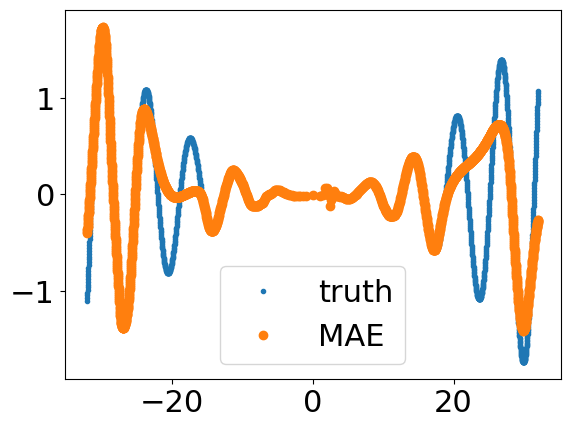

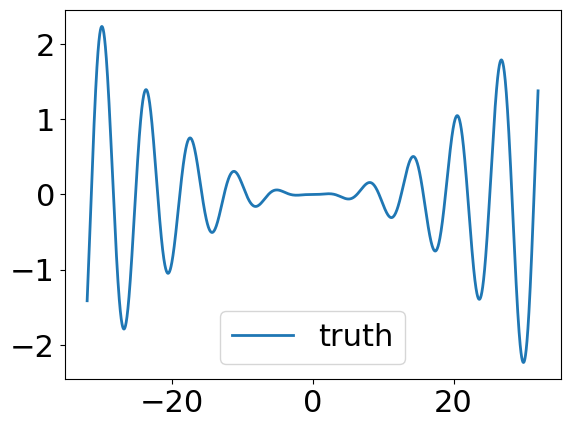

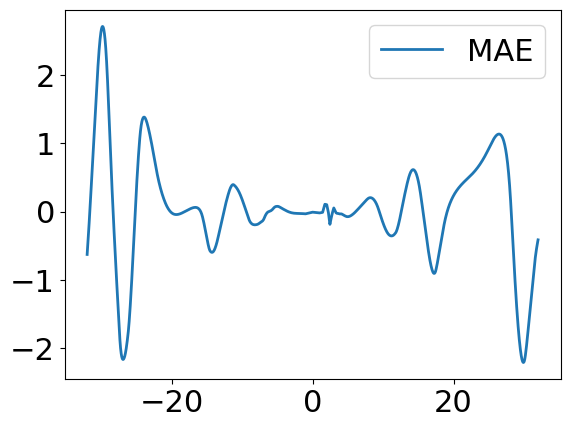

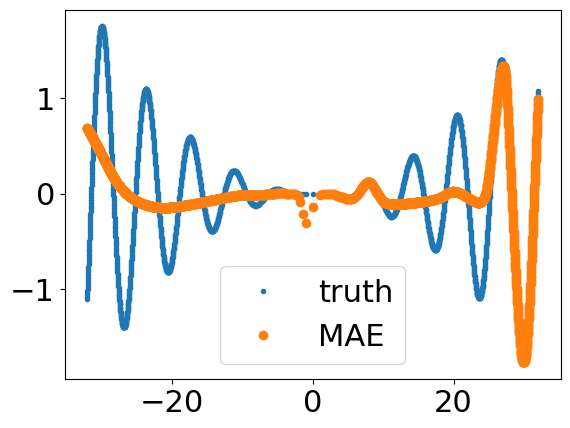

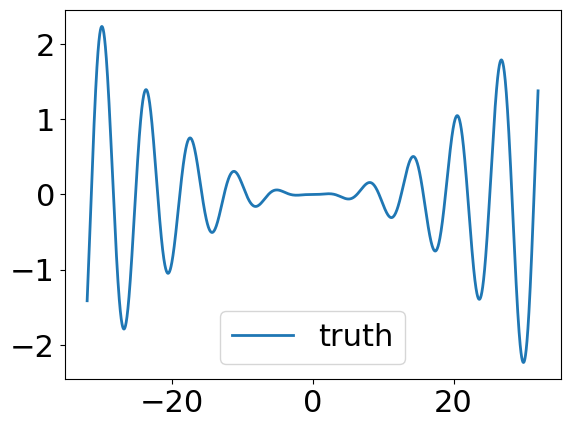

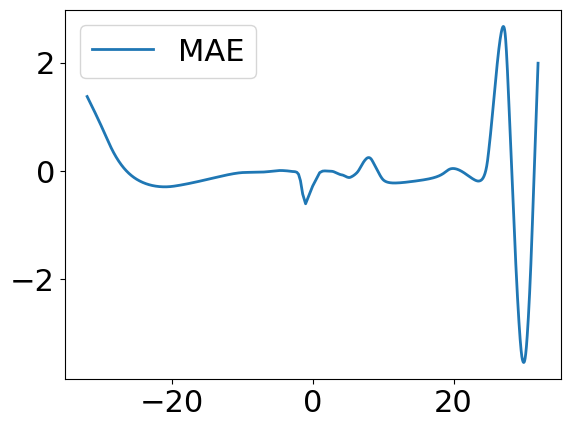

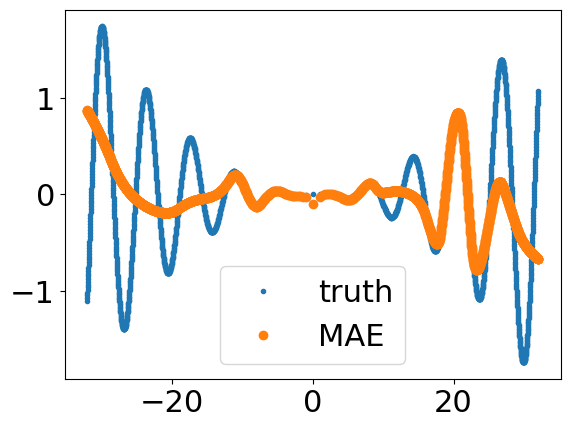

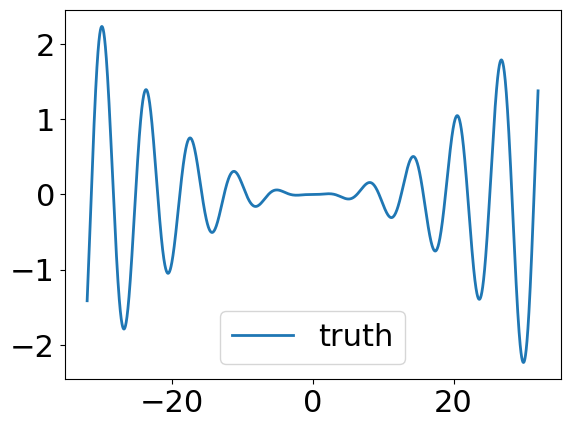

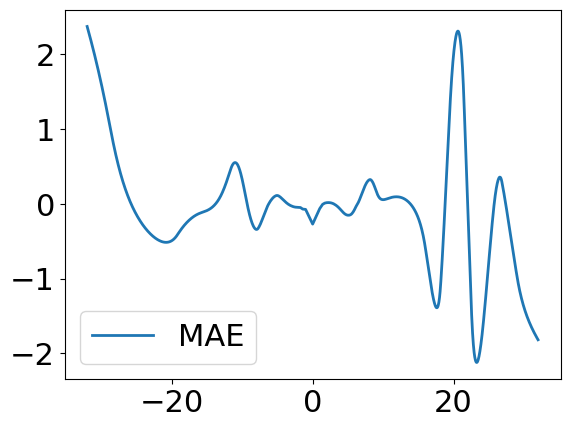

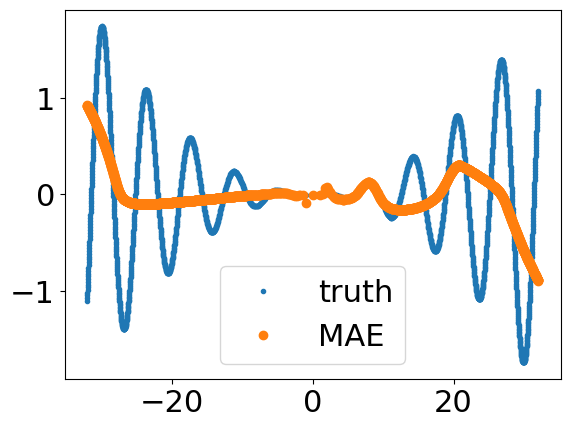

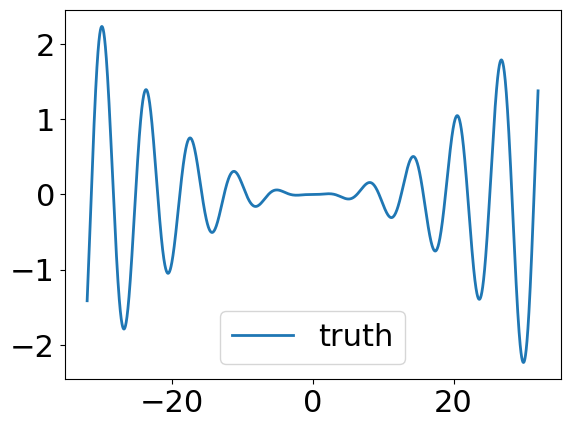

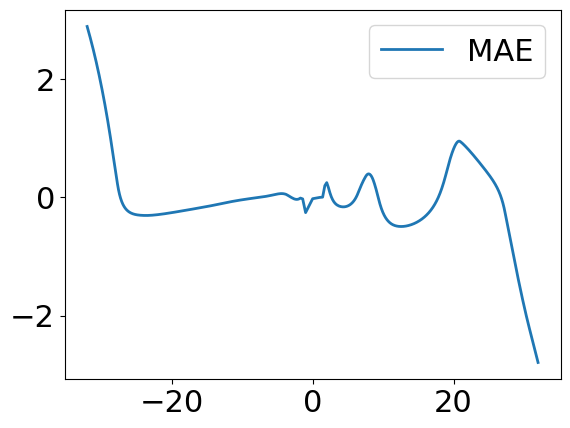

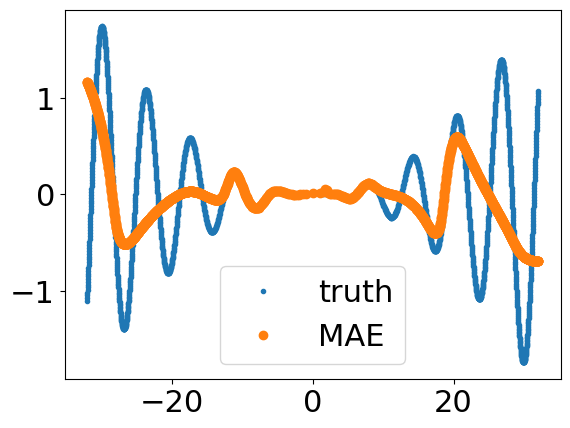

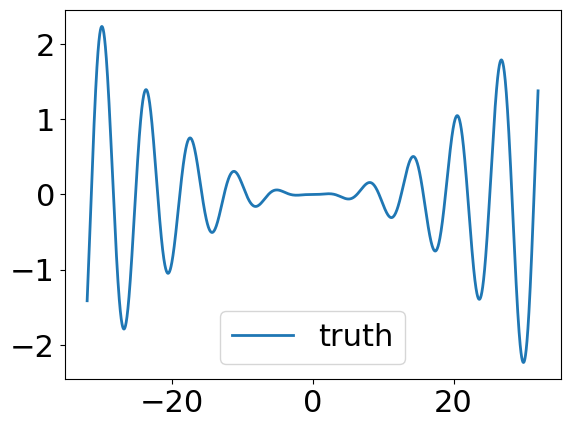

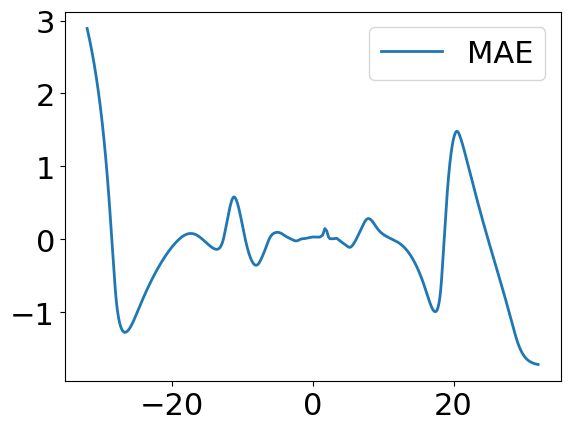

In [6]:
lr = 0.01
decay = 0

seeds = [1,2,3,4,5]
preds_MAE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MAE = torch.nn.L1Loss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MAE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MAE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MAE')
    plt.legend()

    preds_MAE.append(pred_Y)
    


Epoch=0, train_MAE=1.1121, train_RMSE=1.4817, train_Pearson=0.0052, train_Spearman=0.0127, lr=0.0100
test_MAE=0.6258, test_RMSE=0.7852, test_Pearson=0.1564, test_Spearman=0.1183
Epoch=1, train_MAE=0.6608, train_RMSE=0.8313, train_Pearson=-0.0008, train_Spearman=-0.0183, lr=0.0100
test_MAE=0.6178, test_RMSE=0.7915, test_Pearson=0.1839, test_Spearman=0.2011
Epoch=2, train_MAE=0.6462, train_RMSE=0.8074, train_Pearson=0.0204, train_Spearman=0.0109, lr=0.0100
test_MAE=0.6266, test_RMSE=0.8041, test_Pearson=-0.0774, test_Spearman=-0.1139
Epoch=3, train_MAE=0.6307, train_RMSE=0.7922, train_Pearson=0.0495, train_Spearman=0.0345, lr=0.0100
test_MAE=0.6125, test_RMSE=0.7795, test_Pearson=0.2084, test_Spearman=0.1985
Epoch=4, train_MAE=0.6354, train_RMSE=0.7958, train_Pearson=0.0506, train_Spearman=0.0226, lr=0.0100
test_MAE=0.6412, test_RMSE=0.8135, test_Pearson=0.1880, test_Spearman=0.1954
Epoch=5, train_MAE=0.6307, train_RMSE=0.7905, train_Pearson=0.0499, train_Spearman=0.0488, lr=0.0100
test_

Epoch=46, train_MAE=0.6220, train_RMSE=0.7767, train_Pearson=0.1311, train_Spearman=0.0919, lr=0.0100
test_MAE=0.6042, test_RMSE=0.7688, test_Pearson=0.1558, test_Spearman=0.1407
Epoch=47, train_MAE=0.6236, train_RMSE=0.7792, train_Pearson=0.1191, train_Spearman=0.0893, lr=0.0100
test_MAE=0.5995, test_RMSE=0.7710, test_Pearson=0.2150, test_Spearman=0.1661
Epoch=48, train_MAE=0.6175, train_RMSE=0.7749, train_Pearson=0.1308, train_Spearman=0.0979, lr=0.0100
test_MAE=0.5904, test_RMSE=0.7567, test_Pearson=0.2426, test_Spearman=0.2022
Epoch=49, train_MAE=0.6177, train_RMSE=0.7733, train_Pearson=0.1488, train_Spearman=0.1064, lr=0.0100
test_MAE=0.5910, test_RMSE=0.7571, test_Pearson=0.2633, test_Spearman=0.2090
Epoch=50, train_MAE=0.6215, train_RMSE=0.7766, train_Pearson=0.1269, train_Spearman=0.0808, lr=0.0100
test_MAE=0.5894, test_RMSE=0.7546, test_Pearson=0.2637, test_Spearman=0.1985
Epoch=51, train_MAE=0.6156, train_RMSE=0.7723, train_Pearson=0.1648, train_Spearman=0.1087, lr=0.0100
tes

Epoch=92, train_MAE=0.6263, train_RMSE=0.7776, train_Pearson=0.1226, train_Spearman=0.0843, lr=0.0100
test_MAE=0.6103, test_RMSE=0.7753, test_Pearson=0.1877, test_Spearman=0.1654
Epoch=93, train_MAE=0.6234, train_RMSE=0.7778, train_Pearson=0.1163, train_Spearman=0.0807, lr=0.0100
test_MAE=0.5974, test_RMSE=0.7622, test_Pearson=0.2222, test_Spearman=0.1918
Epoch=94, train_MAE=0.6212, train_RMSE=0.7785, train_Pearson=0.0987, train_Spearman=0.0605, lr=0.0100
test_MAE=0.6013, test_RMSE=0.7652, test_Pearson=0.2399, test_Spearman=0.2043
Epoch=95, train_MAE=0.6208, train_RMSE=0.7776, train_Pearson=0.1298, train_Spearman=0.1017, lr=0.0100
test_MAE=0.6035, test_RMSE=0.7767, test_Pearson=0.0994, test_Spearman=0.1095
Epoch=96, train_MAE=0.6267, train_RMSE=0.7851, train_Pearson=0.0165, train_Spearman=0.0065, lr=0.0100
test_MAE=0.5965, test_RMSE=0.7668, test_Pearson=0.2157, test_Spearman=0.2000
Epoch=97, train_MAE=0.6207, train_RMSE=0.7849, train_Pearson=0.0983, train_Spearman=0.0854, lr=0.0100
tes

test_MAE=0.5752, test_RMSE=0.7288, test_Pearson=0.3613, test_Spearman=0.1530
Epoch=138, train_MAE=0.6001, train_RMSE=0.7507, train_Pearson=0.2793, train_Spearman=0.1416, lr=0.0010
test_MAE=0.5768, test_RMSE=0.7330, test_Pearson=0.3490, test_Spearman=0.2042
Epoch=139, train_MAE=0.5972, train_RMSE=0.7473, train_Pearson=0.2973, train_Spearman=0.1680, lr=0.0010
test_MAE=0.5774, test_RMSE=0.7328, test_Pearson=0.3499, test_Spearman=0.2040
Epoch=140, train_MAE=0.5982, train_RMSE=0.7505, train_Pearson=0.2794, train_Spearman=0.1226, lr=0.0010
test_MAE=0.5730, test_RMSE=0.7270, test_Pearson=0.3635, test_Spearman=0.1684
Epoch=141, train_MAE=0.5959, train_RMSE=0.7456, train_Pearson=0.3018, train_Spearman=0.1536, lr=0.0010
test_MAE=0.5722, test_RMSE=0.7246, test_Pearson=0.3727, test_Spearman=0.1664
Epoch=142, train_MAE=0.5972, train_RMSE=0.7479, train_Pearson=0.2907, train_Spearman=0.1438, lr=0.0010
test_MAE=0.5732, test_RMSE=0.7270, test_Pearson=0.3777, test_Spearman=0.2285
Epoch=143, train_MAE=0.

test_MAE=0.5103, test_RMSE=0.6563, test_Pearson=0.5495, test_Spearman=0.4706
Epoch=184, train_MAE=0.5475, train_RMSE=0.6975, train_Pearson=0.4533, train_Spearman=0.3836, lr=0.0010
test_MAE=0.5285, test_RMSE=0.6837, test_Pearson=0.5550, test_Spearman=0.4968
Epoch=185, train_MAE=0.5569, train_RMSE=0.7025, train_Pearson=0.4384, train_Spearman=0.3613, lr=0.0010
test_MAE=0.5072, test_RMSE=0.6511, test_Pearson=0.5667, test_Spearman=0.5070
Epoch=186, train_MAE=0.5418, train_RMSE=0.6908, train_Pearson=0.4740, train_Spearman=0.3943, lr=0.0010
test_MAE=0.5017, test_RMSE=0.6535, test_Pearson=0.5564, test_Spearman=0.5257
Epoch=187, train_MAE=0.5318, train_RMSE=0.6816, train_Pearson=0.4937, train_Spearman=0.3922, lr=0.0010
test_MAE=0.4895, test_RMSE=0.6400, test_Pearson=0.5934, test_Spearman=0.5385
Epoch=188, train_MAE=0.5245, train_RMSE=0.6754, train_Pearson=0.5132, train_Spearman=0.4234, lr=0.0010
test_MAE=0.4938, test_RMSE=0.6379, test_Pearson=0.5926, test_Spearman=0.5079
Epoch=189, train_MAE=0.

test_MAE=0.4156, test_RMSE=0.5701, test_Pearson=0.6959, test_Spearman=0.6867
Epoch=230, train_MAE=0.4451, train_RMSE=0.6032, train_Pearson=0.6449, train_Spearman=0.6426, lr=0.0001
test_MAE=0.4138, test_RMSE=0.5697, test_Pearson=0.6967, test_Spearman=0.6955
Epoch=231, train_MAE=0.4447, train_RMSE=0.6030, train_Pearson=0.6448, train_Spearman=0.6563, lr=0.0001
test_MAE=0.4153, test_RMSE=0.5699, test_Pearson=0.6958, test_Spearman=0.6956
Epoch=232, train_MAE=0.4449, train_RMSE=0.6029, train_Pearson=0.6446, train_Spearman=0.6421, lr=0.0001
test_MAE=0.4109, test_RMSE=0.5676, test_Pearson=0.6987, test_Spearman=0.6916
Epoch=233, train_MAE=0.4428, train_RMSE=0.6017, train_Pearson=0.6470, train_Spearman=0.6525, lr=0.0001
test_MAE=0.4126, test_RMSE=0.5681, test_Pearson=0.6985, test_Spearman=0.6973
Epoch=234, train_MAE=0.4430, train_RMSE=0.6013, train_Pearson=0.6473, train_Spearman=0.6539, lr=0.0001
test_MAE=0.4119, test_RMSE=0.5672, test_Pearson=0.6997, test_Spearman=0.6963
Epoch=235, train_MAE=0.

test_MAE=0.3779, test_RMSE=0.5379, test_Pearson=0.7361, test_Spearman=0.7603
Epoch=276, train_MAE=0.4033, train_RMSE=0.5674, train_Pearson=0.6967, train_Spearman=0.7297, lr=0.0001
test_MAE=0.3762, test_RMSE=0.5364, test_Pearson=0.7378, test_Spearman=0.7615
Epoch=277, train_MAE=0.4024, train_RMSE=0.5668, train_Pearson=0.6979, train_Spearman=0.7390, lr=0.0001
test_MAE=0.3764, test_RMSE=0.5384, test_Pearson=0.7355, test_Spearman=0.7648
Epoch=278, train_MAE=0.4008, train_RMSE=0.5648, train_Pearson=0.7012, train_Spearman=0.7404, lr=0.0001
test_MAE=0.3756, test_RMSE=0.5352, test_Pearson=0.7393, test_Spearman=0.7626
Epoch=279, train_MAE=0.3999, train_RMSE=0.5638, train_Pearson=0.7024, train_Spearman=0.7405, lr=0.0001
test_MAE=0.3747, test_RMSE=0.5356, test_Pearson=0.7390, test_Spearman=0.7657
Epoch=280, train_MAE=0.3990, train_RMSE=0.5638, train_Pearson=0.7025, train_Spearman=0.7416, lr=0.0001
test_MAE=0.3721, test_RMSE=0.5338, test_Pearson=0.7412, test_Spearman=0.7696
Epoch=281, train_MAE=0.

Epoch=21, train_MAE=0.6152, train_RMSE=0.7699, train_Pearson=0.1752, train_Spearman=0.1242, lr=0.0100
test_MAE=0.5955, test_RMSE=0.7628, test_Pearson=0.2526, test_Spearman=0.1981
Epoch=22, train_MAE=0.6159, train_RMSE=0.7707, train_Pearson=0.1751, train_Spearman=0.1170, lr=0.0100
test_MAE=0.5906, test_RMSE=0.7567, test_Pearson=0.2488, test_Spearman=0.2037
Epoch=23, train_MAE=0.6161, train_RMSE=0.7711, train_Pearson=0.1642, train_Spearman=0.1109, lr=0.0100
test_MAE=0.5925, test_RMSE=0.7587, test_Pearson=0.2512, test_Spearman=0.2025
Epoch=24, train_MAE=0.6194, train_RMSE=0.7761, train_Pearson=0.1246, train_Spearman=0.0839, lr=0.0100
test_MAE=0.5969, test_RMSE=0.7637, test_Pearson=0.2498, test_Spearman=0.2019
Epoch=25, train_MAE=0.6173, train_RMSE=0.7736, train_Pearson=0.1432, train_Spearman=0.1028, lr=0.0100
test_MAE=0.5968, test_RMSE=0.7650, test_Pearson=0.2431, test_Spearman=0.2089
Epoch=26, train_MAE=0.6218, train_RMSE=0.7760, train_Pearson=0.1318, train_Spearman=0.0913, lr=0.0100
tes

Epoch=67, train_MAE=0.6157, train_RMSE=0.7690, train_Pearson=0.1805, train_Spearman=0.1312, lr=0.0100
test_MAE=0.5928, test_RMSE=0.7564, test_Pearson=0.2752, test_Spearman=0.2080
Epoch=68, train_MAE=0.6146, train_RMSE=0.7670, train_Pearson=0.1917, train_Spearman=0.1342, lr=0.0100
test_MAE=0.5923, test_RMSE=0.7550, test_Pearson=0.2764, test_Spearman=0.1895
Epoch=69, train_MAE=0.6232, train_RMSE=0.7829, train_Pearson=0.0971, train_Spearman=0.0577, lr=0.0100
test_MAE=0.5928, test_RMSE=0.7556, test_Pearson=0.2847, test_Spearman=0.1832
Epoch=70, train_MAE=0.6136, train_RMSE=0.7684, train_Pearson=0.1882, train_Spearman=0.1388, lr=0.0100
test_MAE=0.6095, test_RMSE=0.7799, test_Pearson=0.2527, test_Spearman=0.1846
Epoch=71, train_MAE=0.6241, train_RMSE=0.7823, train_Pearson=0.1307, train_Spearman=0.0639, lr=0.0100
test_MAE=0.6229, test_RMSE=0.7980, test_Pearson=0.1518, test_Spearman=0.0851
Epoch=72, train_MAE=0.6289, train_RMSE=0.7859, train_Pearson=0.1278, train_Spearman=0.1151, lr=0.0100
tes

Epoch=113, train_MAE=0.6158, train_RMSE=0.7704, train_Pearson=0.1719, train_Spearman=0.1168, lr=0.0010
test_MAE=0.5927, test_RMSE=0.7577, test_Pearson=0.2550, test_Spearman=0.2000
Epoch=114, train_MAE=0.6135, train_RMSE=0.7675, train_Pearson=0.1921, train_Spearman=0.1290, lr=0.0010
test_MAE=0.5894, test_RMSE=0.7543, test_Pearson=0.2529, test_Spearman=0.2010
Epoch=115, train_MAE=0.6147, train_RMSE=0.7695, train_Pearson=0.1741, train_Spearman=0.1166, lr=0.0010
test_MAE=0.5901, test_RMSE=0.7550, test_Pearson=0.2538, test_Spearman=0.2013
Epoch=116, train_MAE=0.6137, train_RMSE=0.7675, train_Pearson=0.1885, train_Spearman=0.1243, lr=0.0010
test_MAE=0.5900, test_RMSE=0.7544, test_Pearson=0.2564, test_Spearman=0.2030
Epoch=117, train_MAE=0.6146, train_RMSE=0.7680, train_Pearson=0.1877, train_Spearman=0.1251, lr=0.0010
test_MAE=0.5919, test_RMSE=0.7559, test_Pearson=0.2587, test_Spearman=0.2004
Epoch=118, train_MAE=0.6145, train_RMSE=0.7678, train_Pearson=0.1880, train_Spearman=0.1255, lr=0.00

test_MAE=0.5871, test_RMSE=0.7475, test_Pearson=0.2942, test_Spearman=0.1751
Epoch=159, train_MAE=0.6096, train_RMSE=0.7634, train_Pearson=0.2175, train_Spearman=0.1416, lr=0.0010
test_MAE=0.5862, test_RMSE=0.7464, test_Pearson=0.2920, test_Spearman=0.2204
Epoch=160, train_MAE=0.6104, train_RMSE=0.7637, train_Pearson=0.2235, train_Spearman=0.1239, lr=0.0010
test_MAE=0.5903, test_RMSE=0.7513, test_Pearson=0.2882, test_Spearman=0.1858
Epoch=161, train_MAE=0.6107, train_RMSE=0.7613, train_Pearson=0.2285, train_Spearman=0.1426, lr=0.0010
test_MAE=0.5865, test_RMSE=0.7459, test_Pearson=0.2904, test_Spearman=0.2183
Epoch=162, train_MAE=0.6116, train_RMSE=0.7639, train_Pearson=0.2164, train_Spearman=0.1346, lr=0.0010
test_MAE=0.5899, test_RMSE=0.7505, test_Pearson=0.2936, test_Spearman=0.1367
Epoch=163, train_MAE=0.6100, train_RMSE=0.7639, train_Pearson=0.2190, train_Spearman=0.1125, lr=0.0010
test_MAE=0.5861, test_RMSE=0.7460, test_Pearson=0.2883, test_Spearman=0.2185
Epoch=164, train_MAE=0.

test_MAE=0.5826, test_RMSE=0.7386, test_Pearson=0.3300, test_Spearman=0.1327
Epoch=205, train_MAE=0.6014, train_RMSE=0.7525, train_Pearson=0.2722, train_Spearman=0.1026, lr=0.0001
test_MAE=0.5817, test_RMSE=0.7376, test_Pearson=0.3275, test_Spearman=0.1305
Epoch=206, train_MAE=0.6013, train_RMSE=0.7529, train_Pearson=0.2691, train_Spearman=0.1074, lr=0.0001
test_MAE=0.5818, test_RMSE=0.7377, test_Pearson=0.3272, test_Spearman=0.1324
Epoch=207, train_MAE=0.6016, train_RMSE=0.7528, train_Pearson=0.2710, train_Spearman=0.1061, lr=0.0001
test_MAE=0.5822, test_RMSE=0.7380, test_Pearson=0.3325, test_Spearman=0.1293
Epoch=208, train_MAE=0.6018, train_RMSE=0.7526, train_Pearson=0.2734, train_Spearman=0.1063, lr=0.0001
test_MAE=0.5827, test_RMSE=0.7386, test_Pearson=0.3318, test_Spearman=0.1346
Epoch=209, train_MAE=0.6014, train_RMSE=0.7522, train_Pearson=0.2759, train_Spearman=0.1111, lr=0.0001
test_MAE=0.5822, test_RMSE=0.7379, test_Pearson=0.3328, test_Spearman=0.1347
Epoch=210, train_MAE=0.

test_MAE=0.5806, test_RMSE=0.7356, test_Pearson=0.3351, test_Spearman=0.1245
Epoch=251, train_MAE=0.5996, train_RMSE=0.7505, train_Pearson=0.2799, train_Spearman=0.1018, lr=0.0001
test_MAE=0.5804, test_RMSE=0.7351, test_Pearson=0.3384, test_Spearman=0.1255
Epoch=252, train_MAE=0.6001, train_RMSE=0.7506, train_Pearson=0.2817, train_Spearman=0.1027, lr=0.0001
test_MAE=0.5814, test_RMSE=0.7362, test_Pearson=0.3418, test_Spearman=0.1318
Epoch=253, train_MAE=0.6005, train_RMSE=0.7510, train_Pearson=0.2799, train_Spearman=0.1065, lr=0.0001
test_MAE=0.5805, test_RMSE=0.7352, test_Pearson=0.3403, test_Spearman=0.1268
Epoch=254, train_MAE=0.5999, train_RMSE=0.7504, train_Pearson=0.2825, train_Spearman=0.1054, lr=0.0001
test_MAE=0.5806, test_RMSE=0.7352, test_Pearson=0.3419, test_Spearman=0.1312
Epoch=255, train_MAE=0.6000, train_RMSE=0.7503, train_Pearson=0.2834, train_Spearman=0.1091, lr=0.0001
test_MAE=0.5808, test_RMSE=0.7355, test_Pearson=0.3418, test_Spearman=0.1324
Epoch=256, train_MAE=0.

test_MAE=0.5793, test_RMSE=0.7330, test_Pearson=0.3469, test_Spearman=0.1172
Epoch=297, train_MAE=0.5982, train_RMSE=0.7484, train_Pearson=0.2895, train_Spearman=0.0952, lr=0.0001
test_MAE=0.5791, test_RMSE=0.7329, test_Pearson=0.3468, test_Spearman=0.1174
Epoch=298, train_MAE=0.5984, train_RMSE=0.7483, train_Pearson=0.2906, train_Spearman=0.0967, lr=0.0001
test_MAE=0.5793, test_RMSE=0.7330, test_Pearson=0.3486, test_Spearman=0.1209
Epoch=299, train_MAE=0.5987, train_RMSE=0.7485, train_Pearson=0.2918, train_Spearman=0.1064, lr=0.0001
test_MAE=0.5798, test_RMSE=0.7335, test_Pearson=0.3509, test_Spearman=0.1317
torch.Size([128, 1])
torch.Size([2048, 1])
Epoch=0, train_MAE=1.7688, train_RMSE=2.6645, train_Pearson=-0.0065, train_Spearman=-0.0550, lr=0.0100
test_MAE=0.6223, test_RMSE=0.7856, test_Pearson=-0.0130, test_Spearman=-0.0768
Epoch=1, train_MAE=0.6505, train_RMSE=0.8168, train_Pearson=0.0202, train_Spearman=0.0048, lr=0.0100
test_MAE=0.6553, test_RMSE=0.8113, test_Pearson=0.1767, t

test_MAE=0.5892, test_RMSE=0.7554, test_Pearson=0.2504, test_Spearman=0.2079
Epoch=43, train_MAE=0.6148, train_RMSE=0.7696, train_Pearson=0.1740, train_Spearman=0.1176, lr=0.0100
test_MAE=0.5902, test_RMSE=0.7557, test_Pearson=0.2567, test_Spearman=0.1973
Epoch=44, train_MAE=0.6146, train_RMSE=0.7693, train_Pearson=0.1788, train_Spearman=0.1283, lr=0.0100
test_MAE=0.5930, test_RMSE=0.7603, test_Pearson=0.2505, test_Spearman=0.1880
Epoch=45, train_MAE=0.6160, train_RMSE=0.7725, train_Pearson=0.1547, train_Spearman=0.1027, lr=0.0100
test_MAE=0.5961, test_RMSE=0.7600, test_Pearson=0.2641, test_Spearman=0.1936
Epoch=46, train_MAE=0.6177, train_RMSE=0.7735, train_Pearson=0.1558, train_Spearman=0.1068, lr=0.0100
test_MAE=0.5970, test_RMSE=0.7650, test_Pearson=0.2541, test_Spearman=0.2127
Epoch=47, train_MAE=0.6188, train_RMSE=0.7750, train_Pearson=0.1325, train_Spearman=0.1051, lr=0.0100
test_MAE=0.5964, test_RMSE=0.7605, test_Pearson=0.2511, test_Spearman=0.2102
Epoch=48, train_MAE=0.6150, 

test_MAE=0.5909, test_RMSE=0.7654, test_Pearson=0.2418, test_Spearman=0.1732
Epoch=89, train_MAE=0.6162, train_RMSE=0.7745, train_Pearson=0.1441, train_Spearman=0.1237, lr=0.0100
test_MAE=0.5882, test_RMSE=0.7504, test_Pearson=0.2802, test_Spearman=0.2021
Epoch=90, train_MAE=0.6122, train_RMSE=0.7675, train_Pearson=0.1983, train_Spearman=0.1175, lr=0.0100
test_MAE=0.5946, test_RMSE=0.7611, test_Pearson=0.2877, test_Spearman=0.2202
Epoch=91, train_MAE=0.6105, train_RMSE=0.7717, train_Pearson=0.1674, train_Spearman=0.1157, lr=0.0100
test_MAE=0.5933, test_RMSE=0.7627, test_Pearson=0.2541, test_Spearman=0.1835
Epoch=92, train_MAE=0.6152, train_RMSE=0.7726, train_Pearson=0.1527, train_Spearman=0.1112, lr=0.0100
test_MAE=0.5903, test_RMSE=0.7544, test_Pearson=0.2889, test_Spearman=0.1655
Epoch=93, train_MAE=0.6135, train_RMSE=0.7708, train_Pearson=0.1748, train_Spearman=0.1146, lr=0.0100
test_MAE=0.5876, test_RMSE=0.7535, test_Pearson=0.2673, test_Spearman=0.1657
Epoch=94, train_MAE=0.6127, 

test_MAE=0.5859, test_RMSE=0.7443, test_Pearson=0.3010, test_Spearman=0.1487
Epoch=135, train_MAE=0.6072, train_RMSE=0.7598, train_Pearson=0.2393, train_Spearman=0.1300, lr=0.0010
test_MAE=0.5893, test_RMSE=0.7488, test_Pearson=0.3082, test_Spearman=0.1398
Epoch=136, train_MAE=0.6059, train_RMSE=0.7608, train_Pearson=0.2332, train_Spearman=0.1433, lr=0.0010
test_MAE=0.5851, test_RMSE=0.7427, test_Pearson=0.3100, test_Spearman=0.1349
Epoch=137, train_MAE=0.6079, train_RMSE=0.7614, train_Pearson=0.2278, train_Spearman=0.1306, lr=0.0010
test_MAE=0.5868, test_RMSE=0.7480, test_Pearson=0.2862, test_Spearman=0.2091
Epoch=138, train_MAE=0.6053, train_RMSE=0.7587, train_Pearson=0.2394, train_Spearman=0.1476, lr=0.0010
test_MAE=0.5868, test_RMSE=0.7452, test_Pearson=0.3098, test_Spearman=0.1644
Epoch=139, train_MAE=0.6082, train_RMSE=0.7612, train_Pearson=0.2270, train_Spearman=0.1218, lr=0.0010
test_MAE=0.5892, test_RMSE=0.7491, test_Pearson=0.3067, test_Spearman=0.1441
Epoch=140, train_MAE=0.

test_MAE=0.5832, test_RMSE=0.7401, test_Pearson=0.3258, test_Spearman=0.1312
Epoch=181, train_MAE=0.6004, train_RMSE=0.7517, train_Pearson=0.2800, train_Spearman=0.1305, lr=0.0010
test_MAE=0.5785, test_RMSE=0.7330, test_Pearson=0.3411, test_Spearman=0.1676
Epoch=182, train_MAE=0.5988, train_RMSE=0.7513, train_Pearson=0.2769, train_Spearman=0.1694, lr=0.0010
test_MAE=0.5808, test_RMSE=0.7364, test_Pearson=0.3214, test_Spearman=0.1490
Epoch=183, train_MAE=0.5979, train_RMSE=0.7525, train_Pearson=0.2706, train_Spearman=0.1276, lr=0.0010
test_MAE=0.5853, test_RMSE=0.7450, test_Pearson=0.3197, test_Spearman=0.2210
Epoch=184, train_MAE=0.6073, train_RMSE=0.7608, train_Pearson=0.2379, train_Spearman=0.1086, lr=0.0010
test_MAE=0.5820, test_RMSE=0.7417, test_Pearson=0.3124, test_Spearman=0.1807
Epoch=185, train_MAE=0.6049, train_RMSE=0.7611, train_Pearson=0.2356, train_Spearman=0.1196, lr=0.0010
test_MAE=0.5838, test_RMSE=0.7406, test_Pearson=0.3148, test_Spearman=0.1683
Epoch=186, train_MAE=0.

test_MAE=0.5720, test_RMSE=0.7242, test_Pearson=0.3749, test_Spearman=0.1931
Epoch=227, train_MAE=0.5915, train_RMSE=0.7422, train_Pearson=0.3150, train_Spearman=0.1759, lr=0.0001
test_MAE=0.5722, test_RMSE=0.7243, test_Pearson=0.3767, test_Spearman=0.2122
Epoch=228, train_MAE=0.5909, train_RMSE=0.7417, train_Pearson=0.3161, train_Spearman=0.1708, lr=0.0001
test_MAE=0.5723, test_RMSE=0.7247, test_Pearson=0.3721, test_Spearman=0.1893
Epoch=229, train_MAE=0.5907, train_RMSE=0.7416, train_Pearson=0.3161, train_Spearman=0.1640, lr=0.0001
test_MAE=0.5718, test_RMSE=0.7240, test_Pearson=0.3754, test_Spearman=0.1948
Epoch=230, train_MAE=0.5911, train_RMSE=0.7417, train_Pearson=0.3169, train_Spearman=0.1748, lr=0.0001
test_MAE=0.5720, test_RMSE=0.7243, test_Pearson=0.3774, test_Spearman=0.2096
Epoch=231, train_MAE=0.5910, train_RMSE=0.7415, train_Pearson=0.3174, train_Spearman=0.1789, lr=0.0001
test_MAE=0.5719, test_RMSE=0.7239, test_Pearson=0.3756, test_Spearman=0.2022
Epoch=232, train_MAE=0.

test_MAE=0.5681, test_RMSE=0.7190, test_Pearson=0.3938, test_Spearman=0.2281
Epoch=273, train_MAE=0.5878, train_RMSE=0.7378, train_Pearson=0.3313, train_Spearman=0.1910, lr=0.0001
test_MAE=0.5677, test_RMSE=0.7185, test_Pearson=0.3939, test_Spearman=0.2213
Epoch=274, train_MAE=0.5884, train_RMSE=0.7385, train_Pearson=0.3284, train_Spearman=0.1778, lr=0.0001
test_MAE=0.5677, test_RMSE=0.7187, test_Pearson=0.3946, test_Spearman=0.2133
Epoch=275, train_MAE=0.5894, train_RMSE=0.7393, train_Pearson=0.3266, train_Spearman=0.2002, lr=0.0001
test_MAE=0.5682, test_RMSE=0.7190, test_Pearson=0.3976, test_Spearman=0.2476
Epoch=276, train_MAE=0.5877, train_RMSE=0.7380, train_Pearson=0.3302, train_Spearman=0.1882, lr=0.0001
test_MAE=0.5681, test_RMSE=0.7191, test_Pearson=0.3887, test_Spearman=0.2076
Epoch=277, train_MAE=0.5874, train_RMSE=0.7374, train_Pearson=0.3318, train_Spearman=0.1744, lr=0.0001
test_MAE=0.5670, test_RMSE=0.7175, test_Pearson=0.3986, test_Spearman=0.2315
Epoch=278, train_MAE=0.

Epoch=18, train_MAE=0.6221, train_RMSE=0.7774, train_Pearson=0.1192, train_Spearman=0.0805, lr=0.0100
test_MAE=0.6091, test_RMSE=0.7770, test_Pearson=0.2394, test_Spearman=0.2025
Epoch=19, train_MAE=0.6272, train_RMSE=0.7848, train_Pearson=0.0690, train_Spearman=0.0295, lr=0.0100
test_MAE=0.5960, test_RMSE=0.7688, test_Pearson=0.2173, test_Spearman=0.2005
Epoch=20, train_MAE=0.6197, train_RMSE=0.7778, train_Pearson=0.1120, train_Spearman=0.0949, lr=0.0100
test_MAE=0.5911, test_RMSE=0.7586, test_Pearson=0.2425, test_Spearman=0.2018
Epoch=21, train_MAE=0.6224, train_RMSE=0.7820, train_Pearson=0.1030, train_Spearman=0.0645, lr=0.0100
test_MAE=0.6094, test_RMSE=0.7813, test_Pearson=0.2443, test_Spearman=0.1955
Epoch=22, train_MAE=0.6268, train_RMSE=0.7872, train_Pearson=0.0714, train_Spearman=0.0465, lr=0.0100
test_MAE=0.5941, test_RMSE=0.7611, test_Pearson=0.2365, test_Spearman=0.2010
Epoch=23, train_MAE=0.6296, train_RMSE=0.7869, train_Pearson=0.1023, train_Spearman=0.0642, lr=0.0100
tes

Epoch=64, train_MAE=0.6243, train_RMSE=0.7780, train_Pearson=0.1197, train_Spearman=0.0792, lr=0.0100
test_MAE=0.5971, test_RMSE=0.7611, test_Pearson=0.2271, test_Spearman=0.1755
Epoch=65, train_MAE=0.6196, train_RMSE=0.7743, train_Pearson=0.1618, train_Spearman=0.0870, lr=0.0100
test_MAE=0.5918, test_RMSE=0.7581, test_Pearson=0.2760, test_Spearman=0.2005
Epoch=66, train_MAE=0.6130, train_RMSE=0.7692, train_Pearson=0.2058, train_Spearman=0.1306, lr=0.0100
test_MAE=0.5890, test_RMSE=0.7531, test_Pearson=0.2687, test_Spearman=0.2037
Epoch=67, train_MAE=0.6140, train_RMSE=0.7696, train_Pearson=0.1849, train_Spearman=0.1097, lr=0.0100
test_MAE=0.5977, test_RMSE=0.7663, test_Pearson=0.2450, test_Spearman=0.1560
Epoch=68, train_MAE=0.6166, train_RMSE=0.7764, train_Pearson=0.1235, train_Spearman=0.0943, lr=0.0100
test_MAE=0.5952, test_RMSE=0.7625, test_Pearson=0.1980, test_Spearman=0.0903
Epoch=69, train_MAE=0.6287, train_RMSE=0.7884, train_Pearson=0.1124, train_Spearman=0.0690, lr=0.0100
tes

Epoch=110, train_MAE=0.6111, train_RMSE=0.7645, train_Pearson=0.2105, train_Spearman=0.1444, lr=0.0010
test_MAE=0.5898, test_RMSE=0.7522, test_Pearson=0.2719, test_Spearman=0.1871
Epoch=111, train_MAE=0.6111, train_RMSE=0.7644, train_Pearson=0.2106, train_Spearman=0.1386, lr=0.0010
test_MAE=0.5907, test_RMSE=0.7531, test_Pearson=0.2681, test_Spearman=0.2015
Epoch=112, train_MAE=0.6104, train_RMSE=0.7641, train_Pearson=0.2120, train_Spearman=0.1398, lr=0.0010
test_MAE=0.5891, test_RMSE=0.7517, test_Pearson=0.2756, test_Spearman=0.1833
Epoch=113, train_MAE=0.6104, train_RMSE=0.7637, train_Pearson=0.2183, train_Spearman=0.1346, lr=0.0010
test_MAE=0.5893, test_RMSE=0.7515, test_Pearson=0.2771, test_Spearman=0.1869
Epoch=114, train_MAE=0.6099, train_RMSE=0.7634, train_Pearson=0.2152, train_Spearman=0.1512, lr=0.0010
test_MAE=0.5881, test_RMSE=0.7502, test_Pearson=0.2728, test_Spearman=0.2141
Epoch=115, train_MAE=0.6104, train_RMSE=0.7645, train_Pearson=0.2089, train_Spearman=0.1432, lr=0.00

test_MAE=0.5851, test_RMSE=0.7430, test_Pearson=0.3094, test_Spearman=0.1420
Epoch=156, train_MAE=0.6052, train_RMSE=0.7578, train_Pearson=0.2502, train_Spearman=0.1172, lr=0.0010
test_MAE=0.5847, test_RMSE=0.7425, test_Pearson=0.3114, test_Spearman=0.1374
Epoch=157, train_MAE=0.6065, train_RMSE=0.7598, train_Pearson=0.2387, train_Spearman=0.1273, lr=0.0010
test_MAE=0.5858, test_RMSE=0.7443, test_Pearson=0.3052, test_Spearman=0.1503
Epoch=158, train_MAE=0.6069, train_RMSE=0.7625, train_Pearson=0.2293, train_Spearman=0.1254, lr=0.0010
test_MAE=0.5846, test_RMSE=0.7424, test_Pearson=0.3108, test_Spearman=0.1418
Epoch=159, train_MAE=0.6065, train_RMSE=0.7607, train_Pearson=0.2384, train_Spearman=0.1334, lr=0.0010
test_MAE=0.5904, test_RMSE=0.7519, test_Pearson=0.2865, test_Spearman=0.1617
Epoch=160, train_MAE=0.6080, train_RMSE=0.7609, train_Pearson=0.2309, train_Spearman=0.1235, lr=0.0010
test_MAE=0.5838, test_RMSE=0.7419, test_Pearson=0.3075, test_Spearman=0.1605
Epoch=161, train_MAE=0.

test_MAE=0.5811, test_RMSE=0.7349, test_Pearson=0.3391, test_Spearman=0.1217
Epoch=202, train_MAE=0.5981, train_RMSE=0.7486, train_Pearson=0.2908, train_Spearman=0.1180, lr=0.0001
test_MAE=0.5811, test_RMSE=0.7353, test_Pearson=0.3391, test_Spearman=0.1232
Epoch=203, train_MAE=0.5978, train_RMSE=0.7485, train_Pearson=0.2905, train_Spearman=0.1154, lr=0.0001
test_MAE=0.5802, test_RMSE=0.7341, test_Pearson=0.3389, test_Spearman=0.1173
Epoch=204, train_MAE=0.5976, train_RMSE=0.7483, train_Pearson=0.2900, train_Spearman=0.1078, lr=0.0001
test_MAE=0.5798, test_RMSE=0.7335, test_Pearson=0.3409, test_Spearman=0.1172
Epoch=205, train_MAE=0.5974, train_RMSE=0.7483, train_Pearson=0.2898, train_Spearman=0.1047, lr=0.0001
test_MAE=0.5800, test_RMSE=0.7338, test_Pearson=0.3403, test_Spearman=0.1167
Epoch=206, train_MAE=0.5973, train_RMSE=0.7479, train_Pearson=0.2917, train_Spearman=0.1058, lr=0.0001
test_MAE=0.5797, test_RMSE=0.7335, test_Pearson=0.3409, test_Spearman=0.1159
Epoch=207, train_MAE=0.

test_MAE=0.5774, test_RMSE=0.7298, test_Pearson=0.3520, test_Spearman=0.1257
Epoch=248, train_MAE=0.5954, train_RMSE=0.7449, train_Pearson=0.3042, train_Spearman=0.1287, lr=0.0001
test_MAE=0.5783, test_RMSE=0.7309, test_Pearson=0.3518, test_Spearman=0.1406
Epoch=249, train_MAE=0.5958, train_RMSE=0.7457, train_Pearson=0.3002, train_Spearman=0.1240, lr=0.0001
test_MAE=0.5774, test_RMSE=0.7298, test_Pearson=0.3517, test_Spearman=0.1260
Epoch=250, train_MAE=0.5952, train_RMSE=0.7448, train_Pearson=0.3039, train_Spearman=0.1206, lr=0.0001
test_MAE=0.5775, test_RMSE=0.7297, test_Pearson=0.3546, test_Spearman=0.1388
Epoch=251, train_MAE=0.5955, train_RMSE=0.7447, train_Pearson=0.3064, train_Spearman=0.1399, lr=0.0001
test_MAE=0.5782, test_RMSE=0.7306, test_Pearson=0.3542, test_Spearman=0.1496
Epoch=252, train_MAE=0.5950, train_RMSE=0.7443, train_Pearson=0.3072, train_Spearman=0.1381, lr=0.0001
test_MAE=0.5774, test_RMSE=0.7296, test_Pearson=0.3538, test_Spearman=0.1355
Epoch=253, train_MAE=0.

test_MAE=0.5750, test_RMSE=0.7264, test_Pearson=0.3644, test_Spearman=0.1760
Epoch=294, train_MAE=0.5924, train_RMSE=0.7411, train_Pearson=0.3191, train_Spearman=0.1754, lr=0.0001
test_MAE=0.5748, test_RMSE=0.7261, test_Pearson=0.3638, test_Spearman=0.1673
Epoch=295, train_MAE=0.5922, train_RMSE=0.7415, train_Pearson=0.3167, train_Spearman=0.1692, lr=0.0001
test_MAE=0.5752, test_RMSE=0.7266, test_Pearson=0.3623, test_Spearman=0.1698
Epoch=296, train_MAE=0.5921, train_RMSE=0.7410, train_Pearson=0.3192, train_Spearman=0.1750, lr=0.0001
test_MAE=0.5749, test_RMSE=0.7261, test_Pearson=0.3643, test_Spearman=0.1710
Epoch=297, train_MAE=0.5922, train_RMSE=0.7409, train_Pearson=0.3197, train_Spearman=0.1761, lr=0.0001
test_MAE=0.5748, test_RMSE=0.7261, test_Pearson=0.3654, test_Spearman=0.1771
Epoch=298, train_MAE=0.5922, train_RMSE=0.7408, train_Pearson=0.3198, train_Spearman=0.1747, lr=0.0001
test_MAE=0.5747, test_RMSE=0.7259, test_Pearson=0.3651, test_Spearman=0.1712
Epoch=299, train_MAE=0.

test_MAE=0.5893, test_RMSE=0.7552, test_Pearson=0.2422, test_Spearman=0.2055
Epoch=40, train_MAE=0.6183, train_RMSE=0.7757, train_Pearson=0.1587, train_Spearman=0.1136, lr=0.0100
test_MAE=0.5978, test_RMSE=0.7651, test_Pearson=0.2311, test_Spearman=0.1813
Epoch=41, train_MAE=0.6208, train_RMSE=0.7794, train_Pearson=0.0784, train_Spearman=0.0634, lr=0.0100
test_MAE=0.5913, test_RMSE=0.7587, test_Pearson=0.2337, test_Spearman=0.1994
Epoch=42, train_MAE=0.6210, train_RMSE=0.7799, train_Pearson=0.1280, train_Spearman=0.0970, lr=0.0100
test_MAE=0.6032, test_RMSE=0.7757, test_Pearson=0.2225, test_Spearman=0.2045
Epoch=43, train_MAE=0.6248, train_RMSE=0.7842, train_Pearson=0.0686, train_Spearman=0.0407, lr=0.0100
test_MAE=0.5983, test_RMSE=0.7681, test_Pearson=0.2467, test_Spearman=0.1952
Epoch=44, train_MAE=0.6240, train_RMSE=0.7850, train_Pearson=0.0853, train_Spearman=0.0644, lr=0.0100
test_MAE=0.5968, test_RMSE=0.7640, test_Pearson=0.2201, test_Spearman=0.2014
Epoch=45, train_MAE=0.6193, 

test_MAE=0.6048, test_RMSE=0.7730, test_Pearson=0.1177, test_Spearman=0.0853
Epoch=86, train_MAE=0.6183, train_RMSE=0.7759, train_Pearson=0.1236, train_Spearman=0.0828, lr=0.0100
test_MAE=0.5919, test_RMSE=0.7572, test_Pearson=0.2335, test_Spearman=0.2008
Epoch=87, train_MAE=0.6229, train_RMSE=0.7813, train_Pearson=0.0791, train_Spearman=0.0636, lr=0.0100
test_MAE=0.5984, test_RMSE=0.7676, test_Pearson=0.2544, test_Spearman=0.1974
Epoch=88, train_MAE=0.6172, train_RMSE=0.7731, train_Pearson=0.1529, train_Spearman=0.1098, lr=0.0100
test_MAE=0.5918, test_RMSE=0.7625, test_Pearson=0.2340, test_Spearman=0.2013
Epoch=89, train_MAE=0.6111, train_RMSE=0.7679, train_Pearson=0.1914, train_Spearman=0.1445, lr=0.0100
test_MAE=0.5986, test_RMSE=0.7675, test_Pearson=0.2439, test_Spearman=0.1622
Epoch=90, train_MAE=0.6199, train_RMSE=0.7766, train_Pearson=0.1337, train_Spearman=0.1068, lr=0.0100
test_MAE=0.6095, test_RMSE=0.7726, test_Pearson=0.2415, test_Spearman=0.1985
Epoch=91, train_MAE=0.6261, 

test_MAE=0.5809, test_RMSE=0.7360, test_Pearson=0.3394, test_Spearman=0.1040
Epoch=132, train_MAE=0.6031, train_RMSE=0.7530, train_Pearson=0.2724, train_Spearman=0.0730, lr=0.0010
test_MAE=0.5814, test_RMSE=0.7374, test_Pearson=0.3225, test_Spearman=0.1051
Epoch=133, train_MAE=0.6019, train_RMSE=0.7529, train_Pearson=0.2702, train_Spearman=0.0959, lr=0.0010
test_MAE=0.5806, test_RMSE=0.7354, test_Pearson=0.3480, test_Spearman=0.1271
Epoch=134, train_MAE=0.6000, train_RMSE=0.7507, train_Pearson=0.2798, train_Spearman=0.0840, lr=0.0010
test_MAE=0.5790, test_RMSE=0.7334, test_Pearson=0.3368, test_Spearman=0.0992
Epoch=135, train_MAE=0.5997, train_RMSE=0.7500, train_Pearson=0.2811, train_Spearman=0.0674, lr=0.0010
test_MAE=0.5848, test_RMSE=0.7417, test_Pearson=0.3383, test_Spearman=0.1813
Epoch=136, train_MAE=0.6065, train_RMSE=0.7587, train_Pearson=0.2498, train_Spearman=0.1590, lr=0.0010
test_MAE=0.5795, test_RMSE=0.7343, test_Pearson=0.3347, test_Spearman=0.1066
Epoch=137, train_MAE=0.

test_MAE=0.5727, test_RMSE=0.7235, test_Pearson=0.3763, test_Spearman=0.1830
Epoch=178, train_MAE=0.5985, train_RMSE=0.7483, train_Pearson=0.2886, train_Spearman=0.1672, lr=0.0010
test_MAE=0.5775, test_RMSE=0.7319, test_Pearson=0.3757, test_Spearman=0.3335
Epoch=179, train_MAE=0.5957, train_RMSE=0.7459, train_Pearson=0.2992, train_Spearman=0.1792, lr=0.0010
test_MAE=0.5712, test_RMSE=0.7213, test_Pearson=0.3818, test_Spearman=0.1908
Epoch=180, train_MAE=0.5948, train_RMSE=0.7426, train_Pearson=0.3181, train_Spearman=0.2539, lr=0.0010
test_MAE=0.5707, test_RMSE=0.7207, test_Pearson=0.3876, test_Spearman=0.2058
Epoch=181, train_MAE=0.5951, train_RMSE=0.7437, train_Pearson=0.3076, train_Spearman=0.1749, lr=0.0010
test_MAE=0.5708, test_RMSE=0.7216, test_Pearson=0.3900, test_Spearman=0.2556
Epoch=182, train_MAE=0.5913, train_RMSE=0.7397, train_Pearson=0.3235, train_Spearman=0.2050, lr=0.0010
test_MAE=0.5675, test_RMSE=0.7165, test_Pearson=0.4034, test_Spearman=0.2688
Epoch=183, train_MAE=0.

test_MAE=0.5557, test_RMSE=0.7018, test_Pearson=0.4452, test_Spearman=0.3568
Epoch=224, train_MAE=0.5815, train_RMSE=0.7268, train_Pearson=0.3691, train_Spearman=0.3084, lr=0.0001
test_MAE=0.5555, test_RMSE=0.7016, test_Pearson=0.4459, test_Spearman=0.3660
Epoch=225, train_MAE=0.5813, train_RMSE=0.7269, train_Pearson=0.3684, train_Spearman=0.2973, lr=0.0001
test_MAE=0.5554, test_RMSE=0.7013, test_Pearson=0.4449, test_Spearman=0.3494
Epoch=226, train_MAE=0.5815, train_RMSE=0.7267, train_Pearson=0.3696, train_Spearman=0.3029, lr=0.0001
test_MAE=0.5560, test_RMSE=0.7023, test_Pearson=0.4452, test_Spearman=0.3659
Epoch=227, train_MAE=0.5816, train_RMSE=0.7269, train_Pearson=0.3703, train_Spearman=0.3313, lr=0.0001
test_MAE=0.5557, test_RMSE=0.7021, test_Pearson=0.4480, test_Spearman=0.3826
Epoch=228, train_MAE=0.5818, train_RMSE=0.7273, train_Pearson=0.3671, train_Spearman=0.3020, lr=0.0001
test_MAE=0.5548, test_RMSE=0.7006, test_Pearson=0.4447, test_Spearman=0.3431
Epoch=229, train_MAE=0.

test_MAE=0.5504, test_RMSE=0.6951, test_Pearson=0.4667, test_Spearman=0.3879
Epoch=270, train_MAE=0.5770, train_RMSE=0.7205, train_Pearson=0.3905, train_Spearman=0.3232, lr=0.0001
test_MAE=0.5494, test_RMSE=0.6939, test_Pearson=0.4675, test_Spearman=0.3779
Epoch=271, train_MAE=0.5766, train_RMSE=0.7204, train_Pearson=0.3892, train_Spearman=0.3050, lr=0.0001
test_MAE=0.5497, test_RMSE=0.6939, test_Pearson=0.4636, test_Spearman=0.3617
Epoch=272, train_MAE=0.5763, train_RMSE=0.7201, train_Pearson=0.3906, train_Spearman=0.3169, lr=0.0001
test_MAE=0.5494, test_RMSE=0.6938, test_Pearson=0.4695, test_Spearman=0.3900
Epoch=273, train_MAE=0.5762, train_RMSE=0.7196, train_Pearson=0.3936, train_Spearman=0.3294, lr=0.0001
test_MAE=0.5496, test_RMSE=0.6939, test_Pearson=0.4683, test_Spearman=0.3825
Epoch=274, train_MAE=0.5761, train_RMSE=0.7197, train_Pearson=0.3923, train_Spearman=0.3168, lr=0.0001
test_MAE=0.5489, test_RMSE=0.6931, test_Pearson=0.4691, test_Spearman=0.3786
Epoch=275, train_MAE=0.

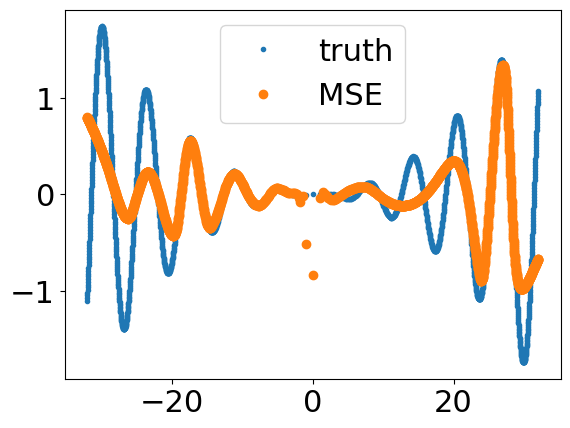

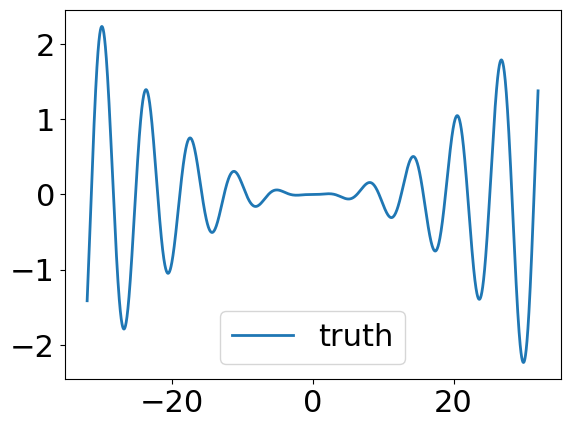

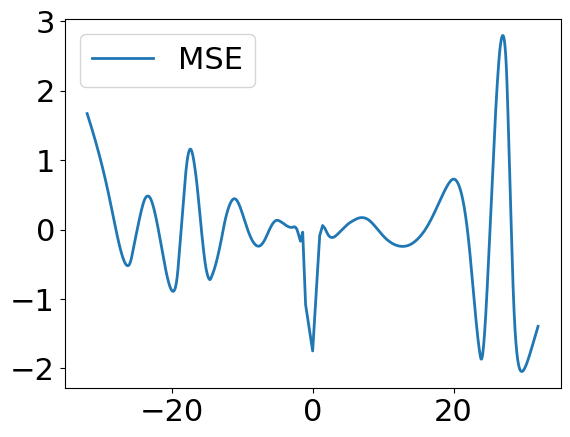

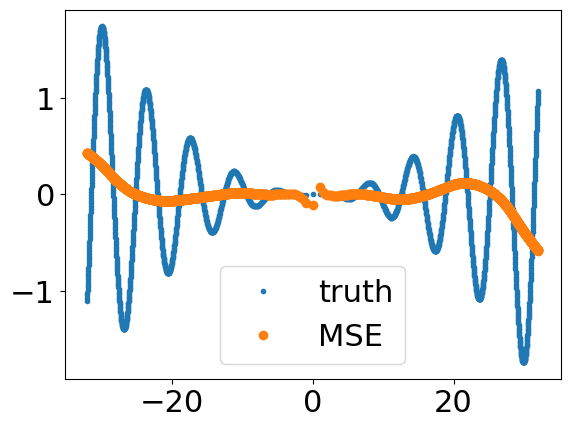

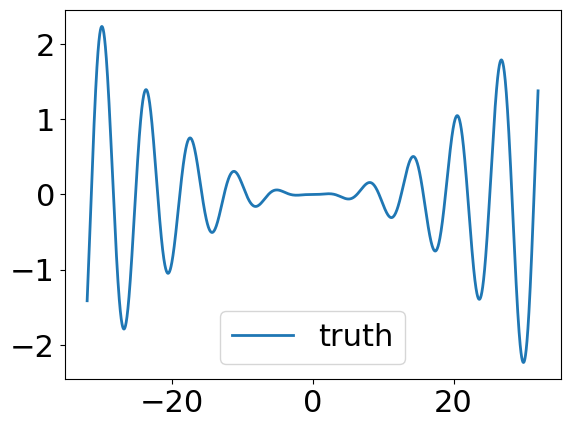

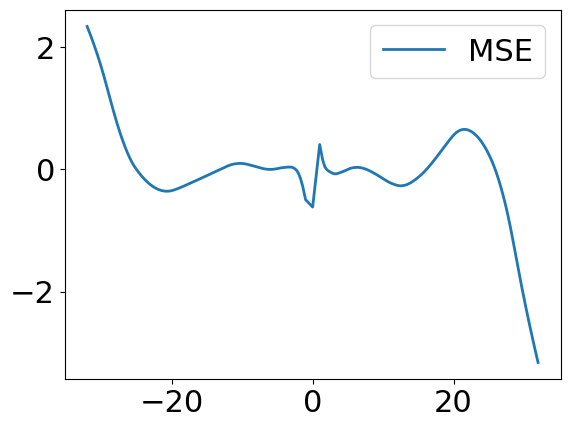

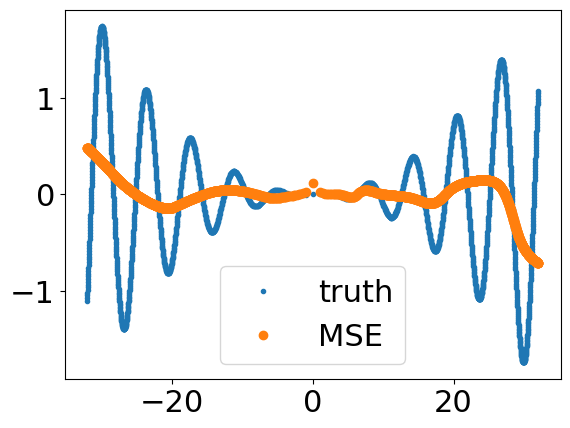

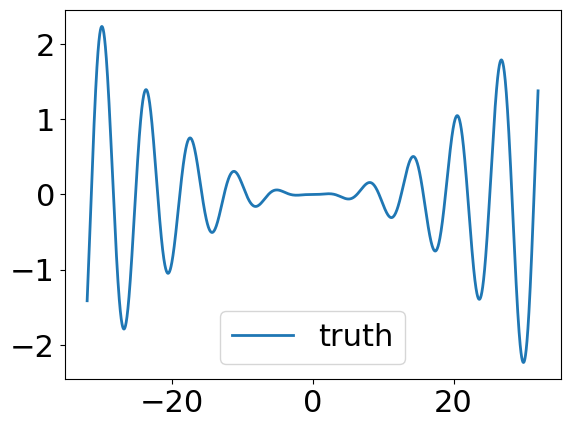

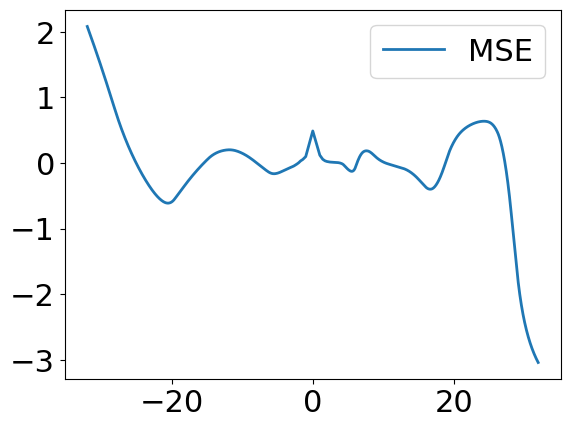

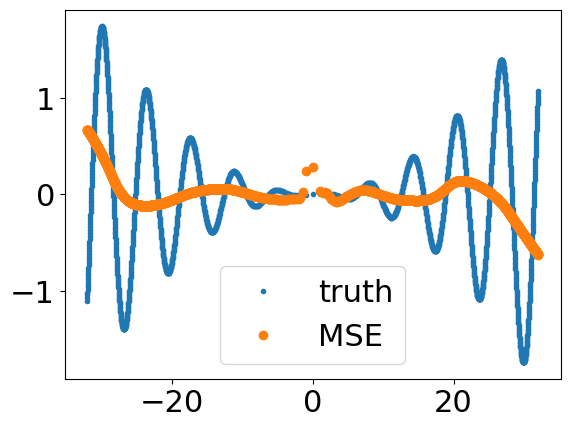

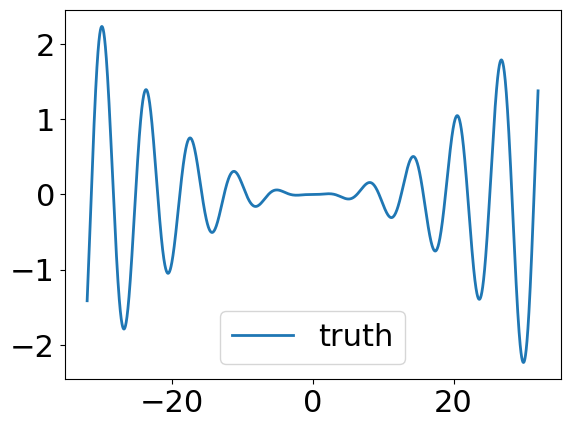

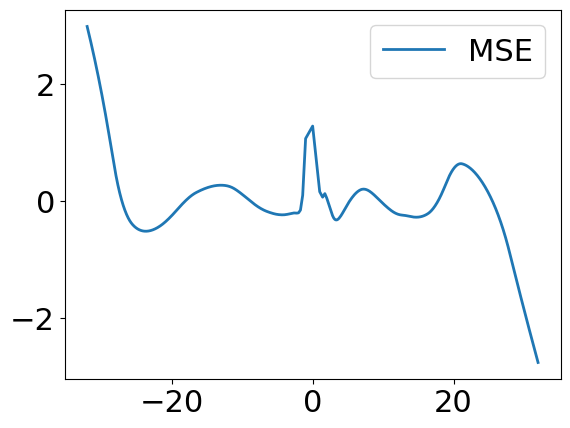

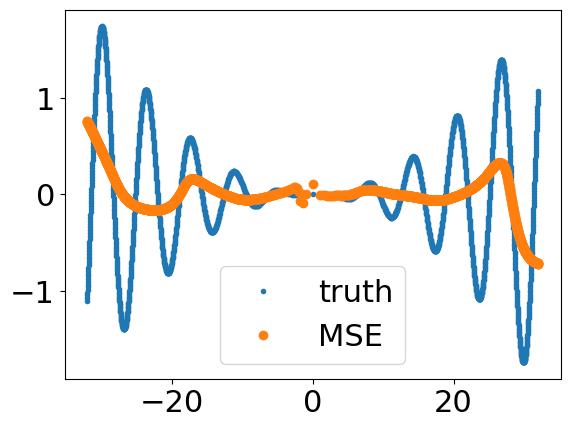

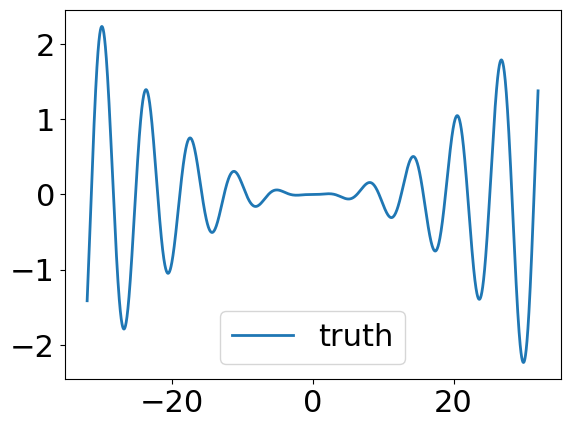

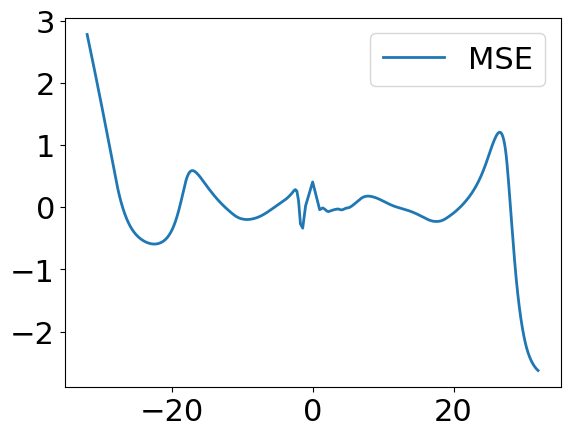

In [7]:
lr = 0.01
decay = 0

seeds = [1,2,3,4,5]
preds_MSE = []

for seed in seeds:
    set_all_seeds(seed)
    loss_MSE = torch.nn.MSELoss()
    model = MLP(input_dim=X.shape[-1], hidden_sizes=tuple([100]*5), num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    for epoch in range(epochs):
        epoch_loss = 0 
        pred = []
        truth = []
        ratio = epoch/epochs
        for idx, data in enumerate(trainloader):
            optimizer.zero_grad()
            tr_X, tr_Y = data[0], data[1]
            pred_Y, _ = model(tr_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(tr_Y.cpu().detach().numpy())
            
            loss = loss_MSE(pred_Y, tr_Y)
            
            epoch_loss += loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()
        epoch_loss /= idx
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        tr_MAE = np.abs(pred-truth).mean()
        tr_RMSE = ((pred-truth)**2).mean()**0.5
        tr_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        tr_spear = stats.spearmanr(truth, pred)
        print('Epoch=%s, train_MAE=%.4f, train_RMSE=%.4f, train_Pearson=%.4f, train_Spearman=%.4f, lr=%.4f'%(epoch, tr_MAE, tr_RMSE, tr_pear, tr_spear.statistic, scheduler.get_last_lr()[0]))
        pred = []
        truth = []
        for idx, data in enumerate(testloader):
            te_X, te_Y = data[0], data[1]
            pred_Y, _ = model(te_X)
            pred.append(pred_Y.cpu().detach().numpy())
            truth.append(te_Y.cpu().detach().numpy())
        pred = np.concatenate(pred, axis=0)
        truth = np.concatenate(truth, axis=0)
        test_MAE = np.abs(pred-truth).mean()
        test_RMSE = ((pred-truth)**2).mean()**0.5
        test_pear = np.corrcoef(truth, pred, rowvar=False)[0,1]
        test_spear = stats.spearmanr(truth, pred)
        print('test_MAE=%.4f, test_RMSE=%.4f, test_Pearson=%.4f, test_Spearman=%.4f'%(test_MAE, test_RMSE, test_pear, test_spear.statistic))
        scheduler.step()

    print(te_X.shape)
    print(torch.from_numpy(X).shape)
    pred_Y, _ = model(torch.from_numpy(X).to(torch.float32))
    plt.figure()
    plt.plot(X, y, '.', label='truth')
    plt.plot(X, pred_Y.cpu().detach().numpy(), 'o', label='MSE')
    plt.legend()


    plt.figure()
    plt.plot(X, y/y.std(), label='truth')
    plt.legend()

    plt.figure()
    pred_Y = pred_Y.cpu().detach().numpy()
    plt.plot(X, pred_Y/pred_Y.std(), label='MSE')
    plt.legend()

    preds_MSE.append(pred_Y)
    


[ 0.6299802   0.628312    0.6266413  ... -0.6599132  -0.66023195
 -0.66054803]
[0.14720803 0.14658645 0.14596418 ... 0.05286957 0.05233667 0.05184046]


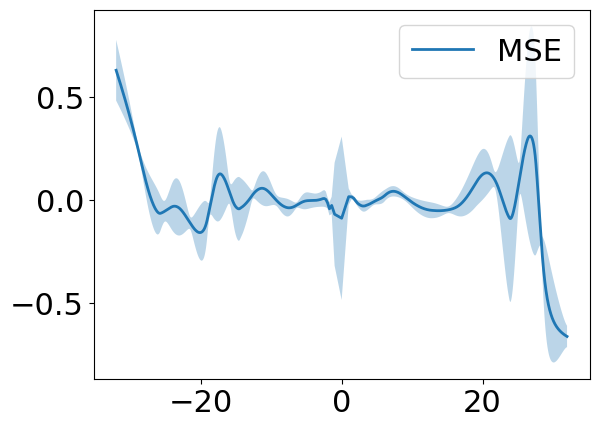

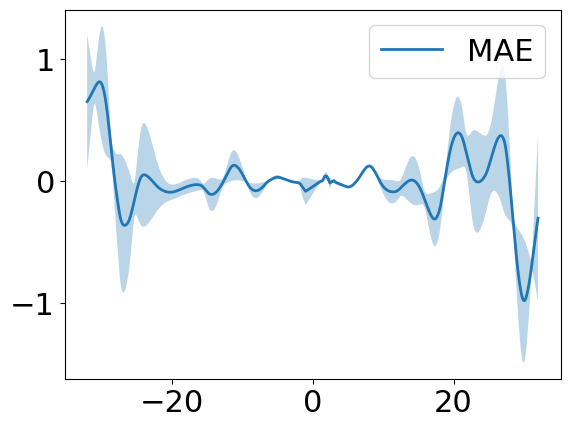

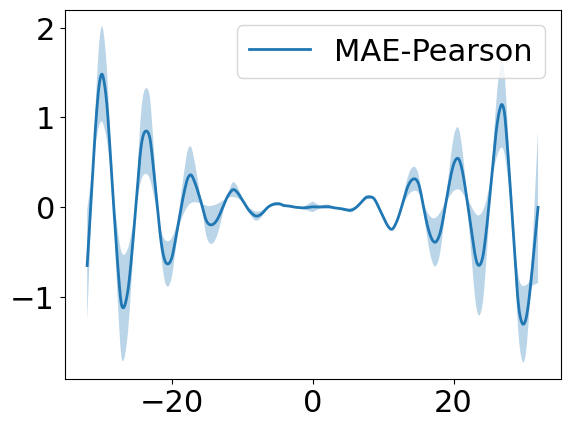

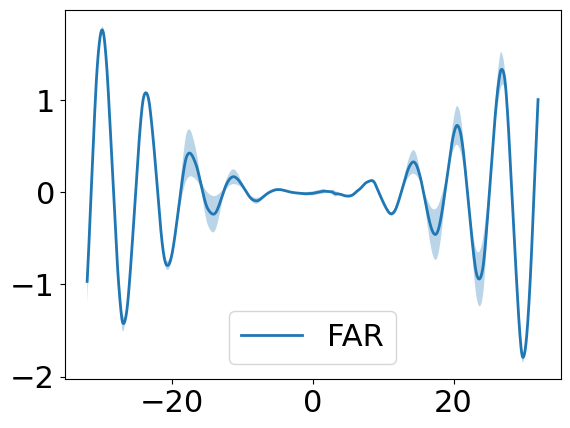

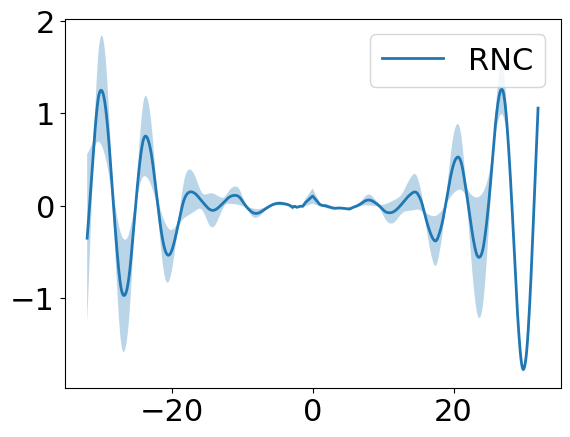

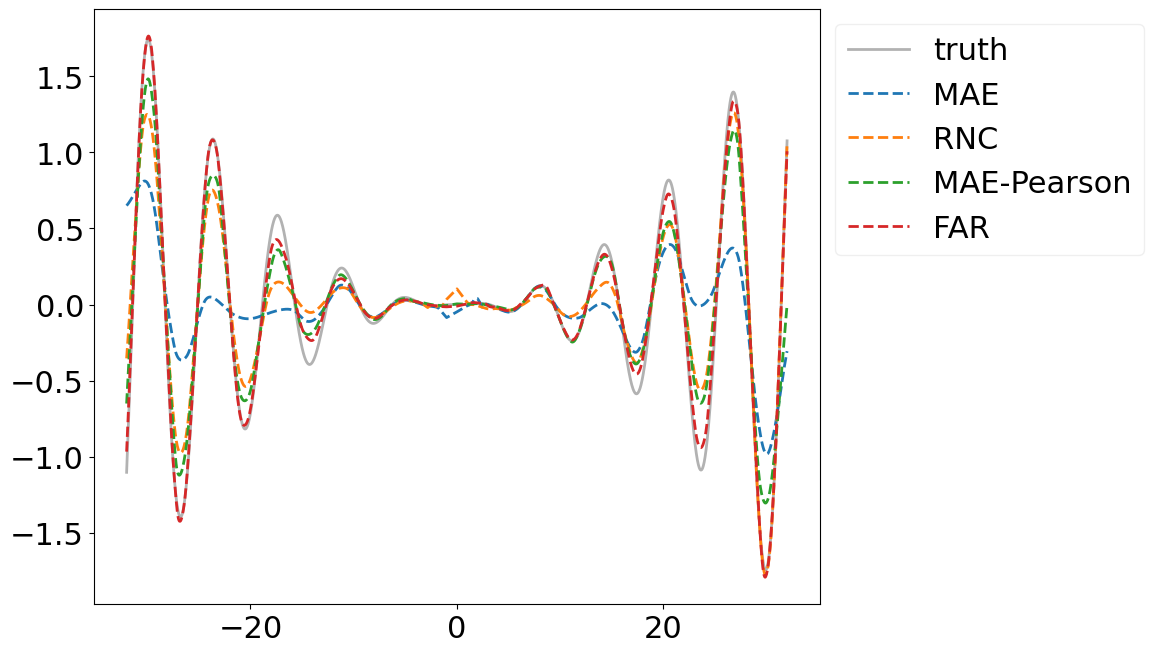

In [8]:
np.savez('data/sq_sine_results.npz', preds_FAR=preds_FAR, preds_RNC=preds_RNC, preds_Pearson=preds_Pearson, preds_MAE=preds_MAE, preds_MSE=preds_MSE)


MSE = np.concatenate(preds_MSE, axis=1)
mean_MSE = MSE.mean(axis=1)
std_MSE = MSE.std(axis=1)
print(mean_MSE)
print(std_MSE)
plt.figure()
plt.plot(X.squeeze(), mean_MSE, label='MSE')
plt.fill_between(X.squeeze(),mean_MSE-std_MSE, mean_MSE+std_MSE, alpha=0.3)
plt.legend()
plt.savefig('figures/sq_sin_MSE.pdf',format='pdf')



MAE = np.concatenate(preds_MAE, axis=1)
mean_MAE = MAE.mean(axis=1)
std_MAE = MAE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MAE, label='MAE')
plt.fill_between(X.squeeze(),mean_MAE-std_MAE, mean_MAE+std_MAE, alpha=0.3)
plt.legend()
plt.savefig('figures/sq_sin_MAE.pdf',format='pdf')



APearson = np.concatenate(preds_Pearson, axis=1)
mean_APearson = APearson.mean(axis=1)
std_APearson = APearson.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_APearson, label='MAE-Pearson')
plt.fill_between(X.squeeze(),mean_APearson-std_APearson, mean_APearson+std_APearson, alpha=0.3)
plt.legend()
plt.savefig('figures/sq_sin_APearson.pdf',format='pdf')


preds_FAR = np.concatenate(preds_FAR, axis=1)
mean_FAR = preds_FAR.mean(axis=1)
std_FAR = preds_FAR.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_FAR, label='FAR')
plt.fill_between(X.squeeze(),mean_FAR-std_FAR, mean_FAR+std_FAR, alpha=0.3)
plt.legend()
plt.savefig('figures/sq_sin_FAR.pdf',format='pdf')



RNC = np.concatenate(preds_RNC, axis=1)
mean_RNC = RNC.mean(axis=1)
std_RNC = RNC.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_RNC, label='RNC')
plt.fill_between(X.squeeze(),mean_RNC-std_RNC, mean_RNC+std_RNC, alpha=0.3)
plt.legend()
plt.savefig('figures/sq_sin_RNC.pdf',format='pdf')


plt.figure(figsize=(12,7))
plt.plot(X, y, 'k-', alpha=0.3, label='truth')
plt.plot(X.squeeze(), mean_MAE, '--', label='MAE')
plt.plot(X.squeeze(), mean_RNC, '--', label='RNC')
plt.plot(X.squeeze(), mean_APearson, '--', label='MAE-Pearson')
plt.plot(X.squeeze(), mean_FAR, '--', label='FAR')
plt.legend(fancybox=True, framealpha=0.3, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('figures/sq_sin_all_mean_cmp.pdf',format='pdf')

# Directly load the pre-executed results without running by yourself

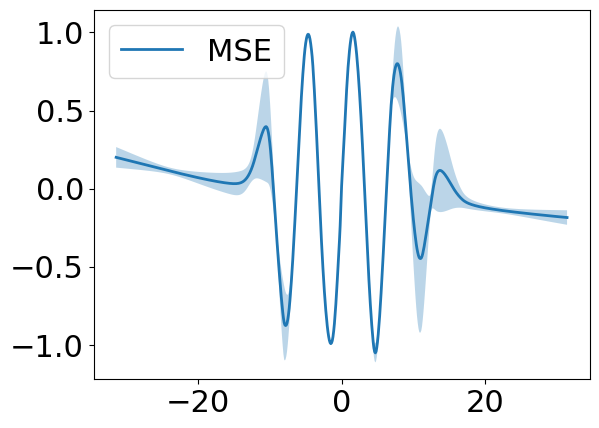

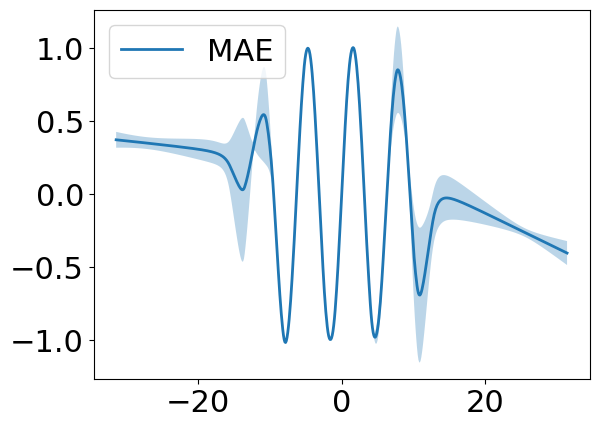

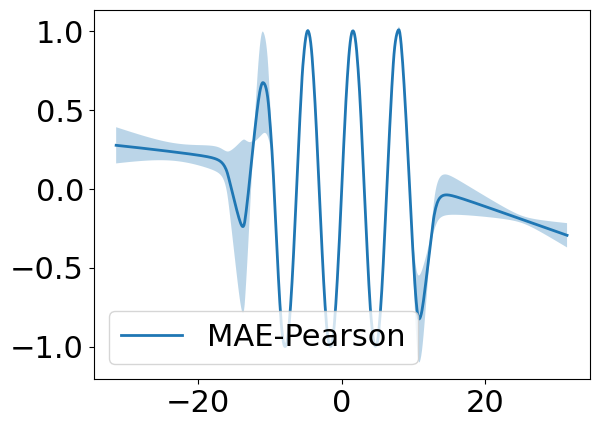

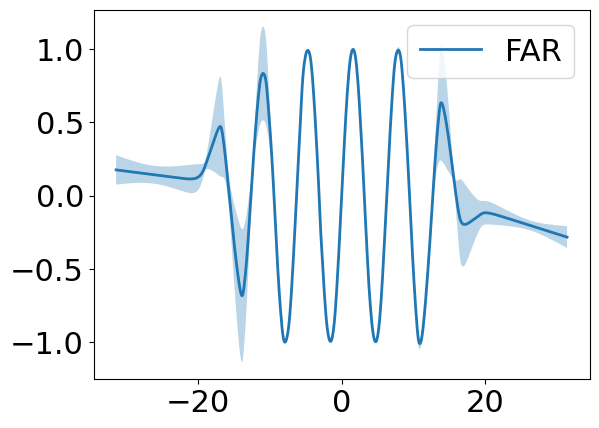

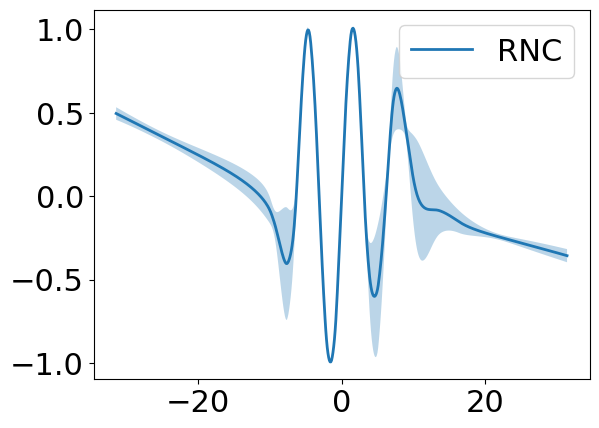

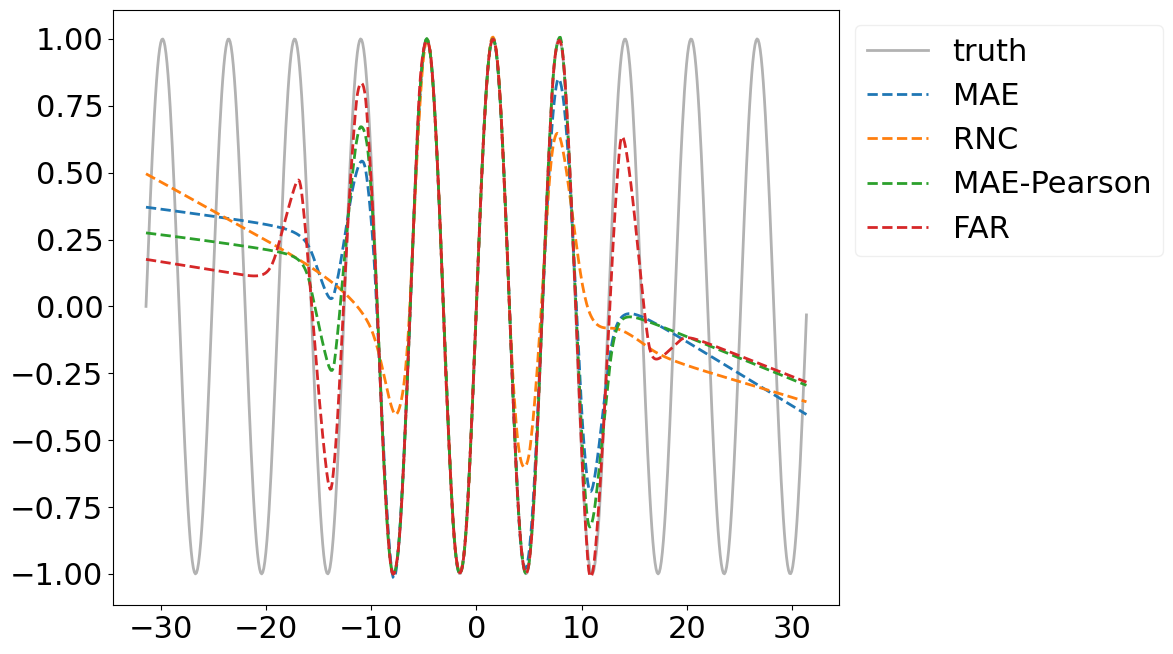

In [9]:
tmp = np.load('data/sine.npz')
X = tmp['X']
y = tmp['y']
ids = tmp['ids']


tmp = np.load('data/sine_results.npz')
preds_MSE, preds_MAE, preds_Pearson, preds_RNC, preds_FAR = tmp['preds_MSE'], tmp['preds_MAE'], tmp['preds_Pearson'], tmp['preds_RNC'], tmp['preds_FAR']


MSE = np.concatenate(preds_MSE, axis=1)
mean_MSE = MSE.mean(axis=1)
std_MSE = MSE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MSE, label='MSE')
plt.fill_between(X.squeeze(),mean_MSE-std_MSE, mean_MSE+std_MSE, alpha=0.3)
plt.legend()



MAE = np.concatenate(preds_MAE, axis=1)
mean_MAE = MAE.mean(axis=1)
std_MAE = MAE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MAE, label='MAE')
plt.fill_between(X.squeeze(),mean_MAE-std_MAE, mean_MAE+std_MAE, alpha=0.3)
plt.legend()



APearson = np.concatenate(preds_Pearson, axis=1)
mean_APearson = APearson.mean(axis=1)
std_APearson = APearson.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_APearson, label='MAE-Pearson')
plt.fill_between(X.squeeze(),mean_APearson-std_APearson, mean_APearson+std_APearson, alpha=0.3)
plt.legend()


preds_FAR = np.concatenate(preds_FAR, axis=1)
mean_FAR = preds_FAR.mean(axis=1)
std_FAR = preds_FAR.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_FAR, label='FAR')
plt.fill_between(X.squeeze(),mean_FAR-std_FAR, mean_FAR+std_FAR, alpha=0.3)
plt.legend()



RNC = np.concatenate(preds_RNC, axis=1)
mean_RNC = RNC.mean(axis=1)
std_RNC = RNC.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_RNC, label='RNC')
plt.fill_between(X.squeeze(),mean_RNC-std_RNC, mean_RNC+std_RNC, alpha=0.3)
plt.legend()


plt.figure(figsize=(12,7))
plt.plot(X, y, 'k-', alpha=0.3, label='truth')
plt.plot(X.squeeze(), mean_MAE, '--', label='MAE')
plt.plot(X.squeeze(), mean_RNC, '--', label='RNC')
plt.plot(X.squeeze(), mean_APearson, '--', label='MAE-Pearson')
plt.plot(X.squeeze(), mean_FAR, '--', label='FAR')
plt.legend(fancybox=True, framealpha=0.3, bbox_to_anchor=(1, 1))
plt.tight_layout()


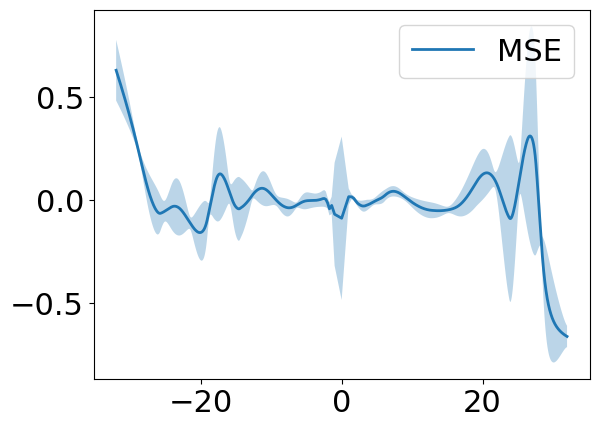

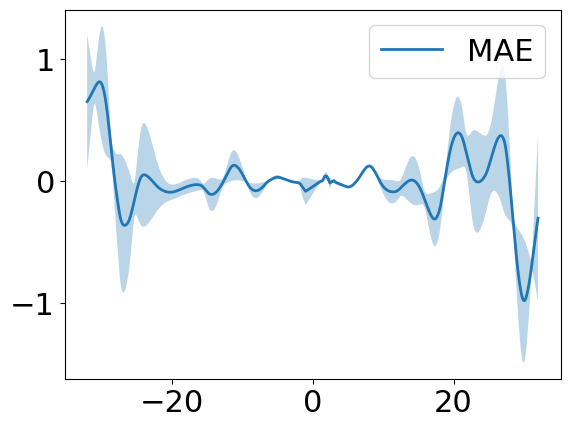

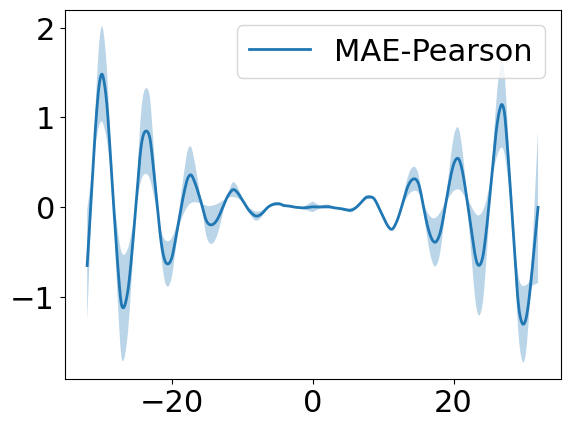

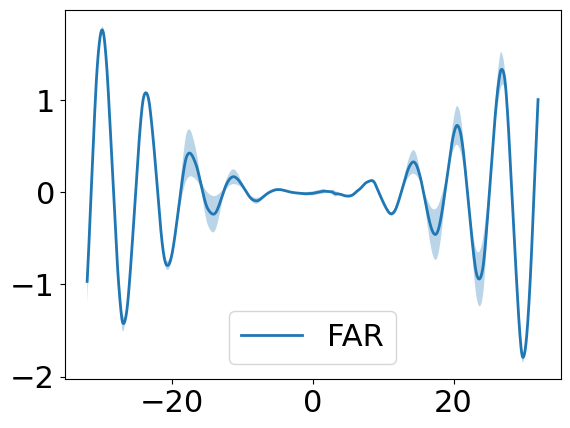

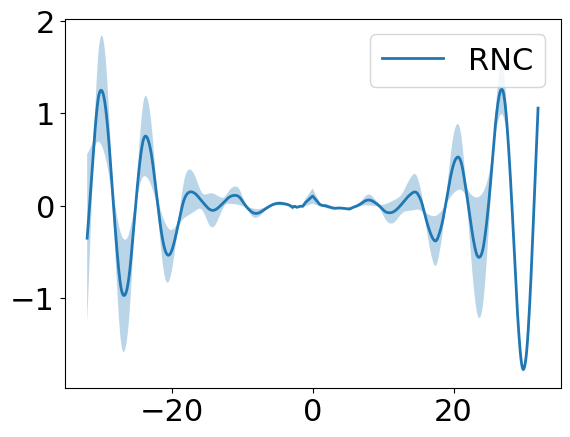

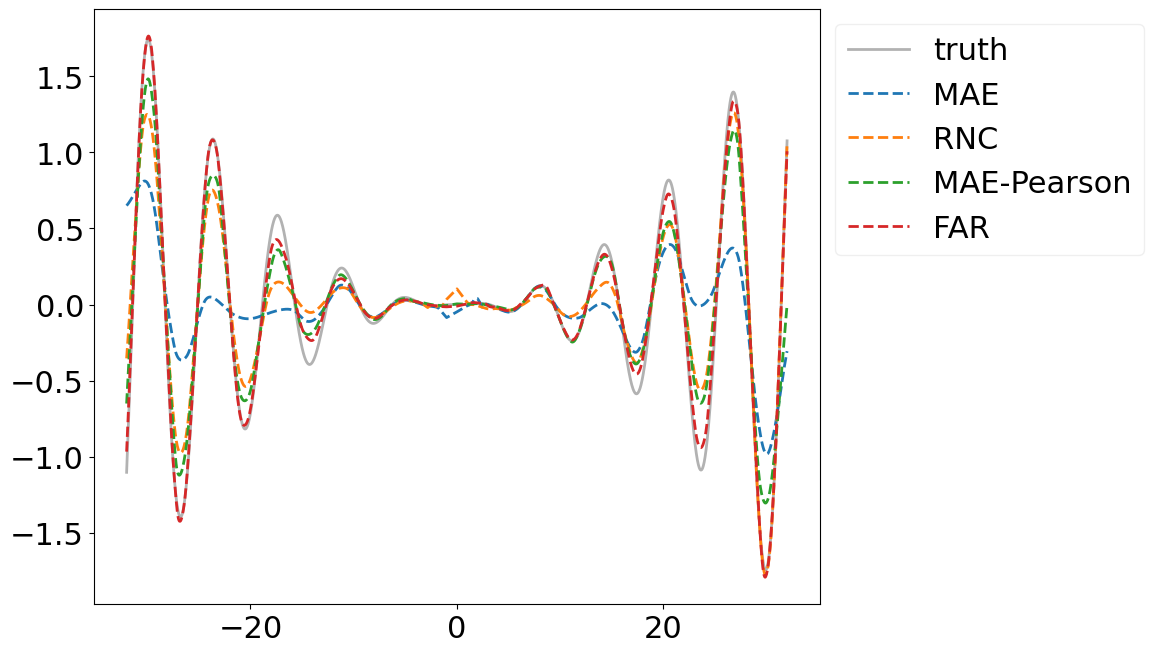

In [9]:
tmp = np.load('data/sq_sine.npz')
X = tmp['X']
y = tmp['y']
ids = tmp['ids']


tmp = np.load('data/sq_sine_results.npz')
preds_MSE, preds_MAE, preds_Pearson, preds_RNC, preds_FAR = tmp['preds_MSE'], tmp['preds_MAE'], tmp['preds_Pearson'], tmp['preds_RNC'], tmp['preds_FAR']


MSE = np.concatenate(preds_MSE, axis=1)
mean_MSE = MSE.mean(axis=1)
std_MSE = MSE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MSE, label='MSE')
plt.fill_between(X.squeeze(),mean_MSE-std_MSE, mean_MSE+std_MSE, alpha=0.3)
plt.legend()



MAE = np.concatenate(preds_MAE, axis=1)
mean_MAE = MAE.mean(axis=1)
std_MAE = MAE.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_MAE, label='MAE')
plt.fill_between(X.squeeze(),mean_MAE-std_MAE, mean_MAE+std_MAE, alpha=0.3)
plt.legend()



APearson = np.concatenate(preds_Pearson, axis=1)
mean_APearson = APearson.mean(axis=1)
std_APearson = APearson.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_APearson, label='MAE-Pearson')
plt.fill_between(X.squeeze(),mean_APearson-std_APearson, mean_APearson+std_APearson, alpha=0.3)
plt.legend()


preds_FAR = np.concatenate(preds_FAR, axis=1)
mean_FAR = preds_FAR.mean(axis=1)
std_FAR = preds_FAR.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_FAR, label='FAR')
plt.fill_between(X.squeeze(),mean_FAR-std_FAR, mean_FAR+std_FAR, alpha=0.3)
plt.legend()



RNC = np.concatenate(preds_RNC, axis=1)
mean_RNC = RNC.mean(axis=1)
std_RNC = RNC.std(axis=1)
plt.figure()
plt.plot(X.squeeze(), mean_RNC, label='RNC')
plt.fill_between(X.squeeze(),mean_RNC-std_RNC, mean_RNC+std_RNC, alpha=0.3)
plt.legend()


plt.figure(figsize=(12,7))
plt.plot(X, y, 'k-', alpha=0.3, label='truth')
plt.plot(X.squeeze(), mean_MAE, '--', label='MAE')
plt.plot(X.squeeze(), mean_RNC, '--', label='RNC')
plt.plot(X.squeeze(), mean_APearson, '--', label='MAE-Pearson')
plt.plot(X.squeeze(), mean_FAR, '--', label='FAR')
plt.legend(fancybox=True, framealpha=0.3, bbox_to_anchor=(1, 1))
plt.tight_layout()
